In [1]:
%load_ext iminizinc
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import datetime
from z3 import *

<IPython.core.display.Javascript object>

MiniZinc to FlatZinc converter, version 2.4.3, build 122680178
Copyright (C) 2014-2020 Monash University, NICTA, Data61


<b> <h2> ACCESSORY FUNCTIONS </h2> </b>

In [2]:
"""
Read a given instance of the Present Wrapping Problem(PWP)
Format:
1-9 12  width and height of the paper roll(strip)
2-5     the number of necessary pieces of paper to cut off
3-3 3   n lines follow, each with xi and yi, representing the horizontal and vertical dimensions of the i-th piece of paper
4-2 4
5-2 8
6-3 9
7-4 12
"""
def read_instance(path):
    file = open(path,"r").readlines()
    pr_w , pr_h = tuple(map(int, file[0].rstrip("\n").split(" ")))
    n_pieces = int(file[1].rstrip("\n"))
    L = []
    for i in range(2, n_pieces + 2):
        L.append(list(map(int, file[i].rstrip("\n").split(" "))))
    return pr_w, pr_h, n_pieces, L


"""
Save given solution/s for a specific instance of the Present Wrapping Problem(PWP)

File name Format: width x height [(# solution)][-rot].txt
    just 1 solution => no (# sol.)   
    -rot only if pieces rotation enabled

Content Format:
1-9 12       width and height of the paper roll(strip)
2-5          the number of pieces
3-3 3   4 0  n lines follow, each with xi, yi and the corresponding solution coordinates(x y)
4-2 4   7 0  
5-2 8   7 4  
6-3 9   4 3  
7-4 12  0 0  
"""
def save_solution(path, pr_w, pr_h, n_pieces, pieces, solutions):
    MAX_SAVING_SOL = 10   #given n solution I will create(save) at most MAX_SAVING_SOL files.(I want to avoid creating thousands of files)
    
    # Only one solution
    if not isinstance(solutions, list):
        solutions = [solutions]
        
    for n, sol in enumerate(solutions):
        print(n)
        dim = []
        rot = "-rot" if 'rot' in sol else ""
        name = f"{path}/{pr_w}x{pr_h}-out{rot}.txt" if n==0 else f"{path}/{pr_w}x{pr_h}({n})-out{rot}.txt"
        q = sol["q"]
        
        f = open(name, "w")
        f.write(f"{pr_w} {pr_h}\n")
        f.write(f"{n_pieces}\n")
        dim = pieces
        if 'rot' in sol: #Managed the save with rotation   0:no rotation, 1:yes rotation
            dim = update_dim_based_on_rot(dim, sol["rot"])
            
        for i, p in enumerate(dim):
            f.write(f"{p[0]} {p[1]}\t{q[i][0]} {q[i][1]}\n")
        
        f.close()
        
        if n>=MAX_SAVING_SOL:
            break

In [3]:
"""
Given the pieces make the ascending or descending ordering according to the 'reverse' boolean value
"""
def order_pieces(pieces, reverse=False):
    areas = [p[0] * p[1] for p in pieces]
    sorted_indices = sorted(range(len(areas)), key=lambda k: areas[k], reverse=reverse)
    ordered_pieces = [pieces[i] for i in sorted_indices]
    return ordered_pieces

In [4]:
PRINT_FIRST_N_SOL = 100
PRINT_LAST_N_SOL = 100
PRINT_EVERY_N_SOL = 10000

"""
Given an instance and 1 solution, create a graphical representation of that solution
"""
def graph_solution(pr_w, pr_h, n_pieces, pieces, q, colours=None):
    if colours is None:
        colours = np.random.rand(n_pieces, 3)
    fig, ax = plt.subplots()
    for i in range(n_pieces):
        ax.add_patch(patches.Rectangle(
            q[i],
            pieces[i][0],
            pieces[i][1],
            facecolor=colours[i]
        ))
    ax.axis("equal")
    ax.xaxis.set_ticks(np.arange(0, pr_w+2, 2))
    ax.set_xlim(0, pr_w)
    ax.yaxis.set_ticks(np.arange(0, pr_h+2, 2))
    ax.set_ylim(0, pr_h)
    plt.show()
    print(f"Solution: {q}")
    print(f"[w, h]:   {pieces}\n")

"""
Given the dimensions of each pieces(width and height), according to the rotation information, 
the function modify the width and height for each of them.
ex: 
l  = [[5, 5], [5, 3], [3, 5], [3, 3]]
rot= [0, 1, 1, 0]

c  = [[5, 5], [3, 5], [5, 3], [3, 3]] returned
"""
def update_dim_based_on_rot(l, rot):
    c = []
    for i, r in enumerate(rot):
        if r == 1: #I have to invert the i-th value of l
            c.append([l[i][1], l[i][0]])
        else:
            c.append([l[i][0], l[i][1]])
    return c
    
"""
Print the first PRINT_FIRST_N_SOL, the last PRINT_LAST_N_SOL solutions and in between every PRINT_EVERY_N_SOL solutions.
"""
def print_solutions(res, instance_info):
    n_sol = len(res)
    colours = np.random.rand(instance_info['n'], 3)
    if not isinstance(res, list):
        n_sol = 1
        print("coords:   {}".format(res["q"]))
        dim = instance_info['p']
        if 'rot' in res: #I manage the printing with rotation   0:no rotation, 1:yes rotation
            print("rotation: {}".format(res["rot"]))
            dim = update_dim_based_on_rot(dim, res["rot"])
            
        graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, res["q"], colours)
    else:
        last_i = 0
        for i, x in enumerate(res):
            dim = []
            if i < PRINT_FIRST_N_SOL or i >= (n_sol-PRINT_LAST_N_SOL) or ((i+1)%PRINT_EVERY_N_SOL == 0):
                if i > last_i+1:
                    print(" ... ")
                print("{} : {} ".format(i, x['q']))
                
                dim = instance_info['p']
                if 'rot' in x: #I manage the printing with rotation   0:no rotation, 1:yes rotation
                    print("rotation: {}".format(x["rot"]))
                    dim = update_dim_based_on_rot(dim, x["rot"])
                
                graph_solution(instance_info['w'], instance_info['h'], instance_info['n'], dim, x["q"], colours)
                last_i = i
                
    print("Tot: {}\n".format(n_sol))

<b> <h2> CP </h2> </b>

Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=8
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=26
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.177127
mzn-stat-end
mzn-stat: initTime=0.007
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=32
mzn-stat: propagators=28
mzn-stat: propagations=74
mzn-stat: nodes=5
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=4
mzn-stat-end
coords:   [[0, 0], [0, 3], [3, 0], [3, 3]]


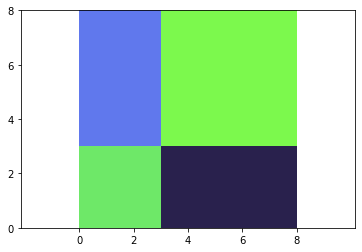

Solution: [[0, 0], [0, 3], [3, 0], [3, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Tot: 1



In [5]:
"""
Example of using the model pwp_v8
"""
model_name = "pwp_v9.mzn"  # the CP Model
instance_name = "8x8"      # the name of the instance

path = f"Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)

#add -a to search all the solutions(up to 5 min of searching)
solutions = %minizinc -s CP/src/$model_name -t 300000  

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L}) # graphically solution/s printing
# save_solution("CP/out", pr_w, pr_h, n_pieces, L, solutions)             # save the solution/s in the CP/out folder

<b> TEST 1 </b> (see report) <br>
Open the mzn model(pwp_v9.mzn), set 'bool: independent_solving_on_w <b>= false</b>;'(line 22) and comment the search_ann lines at the end of the model(from line 73 to 78). Comment first also the "<b>Symmetry breaking rules</b>" part(from line 52 to 54) and later uncomment it.<br>
Set 'ord_type' as described below and run the next cell three times <br>
no-ord $\;\;$  => set ord_type = 'no-ord' <br>
ord $\;\;\;\;\;\;$     => set ord_type = 'ord' <br>
decr-ord => set ord_type = 'decr-ord'

In [12]:
model_name = "pwp_v9.mzn"
instances_name = ["8x8","9x9","10x10","11x11","12x12","13x13","14x14","15x15","16x16","17x17","18x18","19x19","20x20","21x21"]

In [11]:
"""
Run this part 3 times changing the 'ord_type' value with the "Symmetry breaking rules" part commented and uncommented.
"""

ord_type = 'decr-ord'#-1°   'ord'-2°   'decr-ord'-3°
for i in instances_name:
    path = f"Instances/{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    if ord_type in ['ord','decr-ord']:
        unordered_pieces = list(L)
        decr_order = True if ord_type == 'decr-ord' else False
        L = order_pieces(L, reverse=decr_order)
    
    print(f"|| === Instance {i} === ||")
    solutions = %minizinc -a -s CP/src/$model_name -t 300000
    #print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

|| === Instance 8x8 === ||
Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=3
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=8
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=26
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.151287
mzn-stat-end
mzn-stat: initTime=0.008
mzn-stat: solveTime=0
mzn-stat: solutions=3
mzn-stat: variables=32
mzn-stat: propagators=16
mzn-stat: propagations=121
mzn-stat: nodes=7
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
|| === Instance 9x9 === ||
Warning, ignored search annotation: search_ann
%%%mzn-stat: nSolutions=16
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=9
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=42
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime

<b> TEST 2 </b> (see report) <br>
Open the mzn model(pwp_v9.mzn), set 'bool: independent_solving_on_w <b>= false</b>;'(line 22) <br>
Comment and uncomment by hands from the first search_ann line to the last (from line 77 to 82) to execute the test two times, 'ord_type<b>=ord|decr-ord</b>'.<br>
ord $\;\;\;\;\;\;$     => decr_order = <u>False</u> and apply ordering <br>
decr-ord => decr_order = <u>True</u> and apply ordering <br>
NB: comment/uncomment the relative search_ann row inside the model(pwp_v9.mzn)

In [24]:
"""
Run this part 2(ord_type=ord|decr-ord) times for each search_ann possible(I-min, ff-min, DomWdeg-min, I-rand, ff-rand, DomWdeg-rand).
"""
ord_type = 'ord'#-1°   'decr-ord'-2°
for i in instances_name:
    path = f"Instances/{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    if ord_type in ['ord','decr-ord']:
        unordered_pieces = list(L)
        decr_order = True if ord_type == 'decr-ord' else False
        L = order_pieces(L, reverse=decr_order)
    
    print(f"|| === Instance {i} === ||")
    solutions = %minizinc -a -s CP/src/$model_name -t 300000
    #print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=3
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=24
mzn-stat: flatIntVars=8
mzn-stat: flatBoolConstraints=6
mzn-stat: flatIntConstraints=26
mzn-stat: evaluatedHalfReifiedConstraints=24
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.154819
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0.001
mzn-stat: solutions=3
mzn-stat: variables=32
mzn-stat: propagators=16
mzn-stat: propagations=128
mzn-stat: nodes=9
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=1
mzn-stat-end
|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=16
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=9
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=42
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.158423
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=

<b> TEST 3 </b> (see report) <br>
Open the mzn model(pwp_v9.mzn), set 'bool: independent_solving_on_w <b>= independent_solving_on_w_possible()</b>;'(line 22) <br>
Uncomment the line corresponding the best search_ann strategy(line 77) inside the model(pwp_v9.mzn)

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=8
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=6
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.168138
mzn-stat-end
mzn-stat: initTime=0.007
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=20
mzn-stat: propagators=7
mzn-stat: propagations=19
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end


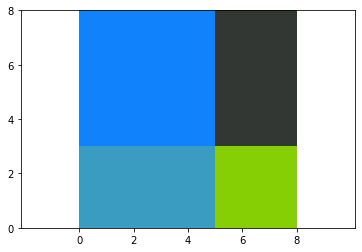

Solution: [[5, 0], [5, 3], [0, 0], [0, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=9
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=42
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.177338
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=51
mzn-stat: propagators=40
mzn-stat: propagations=119
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


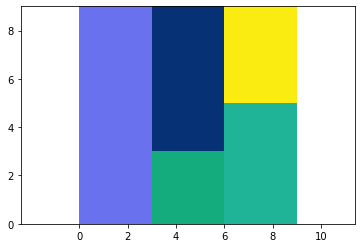

Solution: [[3, 0], [6, 5], [6, 0], [3, 3], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=58
mzn-stat: flatIntVars=12
mzn-stat: flatBoolConstraints=15
mzn-stat: flatIntConstraints=60
mzn-stat: evaluatedHalfReifiedConstraints=58
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.171818
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=74
mzn-stat: propagators=46
mzn-stat: propagations=134
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


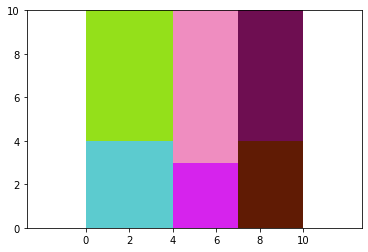

Solution: [[4, 0], [7, 0], [7, 4], [4, 3], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=84
mzn-stat: flatIntVars=14
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=86
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.171898
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=98
mzn-stat: propagators=91
mzn-stat: propagations=950
mzn-stat: nodes=20
mzn-stat: failures=5
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


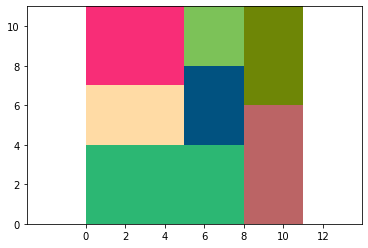

Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 4], [0, 7], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=112
mzn-stat: flatIntVars=16
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=114
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.162616
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=128
mzn-stat: propagators=121
mzn-stat: propagations=999
mzn-stat: nodes=17
mzn-stat: failures=4
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


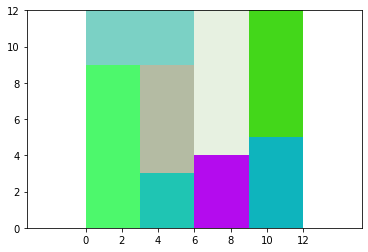

Solution: [[3, 0], [6, 0], [9, 0], [3, 3], [9, 5], [6, 4], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=144
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=146
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.174488
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=162
mzn-stat: propagators=169
mzn-stat: propagations=959
mzn-stat: nodes=15
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


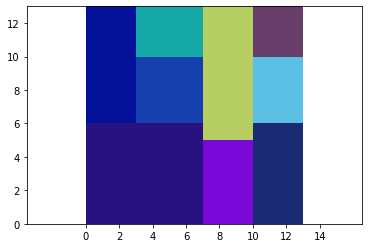

Solution: [[10, 10], [10, 6], [7, 0], [10, 0], [0, 6], [7, 5], [3, 10], [3, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=144
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.19377
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=164
mzn-stat: propagators=129
mzn-stat: propagations=393
mzn-stat: nodes=10
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=9
mzn-stat-end


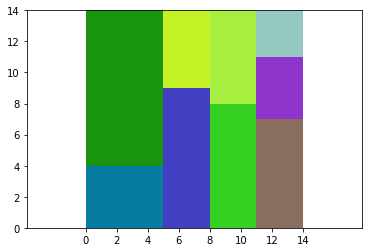

Solution: [[11, 11], [11, 7], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=19
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=182
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.161935
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=201
mzn-stat: propagators=193
mzn-stat: propagations=699
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


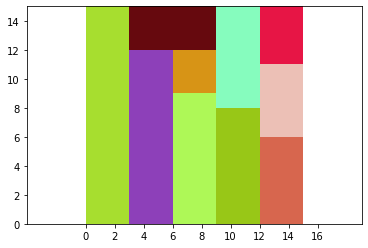

Solution: [[6, 9], [12, 11], [12, 6], [12, 0], [9, 8], [9, 0], [6, 0], [3, 0], [0, 0], [3, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=20
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=182
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.201667
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=200
mzn-stat: propagators=198
mzn-stat: propagations=714
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


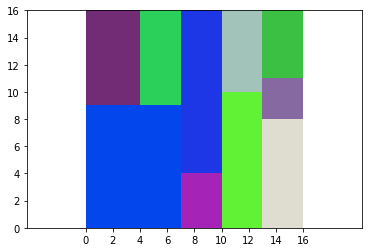

Solution: [[13, 8], [7, 0], [13, 11], [10, 10], [4, 9], [13, 0], [10, 0], [7, 4], [0, 9], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=264
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=266
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.18944
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=288
mzn-stat: propagators=309
mzn-stat: propagations=6316
mzn-stat: nodes=149
mzn-stat: failures=67
mzn-stat: restarts=0
mzn-stat: peakDepth=17
mzn-stat-end


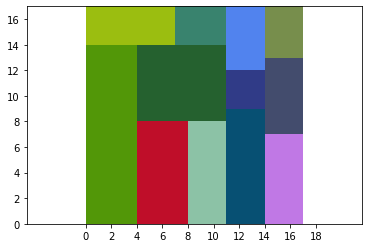

Solution: [[11, 9], [14, 13], [11, 12], [14, 7], [14, 0], [8, 0], [11, 0], [7, 14], [4, 0], [0, 0], [0, 14], [4, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=392
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=104
mzn-stat: flatIntConstraints=394
mzn-stat: evaluatedHalfReifiedConstraints=392
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.254614
mzn-stat-end
mzn-stat: initTime=0.018
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=440
mzn-stat: propagators=366
mzn-stat: propagations=1076
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end


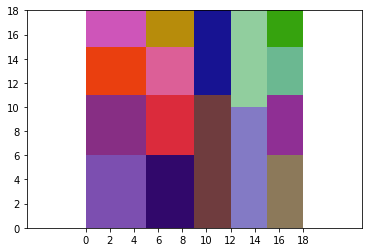

Solution: [[15, 15], [15, 11], [15, 6], [15, 0], [9, 11], [12, 10], [12, 0], [9, 0], [5, 15], [5, 11], [5, 6], [5, 0], [0, 15], [0, 11], [0, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]



|| === Instance 19x19 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=358
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=360
mzn-stat: evaluatedHalfReifiedConstraints=358
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.201223
mzn-stat-end
mzn-stat: initTime=0.019
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=393
mzn-stat: propagators=339
mzn-stat: propagations=1118
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-

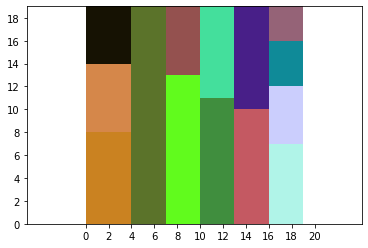

Solution: [[16, 16], [16, 12], [16, 7], [7, 13], [16, 0], [10, 11], [13, 10], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=364
mzn-stat: flatIntVars=28
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=366
mzn-stat: evaluatedHalfReifiedConstraints=364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.263573
mzn-stat-end
mzn-stat: initTime=0.017
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=392
mzn-stat: propagators=316
mzn-stat: propagations=1550
mzn-stat: nodes=22
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end


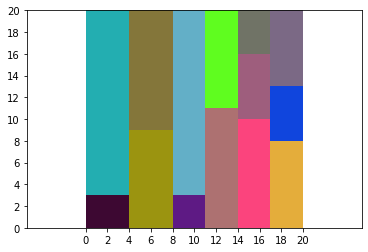

Solution: [[8, 0], [14, 16], [17, 8], [14, 10], [17, 13], [17, 0], [11, 11], [14, 0], [11, 0], [8, 3], [0, 0], [4, 0], [4, 9], [0, 3]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=388
mzn-stat: flatIntVars=25
mzn-stat: flatBoolConstraints=99
mzn-stat: flatIntConstraints=390
mzn-stat: evaluatedHalfReifiedConstraints=388
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.186578
mzn-stat-end
mzn-stat: initTime=0.017
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=428
mzn-stat: propagators=334
mzn-stat: propagations=3375
mzn-stat: nodes=69
mzn-stat: failures=26
mzn-stat: restarts=0
mzn-stat: peakDepth=17
mzn-stat-end


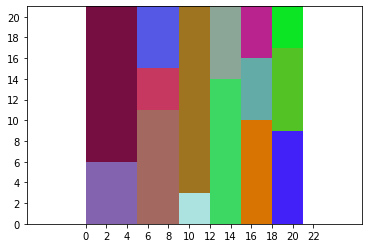

Solution: [[9, 0], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 3], [5, 11], [5, 15], [5, 0], [0, 0], [0, 6]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=480
mzn-stat: flatIntVars=31
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=482
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.18367
mzn-stat-end
mzn-stat: initTime=0.022
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=513
mzn-stat: propagators=528
mzn-stat: propagations=2320
mzn-stat: nodes=23
mzn-stat: failures=1
mzn-stat: restarts=0
mzn-stat: peakDept

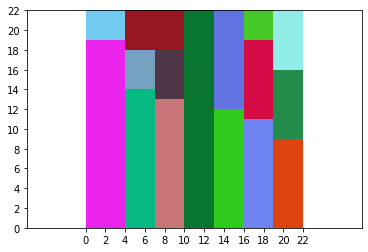

Solution: [[16, 19], [4, 14], [7, 13], [19, 16], [19, 9], [16, 11], [19, 0], [13, 12], [16, 0], [13, 0], [7, 0], [4, 0], [10, 0], [0, 19], [0, 0], [4, 18]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.215242
mzn-stat-end
mzn-stat: initTime=0.024
mzn-stat: solveTime=1.014
mzn-stat: solutions=1
mzn-stat: variables=722
mzn-stat: propagators=810
mzn-stat: propagations=3961744
mzn-stat: nodes=73879
mzn-stat: failures=369

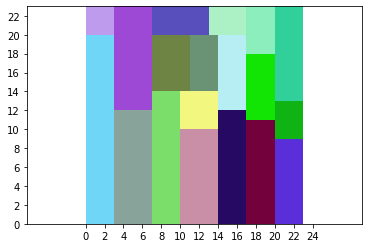

Solution: [[0, 20], [20, 9], [17, 18], [11, 14], [17, 11], [14, 12], [20, 0], [20, 13], [17, 0], [14, 0], [7, 0], [0, 0], [13, 20], [10, 10], [7, 14], [10, 0], [3, 12], [3, 0], [7, 20]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]



|| === Instance 24x24 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=566
mzn-stat: flatIntVars=29
mzn-stat: flatBoolConstraints=145
mzn-stat: flatIntConstraints=568
mzn-stat: evaluatedHalfReifiedConstraints=566
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.224307
mzn-stat-end
mzn-stat: initTime=0.021
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=615
mzn-stat: propagators=491

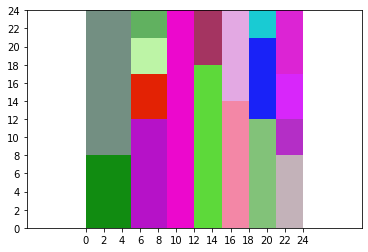

Solution: [[18, 21], [21, 8], [21, 12], [12, 18], [21, 17], [21, 0], [18, 12], [15, 14], [18, 0], [15, 0], [12, 0], [9, 0], [5, 21], [5, 17], [5, 12], [5, 0], [0, 0], [0, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=37
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.1827
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=17.578
mzn-stat: solutions=1
mzn-stat: variables=723
mzn-stat: propagators=765
mzn-stat: propagations=11

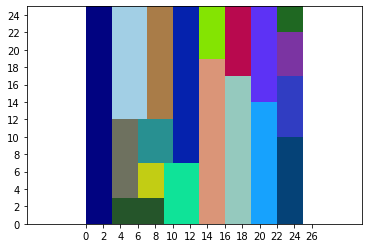

Solution: [[22, 22], [6, 3], [22, 17], [13, 19], [22, 10], [16, 17], [3, 3], [22, 0], [19, 14], [7, 12], [19, 0], [16, 0], [10, 7], [13, 0], [0, 0], [6, 7], [9, 0], [3, 12], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]



|| === Instance 26x26 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=44
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=926
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.201837
mzn-stat-end
mzn-stat: initTime=0.031
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=968
mzn-stat: propagators=8

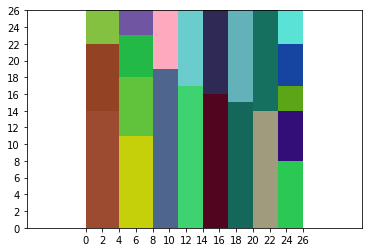

Solution: [[23, 14], [23, 22], [23, 17], [23, 8], [8, 19], [23, 0], [11, 17], [14, 16], [17, 15], [20, 14], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [4, 23], [0, 22], [4, 18], [4, 11], [0, 14], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=840
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=210
mzn-stat: flatIntConstraints=842
mzn-stat: evaluatedHalfReifiedConstraints=840
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.21111
mzn-stat-end
mzn-stat: initTime=0.031
mzn-stat: solve

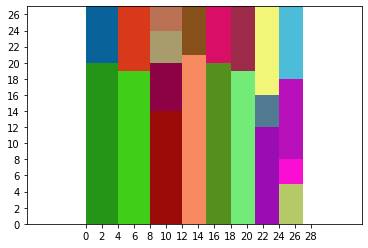

Solution: [[24, 5], [21, 12], [24, 0], [12, 21], [15, 20], [18, 19], [24, 18], [24, 8], [21, 16], [21, 0], [18, 0], [15, 0], [12, 0], [8, 24], [8, 20], [8, 14], [0, 20], [4, 19], [8, 0], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=918
mzn-stat: flatIntVars=41
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=920
mzn-stat: evaluatedHalfReifiedConstraints=918
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.197014
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0.001
mzn-stat: solutio

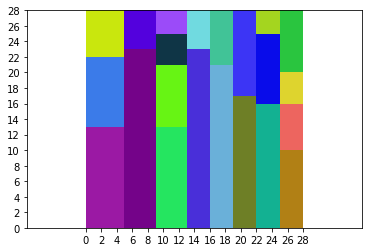

Solution: [[22, 25], [25, 16], [13, 23], [25, 10], [16, 21], [25, 20], [22, 16], [25, 0], [19, 17], [22, 0], [19, 0], [16, 0], [13, 0], [9, 25], [9, 21], [5, 23], [9, 13], [9, 0], [5, 0], [0, 22], [0, 13], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1098
mzn-stat: flatIntVars=45
mzn-stat: flatBoolConstraints=276
mzn-stat: flatIntConstraints=1100
mzn-stat: evaluatedHalfReifiedConstraints=1098
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.21603
mzn-stat-end
mzn-stat: initTime=0.038
mzn-stat: sol

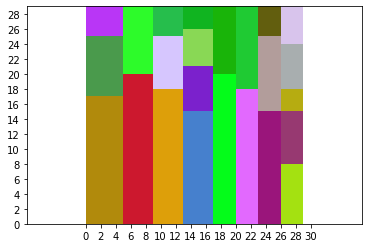

Solution: [[26, 15], [23, 25], [26, 24], [26, 18], [26, 8], [26, 0], [17, 20], [23, 15], [20, 18], [23, 0], [20, 0], [17, 0], [13, 26], [9, 25], [13, 21], [13, 15], [9, 18], [5, 20], [13, 0], [9, 0], [5, 0], [0, 25], [0, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=720
mzn-stat: flatIntVars=33
mzn-stat: flatBoolConstraints=185
mzn-stat: flatIntConstraints=722
mzn-stat: evaluatedHalfReifiedConstraints=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.216279
m

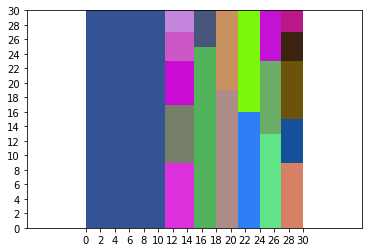

Solution: [[27, 27], [27, 23], [15, 25], [27, 9], [24, 23], [27, 15], [27, 0], [24, 13], [18, 19], [24, 0], [21, 16], [21, 0], [18, 0], [15, 0], [11, 27], [11, 23], [11, 17], [11, 9], [11, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=654
mzn-stat: flatIntVars=31
mzn-stat: flatBoolConstraints=167
mzn-stat: flatIntConstraints=656
mzn-stat: evaluatedHalfReifiedConstraints=654
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.182341
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variab

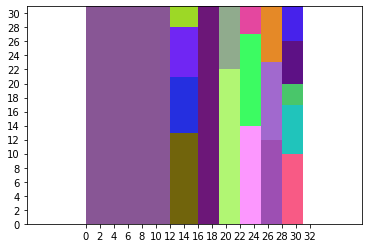

Solution: [[28, 17], [22, 27], [28, 26], [28, 20], [28, 10], [25, 23], [19, 22], [28, 0], [25, 12], [25, 0], [22, 14], [22, 0], [19, 0], [16, 0], [12, 28], [12, 21], [12, 13], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1404
mzn-stat: flatIntVars=54
mzn-stat: flatBoolConstraints=351
mzn-stat: flatIntConstraints=1406
mzn-stat: evaluatedHalfReifiedConstraints=1404
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.23592
mzn-stat-end
mzn-stat: initTime=0.042
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1458
mzn-sta

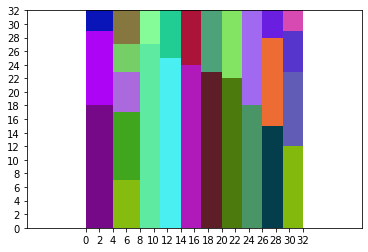

Solution: [[29, 29], [26, 28], [8, 27], [29, 23], [11, 25], [14, 24], [17, 23], [20, 22], [29, 12], [29, 0], [26, 15], [23, 18], [26, 0], [23, 0], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [0, 29], [4, 23], [4, 27], [4, 17], [4, 0], [4, 7], [0, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1010
mzn-stat: flatIntVars=43
mzn-stat: flatBoolConstraints=253
mzn-stat: flatIntConstraints=1012
mzn-stat: eval

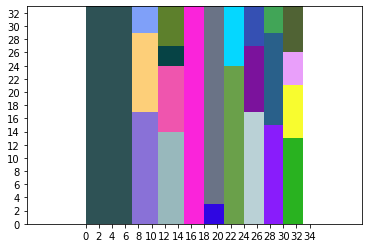

Solution: [[18, 0], [27, 29], [30, 21], [24, 27], [30, 26], [30, 13], [21, 24], [24, 17], [30, 0], [27, 15], [27, 0], [24, 0], [21, 0], [18, 3], [15, 0], [11, 24], [7, 29], [11, 27], [11, 14], [7, 17], [11, 0], [7, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=810
mzn-stat: flatIntVars=35
mzn-stat: flatBoolConstraints=206
mzn-stat: flatIntConstraints=812
mzn-stat: evaluatedHalfReifiedConstraints=810
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.226318
mzn-stat-end
mzn

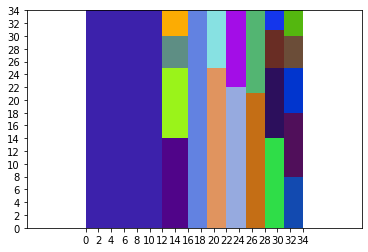

Solution: [[28, 31], [31, 30], [31, 25], [28, 25], [31, 18], [31, 0], [19, 25], [31, 8], [28, 14], [22, 22], [25, 21], [28, 0], [25, 0], [22, 0], [19, 0], [16, 0], [12, 30], [12, 25], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=926
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.200946
mzn-stat-end
mzn-stat: initTime=0.03
mzn-stat: solveTime=0.002
m

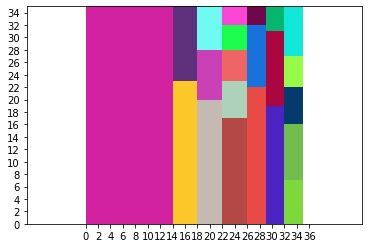

Solution: [[26, 32], [29, 31], [32, 22], [32, 16], [32, 0], [32, 27], [32, 7], [26, 22], [29, 19], [29, 0], [26, 0], [22, 32], [22, 28], [22, 23], [22, 17], [18, 28], [18, 20], [14, 23], [22, 0], [18, 0], [14, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=916
mzn-stat: flatIntVars=36
mzn-stat: flatBoolConstraints=234
mzn-stat: flatIntConstraints=918
mzn-stat: evaluatedHalfReifiedConstraints=916
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.196713
mzn-stat-end
mzn-stat: initTime=0.029
mzn-s

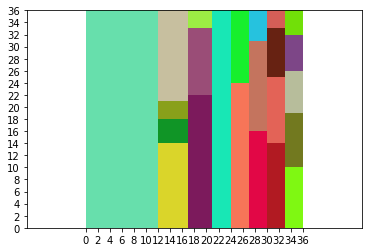

Solution: [[30, 33], [33, 32], [27, 31], [33, 26], [33, 19], [30, 25], [33, 10], [33, 0], [30, 14], [24, 24], [30, 0], [27, 16], [27, 0], [24, 0], [21, 0], [17, 33], [17, 22], [17, 0], [12, 18], [12, 14], [12, 0], [12, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1364
mzn-stat: flatIntVars=47
mzn-stat: flatBoolConstraints=346
mzn-stat: flatIntConstraints=1366
mzn-stat: evaluatedHalfReifiedConstraints=1364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.242068
mzn-st

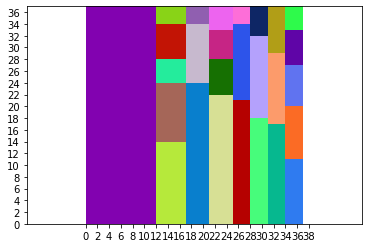

Solution: [[25, 34], [34, 33], [28, 32], [34, 27], [34, 20], [31, 29], [34, 11], [34, 0], [31, 17], [25, 21], [28, 18], [31, 0], [28, 0], [25, 0], [17, 34], [21, 33], [21, 28], [21, 22], [17, 24], [21, 0], [17, 0], [12, 34], [12, 24], [12, 28], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=36
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-st

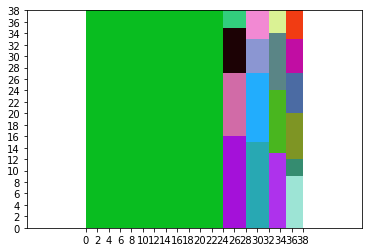

Solution: [[35, 9], [32, 34], [35, 33], [35, 27], [35, 20], [35, 12], [35, 0], [32, 24], [32, 13], [32, 0], [24, 35], [28, 33], [28, 27], [24, 27], [24, 16], [28, 15], [28, 0], [24, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1624
mzn-stat: flatIntVars=56
mzn-stat: flatBoolConstraints=406
mzn-stat: flatIntConstraints=1626
mzn-stat: evaluatedHalfReifiedConstraints=1624
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.245663
mzn-stat-end
mzn-stat: initTime=0.047
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1685
mzn-sta

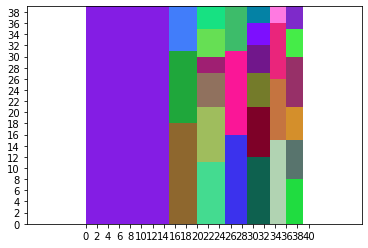

Solution: [[33, 36], [36, 35], [36, 30], [36, 15], [36, 8], [36, 0], [36, 21], [33, 26], [33, 15], [33, 0], [29, 36], [29, 32], [29, 27], [29, 21], [25, 31], [29, 12], [29, 0], [25, 16], [25, 0], [20, 27], [20, 35], [20, 30], [20, 21], [15, 31], [20, 11], [20, 0], [15, 18], [15, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=640
mzn-stat: flatIntVars=29
mzn-stat: flatBoolConstra

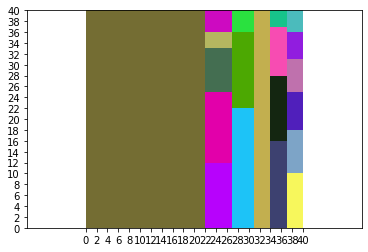

Solution: [[34, 37], [37, 36], [37, 31], [37, 25], [37, 18], [37, 10], [34, 28], [37, 0], [34, 16], [34, 0], [31, 0], [27, 36], [27, 22], [27, 0], [22, 33], [22, 36], [22, 25], [22, 0], [22, 12], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]





In [27]:
"""
Run this part 6 times changing the search_ann (I-min, ff-min, DomWdeg-min, I-rand, ff-rand, DomWdeg-rand) in the model.
"""

starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    path = f"Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/src/$model_name -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
        #save_solution("CP/out", pr_w, pr_h, n_pieces, L, sol) #-uncomment this line to save the solution of each instance
    else:
        print("No solution found in 5min")
    
    print(f"Pieces: {L}")
    print("\n\n")

Using the Symmetries breaking, independent solving on w(uncommented lines: 22, 62-69) and the best search strategy(input_order indomain_min-<i>see report</i>) I find 1 solution for each instances and save it in the out folder.

|| === Instance 8x8 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=4
mzn-stat: flatIntVars=4
mzn-stat: flatBoolConstraints=2
mzn-stat: flatIntConstraints=6
mzn-stat: evaluatedHalfReifiedConstraints=4
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.161524
mzn-stat-end
mzn-stat: initTime=0.001
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=20
mzn-stat: propagators=7
mzn-stat: propagations=19
mzn-stat: nodes=3
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=2
mzn-stat-end


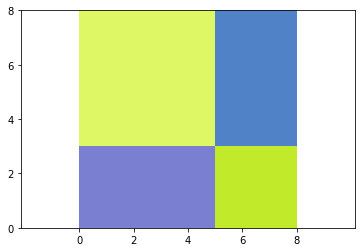

Solution: [[5, 0], [5, 3], [0, 0], [0, 3]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

0
Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=40
mzn-stat: flatIntVars=9
mzn-stat: flatBoolConstraints=10
mzn-stat: flatIntConstraints=42
mzn-stat: evaluatedHalfReifiedConstraints=40
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.163562
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=51
mzn-stat: propagators=40
mzn-stat: propagations=119
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


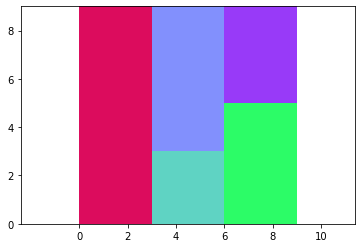

Solution: [[3, 0], [6, 5], [6, 0], [3, 3], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=58
mzn-stat: flatIntVars=10
mzn-stat: flatBoolConstraints=15
mzn-stat: flatIntConstraints=60
mzn-stat: evaluatedHalfReifiedConstraints=58
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.167627
mzn-stat-end
mzn-stat: initTime=0.009
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=74
mzn-stat: propagators=46
mzn-stat: propagations=134
mzn-stat: nodes=6
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=5
mzn-stat-end


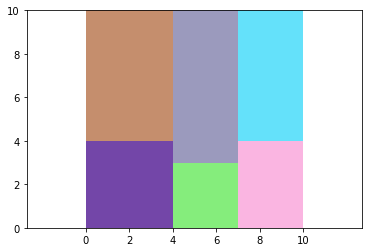

Solution: [[4, 0], [7, 0], [7, 4], [4, 3], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

0
Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=84
mzn-stat: flatIntVars=14
mzn-stat: flatBoolConstraints=21
mzn-stat: flatIntConstraints=86
mzn-stat: evaluatedHalfReifiedConstraints=84
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.17048
mzn-stat-end
mzn-stat: initTime=0.01
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=98
mzn-stat: propagators=91
mzn-stat: propagations=948
mzn-stat: nodes=20
mzn-stat: failures=5
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end


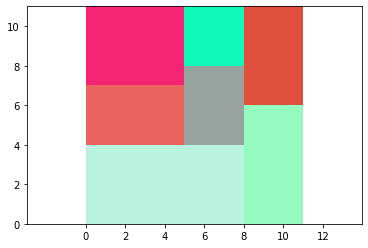

Solution: [[5, 8], [5, 4], [8, 6], [8, 0], [0, 4], [0, 7], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=112
mzn-stat: flatIntVars=16
mzn-stat: flatBoolConstraints=28
mzn-stat: flatIntConstraints=114
mzn-stat: evaluatedHalfReifiedConstraints=112
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.172836
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=128
mzn-stat: propagators=121
mzn-stat: propagations=2138
mzn-stat: nodes=37
mzn-stat: failures=14
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


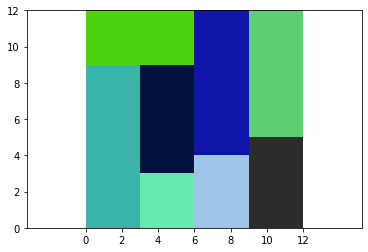

Solution: [[3, 0], [6, 0], [9, 0], [3, 3], [9, 5], [6, 4], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=144
mzn-stat: flatIntVars=18
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=146
mzn-stat: evaluatedHalfReifiedConstraints=144
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.185207
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=162
mzn-stat: propagators=169
mzn-stat: propagations=959
mzn-stat: nodes=15
mzn-stat: failures=2
mzn-stat: restarts=0
mzn-stat: peakDepth=12
mzn-stat-end


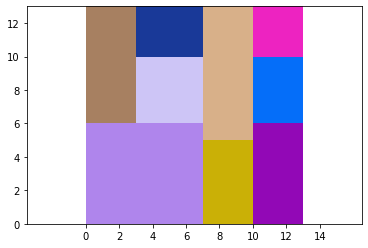

Solution: [[10, 10], [10, 6], [7, 0], [10, 0], [0, 6], [7, 5], [3, 10], [3, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=142
mzn-stat: flatIntVars=16
mzn-stat: flatBoolConstraints=36
mzn-stat: flatIntConstraints=144
mzn-stat: evaluatedHalfReifiedConstraints=142
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.166897
mzn-stat-end
mzn-stat: initTime=0.011
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=164
mzn-stat: propagators=129
mzn-stat: propagations=393
mzn-stat: nodes=10
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=9
mzn-stat-end


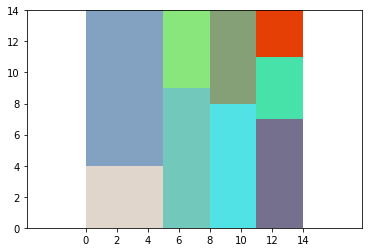

Solution: [[11, 11], [11, 7], [5, 9], [8, 8], [11, 0], [8, 0], [5, 0], [0, 0], [0, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=19
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=182
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.168264
mzn-stat-end
mzn-stat: initTime=0.012
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=201
mzn-stat: propagators=193
mzn-stat: propagations=684
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


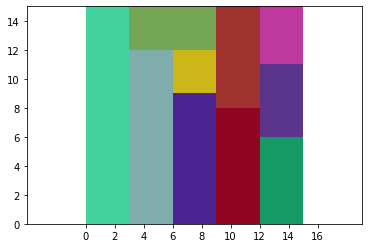

Solution: [[6, 9], [12, 11], [12, 6], [12, 0], [9, 8], [9, 0], [6, 0], [3, 0], [0, 0], [3, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=180
mzn-stat: flatIntVars=20
mzn-stat: flatBoolConstraints=45
mzn-stat: flatIntConstraints=182
mzn-stat: evaluatedHalfReifiedConstraints=180
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.180825
mzn-stat-end
mzn-stat: initTime=0.013
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=200
mzn-stat: propagators=198
mzn-stat: propagations=714
mzn-stat: nodes=12
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=11
mzn-stat-end


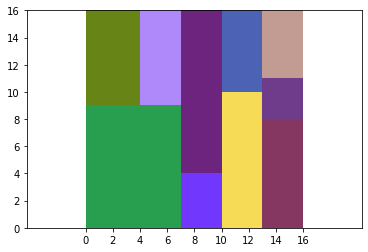

Solution: [[13, 8], [7, 0], [13, 11], [10, 10], [4, 9], [13, 0], [10, 0], [7, 4], [0, 9], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=264
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=66
mzn-stat: flatIntConstraints=266
mzn-stat: evaluatedHalfReifiedConstraints=264
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.183048
mzn-stat-end
mzn-stat: initTime=0.015
mzn-stat: solveTime=0.003
mzn-stat: solutions=1
mzn-stat: variables=288
mzn-stat: propagators=309
mzn-stat: propagations=25089
mzn-stat: nodes=273
mzn-stat: failures=129
mzn-stat: restarts=0
mzn-stat: peakDepth=20
mzn-stat-end


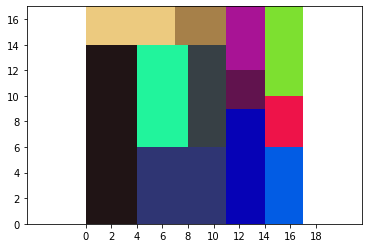

Solution: [[11, 9], [14, 6], [11, 12], [14, 0], [14, 10], [8, 6], [11, 0], [7, 14], [4, 6], [0, 0], [0, 14], [4, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=392
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=104
mzn-stat: flatIntConstraints=394
mzn-stat: evaluatedHalfReifiedConstraints=392
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.198014
mzn-stat-end
mzn-stat: initTime=0.019
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=440
mzn-stat: propagators=366
mzn-stat: propagations=1076
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth=15
mzn-stat-end


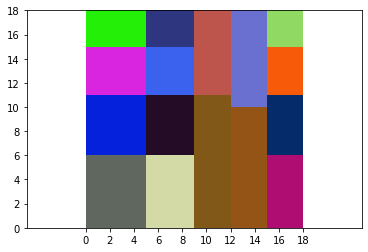

Solution: [[15, 15], [15, 11], [15, 6], [15, 0], [9, 11], [12, 10], [12, 0], [9, 0], [5, 15], [5, 11], [5, 6], [5, 0], [0, 15], [0, 11], [0, 6], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]



|| === Instance 19x19 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=358
mzn-stat: flatIntVars=24
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=360
mzn-stat: evaluatedHalfReifiedConstraints=358
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.179988
mzn-stat-end
mzn-stat: initTime=0.017
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=393
mzn-stat: propagators=339
mzn-stat: propagations=1118
mzn-stat: nodes=16
mzn-stat: failures=0
mzn-stat: restarts=0
mz

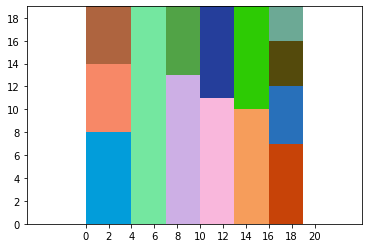

Solution: [[16, 16], [16, 12], [16, 7], [7, 13], [16, 0], [10, 11], [13, 10], [13, 0], [10, 0], [7, 0], [4, 0], [0, 14], [0, 8], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=364
mzn-stat: flatIntVars=28
mzn-stat: flatBoolConstraints=91
mzn-stat: flatIntConstraints=366
mzn-stat: evaluatedHalfReifiedConstraints=364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.216002
mzn-stat-end
mzn-stat: initTime=0.017
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=392
mzn-stat: propagators=316
mzn-stat: propagations=1878
mzn-stat: nodes=32
mzn-stat: failures=7
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end


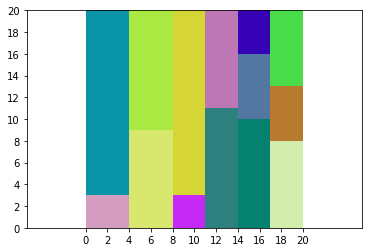

Solution: [[8, 0], [14, 16], [17, 8], [14, 10], [17, 13], [17, 0], [11, 11], [14, 0], [11, 0], [8, 3], [0, 0], [4, 0], [4, 9], [0, 3]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=388
mzn-stat: flatIntVars=25
mzn-stat: flatBoolConstraints=99
mzn-stat: flatIntConstraints=390
mzn-stat: evaluatedHalfReifiedConstraints=388
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.183053
mzn-stat-end
mzn-stat: initTime=0.018
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=428
mzn-stat: propagators=334
mzn-stat: propagations=3508
mzn-stat: nodes=71
mzn-stat: failures=27
mzn-stat: restarts=0
mzn-stat: peakDepth=17
mzn-stat-end


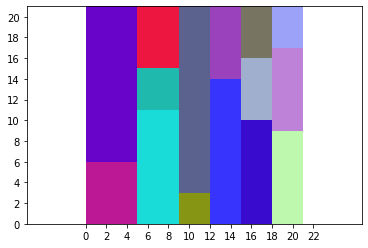

Solution: [[9, 0], [18, 17], [15, 16], [15, 10], [12, 14], [18, 9], [18, 0], [15, 0], [12, 0], [9, 3], [5, 11], [5, 15], [5, 0], [0, 0], [0, 6]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=480
mzn-stat: flatIntVars=31
mzn-stat: flatBoolConstraints=120
mzn-stat: flatIntConstraints=482
mzn-stat: evaluatedHalfReifiedConstraints=480
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.184598
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0
mzn-stat: solutions=1
mzn-stat: variables=513
mzn-stat: propagators=528
mzn-stat: propagations=2076
mzn-stat: nodes=19
mzn-stat: failures=0
mzn-stat: restarts=0
mzn-stat: peakDepth

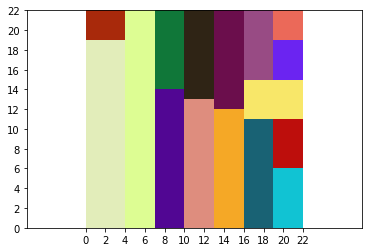

Solution: [[19, 19], [19, 15], [19, 6], [19, 0], [16, 15], [7, 14], [10, 13], [13, 12], [16, 0], [13, 0], [10, 0], [7, 0], [4, 0], [0, 19], [0, 0], [16, 11]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=38
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.193285
mzn-stat-end
mzn-stat: initTime=0.027
mzn-stat: solveTime=7.945
mzn-stat: solutions=1
mzn-stat: variables=722
mzn-stat: propagators=810
mzn-stat: propagations=27281995
mzn-stat: nodes=597585
mzn-stat: failur

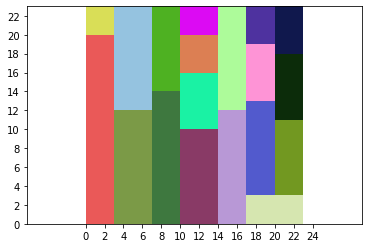

Solution: [[0, 20], [17, 19], [20, 18], [17, 13], [20, 11], [20, 3], [7, 14], [17, 3], [14, 12], [14, 0], [7, 0], [0, 0], [10, 20], [10, 16], [10, 10], [10, 0], [3, 12], [3, 0], [17, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]



|| === Instance 24x24 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=566
mzn-stat: flatIntVars=29
mzn-stat: flatBoolConstraints=145
mzn-stat: flatIntConstraints=568
mzn-stat: evaluatedHalfReifiedConstraints=566
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.188229
mzn-stat-end
mzn-stat: initTime=0.023
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=615
mzn-stat: propagat

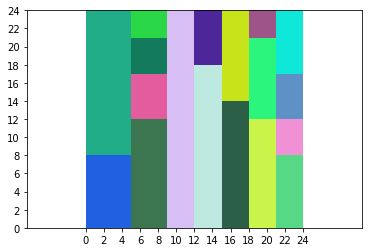

Solution: [[18, 21], [21, 8], [21, 12], [12, 18], [21, 17], [21, 0], [18, 12], [15, 14], [18, 0], [15, 0], [12, 0], [9, 0], [5, 21], [5, 17], [5, 12], [5, 0], [0, 0], [0, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=37
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-stat: evaluatedHalfReifiedConstraints=684
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.192643
mzn-stat-end
mzn-stat: initTime=0.04
mzn-stat: solveTime=0.115
mzn-stat: solutions=1
mzn-stat: variables=723
mzn-stat: propagators=765
mzn-stat: propagations=

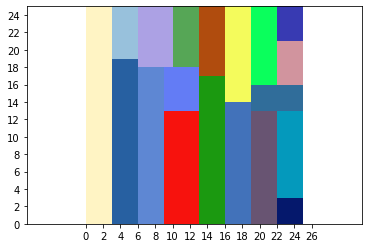

Solution: [[22, 0], [22, 21], [22, 16], [3, 19], [10, 18], [13, 17], [19, 16], [22, 3], [16, 14], [19, 0], [16, 0], [13, 0], [6, 0], [3, 0], [0, 0], [9, 13], [6, 18], [9, 0], [19, 13]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]



|| === Instance 26x26 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=44
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=926
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.204164
mzn-stat-end
mzn-stat: initTime=0.047
mzn-stat: solveTime=0.051
mzn-stat: solutions=1
mzn-stat: variables=968
mzn-stat: propagat

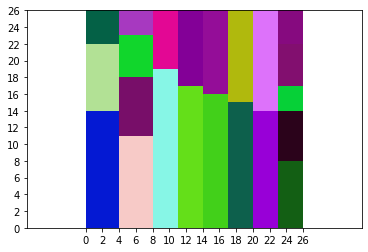

Solution: [[23, 14], [23, 22], [23, 17], [23, 8], [8, 19], [23, 0], [11, 17], [14, 16], [17, 15], [20, 14], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [4, 23], [0, 22], [4, 18], [4, 11], [0, 14], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=840
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=210
mzn-stat: flatIntConstraints=842
mzn-stat: evaluatedHalfReifiedConstraints=840
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.215362
mzn-stat-end
mzn-stat: initTime=0.032
mzn-stat: so

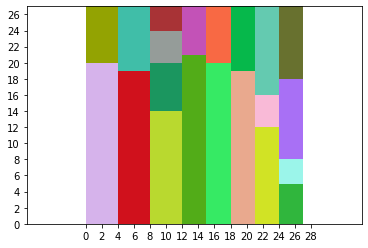

Solution: [[24, 5], [21, 12], [24, 0], [12, 21], [15, 20], [18, 19], [24, 18], [24, 8], [21, 16], [21, 0], [18, 0], [15, 0], [12, 0], [8, 24], [8, 20], [8, 14], [0, 20], [4, 19], [8, 0], [4, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=918
mzn-stat: flatIntVars=41
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=920
mzn-stat: evaluatedHalfReifiedConstraints=918
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.207168
mzn-stat-end
mzn-stat: initTime=0.07
mzn-stat: solveTime=0.006
mzn-stat: solut

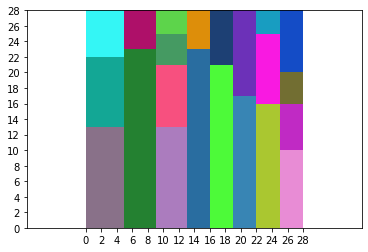

Solution: [[22, 25], [25, 16], [13, 23], [25, 10], [16, 21], [25, 20], [22, 16], [25, 0], [19, 17], [22, 0], [19, 0], [16, 0], [13, 0], [9, 25], [9, 21], [5, 23], [9, 13], [9, 0], [5, 0], [0, 22], [0, 13], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1098
mzn-stat: flatIntVars=45
mzn-stat: flatBoolConstraints=276
mzn-stat: flatIntConstraints=1100
mzn-stat: evaluatedHalfReifiedConstraints=1098
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.220554
mzn-stat-end
mzn-stat: initTime=0.04
mzn-stat: s

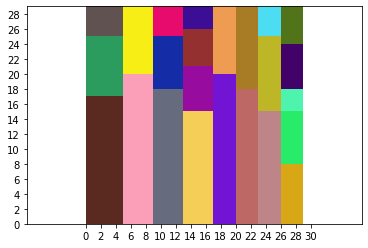

Solution: [[26, 15], [23, 25], [26, 24], [26, 18], [26, 8], [26, 0], [17, 20], [23, 15], [20, 18], [23, 0], [20, 0], [17, 0], [13, 26], [9, 25], [13, 21], [13, 15], [9, 18], [5, 20], [13, 0], [9, 0], [5, 0], [0, 25], [0, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=720
mzn-stat: flatIntVars=33
mzn-stat: flatBoolConstraints=185
mzn-stat: flatIntConstraints=722
mzn-stat: evaluatedHalfReifiedConstraints=720
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.195752

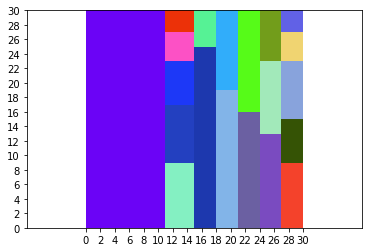

Solution: [[27, 27], [27, 23], [15, 25], [27, 9], [24, 23], [27, 15], [27, 0], [24, 13], [18, 19], [24, 0], [21, 16], [21, 0], [18, 0], [15, 0], [11, 27], [11, 23], [11, 17], [11, 9], [11, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=654
mzn-stat: flatIntVars=31
mzn-stat: flatBoolConstraints=167
mzn-stat: flatIntConstraints=656
mzn-stat: evaluatedHalfReifiedConstraints=654
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.190415
mzn-stat-end
mzn-stat: initTime=0.025
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: 

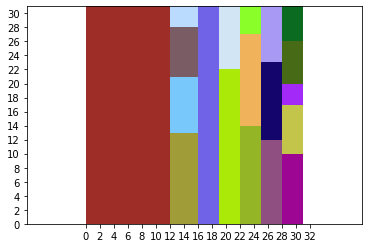

Solution: [[28, 17], [22, 27], [28, 26], [28, 20], [28, 10], [25, 23], [19, 22], [28, 0], [25, 12], [25, 0], [22, 14], [22, 0], [19, 0], [16, 0], [12, 28], [12, 21], [12, 13], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1404
mzn-stat: flatIntVars=54
mzn-stat: flatBoolConstraints=351
mzn-stat: flatIntConstraints=1406
mzn-stat: evaluatedHalfReifiedConstraints=1404
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.243052
mzn-stat-end
mzn-stat: initTime=0.082
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1458
mzn-

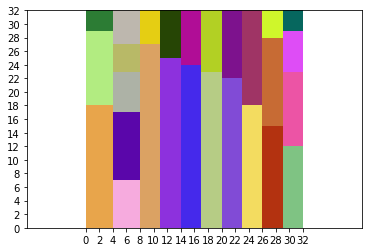

Solution: [[29, 29], [26, 28], [8, 27], [29, 23], [11, 25], [14, 24], [17, 23], [20, 22], [29, 12], [29, 0], [26, 15], [23, 18], [26, 0], [23, 0], [20, 0], [17, 0], [14, 0], [11, 0], [8, 0], [0, 29], [4, 23], [4, 27], [4, 17], [4, 0], [4, 7], [0, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1010
mzn-stat: flatIntVars=43
mzn-stat: flatBoolConstraints=253
mzn-stat: flatIntConstraints=1012
mzn-stat: ev

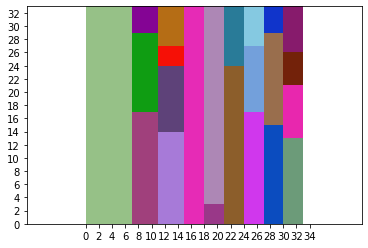

Solution: [[18, 0], [27, 29], [30, 21], [24, 27], [30, 26], [30, 13], [21, 24], [24, 17], [30, 0], [27, 15], [27, 0], [24, 0], [21, 0], [18, 3], [15, 0], [11, 24], [7, 29], [11, 27], [11, 14], [7, 17], [11, 0], [7, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=810
mzn-stat: flatIntVars=35
mzn-stat: flatBoolConstraints=206
mzn-stat: flatIntConstraints=812
mzn-stat: evaluatedHalfReifiedConstraints=810
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.208662
mzn-stat-end
m

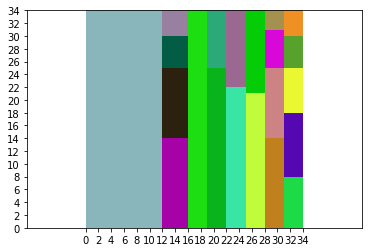

Solution: [[28, 31], [31, 30], [31, 25], [28, 25], [31, 18], [31, 0], [19, 25], [31, 8], [28, 14], [22, 22], [25, 21], [28, 0], [25, 0], [22, 0], [19, 0], [16, 0], [12, 30], [12, 25], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=924
mzn-stat: flatIntVars=42
mzn-stat: flatBoolConstraints=231
mzn-stat: flatIntConstraints=926
mzn-stat: evaluatedHalfReifiedConstraints=924
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.206179
mzn-stat-end
mzn-stat: initTime=0.051
mzn-stat: solveTime=0.02

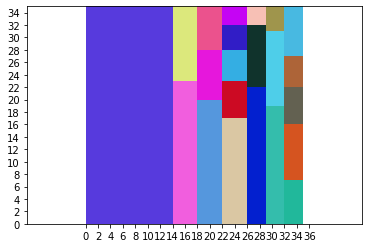

Solution: [[26, 32], [29, 31], [32, 22], [32, 16], [32, 0], [32, 27], [32, 7], [26, 22], [29, 19], [29, 0], [26, 0], [22, 32], [22, 28], [22, 23], [22, 17], [18, 28], [18, 20], [14, 23], [22, 0], [18, 0], [14, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=916
mzn-stat: flatIntVars=36
mzn-stat: flatBoolConstraints=234
mzn-stat: flatIntConstraints=918
mzn-stat: evaluatedHalfReifiedConstraints=916
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.215162
mzn-stat-end
mzn-stat: initTime=0.049
mzn

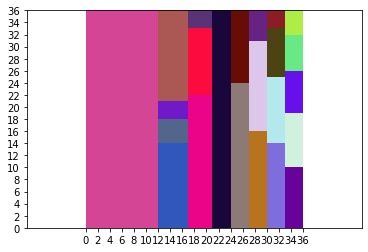

Solution: [[30, 33], [33, 32], [27, 31], [33, 26], [33, 19], [30, 25], [33, 10], [33, 0], [30, 14], [24, 24], [30, 0], [27, 16], [27, 0], [24, 0], [21, 0], [17, 33], [17, 22], [17, 0], [12, 18], [12, 14], [12, 0], [12, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1364
mzn-stat: flatIntVars=47
mzn-stat: flatBoolConstraints=346
mzn-stat: flatIntConstraints=1366
mzn-stat: evaluatedHalfReifiedConstraints=1364
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.247461
mzn-

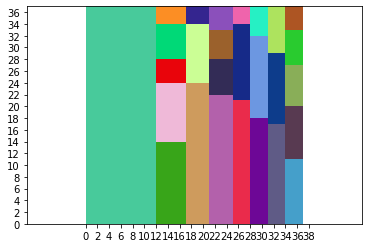

Solution: [[25, 34], [34, 33], [28, 32], [34, 27], [34, 20], [31, 29], [34, 11], [34, 0], [31, 17], [25, 21], [28, 18], [31, 0], [28, 0], [25, 0], [17, 34], [21, 33], [21, 28], [21, 22], [17, 24], [21, 0], [17, 0], [12, 34], [12, 24], [12, 28], [12, 14], [12, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=684
mzn-stat: flatIntVars=36
mzn-stat: flatBoolConstraints=171
mzn-stat: flatIntConstraints=686
mzn-

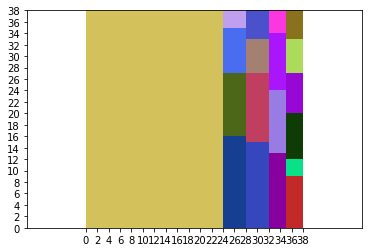

Solution: [[35, 9], [32, 34], [35, 33], [35, 27], [35, 20], [35, 12], [35, 0], [32, 24], [32, 13], [32, 0], [24, 35], [28, 33], [28, 27], [24, 27], [24, 16], [28, 15], [28, 0], [24, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=1624
mzn-stat: flatIntVars=56
mzn-stat: flatBoolConstraints=406
mzn-stat: flatIntConstraints=1626
mzn-stat: evaluatedHalfReifiedConstraints=1624
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.251595
mzn-stat-end
mzn-stat: initTime=0.052
mzn-stat: solveTime=0.001
mzn-stat: solutions=1
mzn-stat: variables=1685
mzn-s

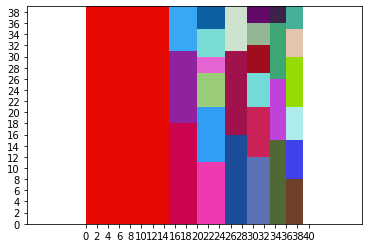

Solution: [[33, 36], [36, 35], [36, 30], [36, 15], [36, 8], [36, 0], [36, 21], [33, 26], [33, 15], [33, 0], [29, 36], [29, 32], [29, 27], [29, 21], [25, 31], [29, 12], [29, 0], [25, 16], [25, 0], [20, 27], [20, 35], [20, 30], [20, 21], [15, 31], [20, 11], [20, 0], [15, 18], [15, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
%%%mzn-stat: nSolutions=1
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=640
mzn-stat: flatIntVars=29
mzn-stat: flatBoolConst

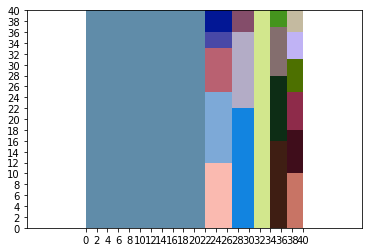

Solution: [[34, 37], [37, 36], [37, 31], [37, 25], [37, 18], [37, 10], [34, 28], [37, 0], [34, 16], [34, 0], [31, 0], [27, 36], [27, 22], [27, 0], [22, 33], [22, 36], [22, 25], [22, 0], [22, 12], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]





In [7]:
"""
The model find at least 1 solution for all the instances. See folder CP/out
"""
model_name = "pwp_v9.mzn"
starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    path = f"Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    # execute the model to get the first solution in 5 min max
    sol = %minizinc -s CP/src/$model_name -t 300000
    
    if sol is not None:
        graph_solution(pr_w, pr_h, n_pieces, L, sol['q'])
        save_solution("CP/out", pr_w, pr_h, n_pieces, L, sol)
    else:
        print("No solution found in 5min")
        
    print(f"Pieces: {L}")
    print("\n\n")

ROTATION (point 5)

%%%mzn-stat: nSolutions=32
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatIntVars=22
mzn-stat: flatIntConstraints=21
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.163687
mzn-stat-end
mzn-stat: initTime=0.003
mzn-stat: solveTime=0.003
mzn-stat: solutions=32
mzn-stat: variables=25
mzn-stat: propagators=41
mzn-stat: propagations=8260
mzn-stat: nodes=457
mzn-stat: failures=197
mzn-stat: restarts=0
mzn-stat: peakDepth=19
mzn-stat-end
0 : [[0, 0], [0, 3], [0, 6], [5, 6], [6, 3]] 
rotation: [1, 1, 1, 1, 0]


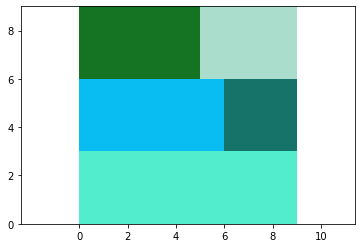

Solution: [[0, 0], [0, 3], [0, 6], [5, 6], [6, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

1 : [[0, 0], [0, 6], [0, 3], [5, 3], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


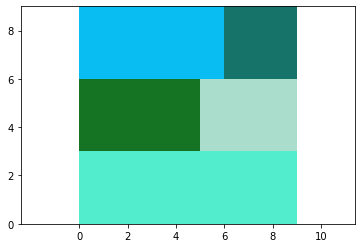

Solution: [[0, 0], [0, 6], [0, 3], [5, 3], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

2 : [[0, 3], [0, 0], [0, 6], [5, 6], [6, 0]] 
rotation: [1, 1, 1, 1, 0]


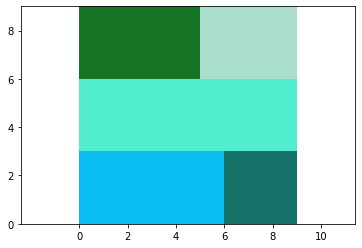

Solution: [[0, 3], [0, 0], [0, 6], [5, 6], [6, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

3 : [[0, 3], [0, 6], [0, 0], [5, 0], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


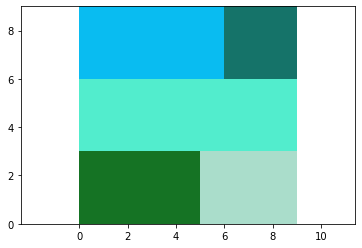

Solution: [[0, 3], [0, 6], [0, 0], [5, 0], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

4 : [[0, 0], [0, 3], [4, 6], [0, 6], [6, 3]] 
rotation: [1, 1, 1, 1, 0]


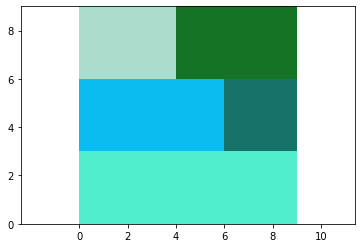

Solution: [[0, 0], [0, 3], [4, 6], [0, 6], [6, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

5 : [[0, 0], [0, 6], [4, 3], [0, 3], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


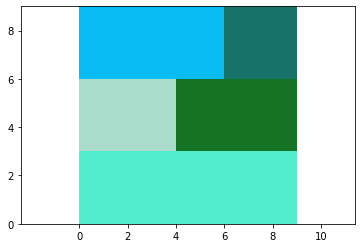

Solution: [[0, 0], [0, 6], [4, 3], [0, 3], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

6 : [[0, 3], [0, 0], [4, 6], [0, 6], [6, 0]] 
rotation: [1, 1, 1, 1, 0]


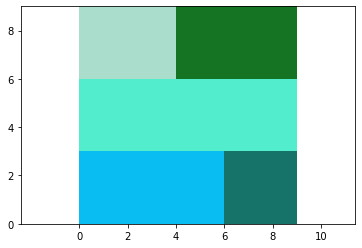

Solution: [[0, 3], [0, 0], [4, 6], [0, 6], [6, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

7 : [[0, 3], [0, 6], [4, 0], [0, 0], [6, 6]] 
rotation: [1, 1, 1, 1, 0]


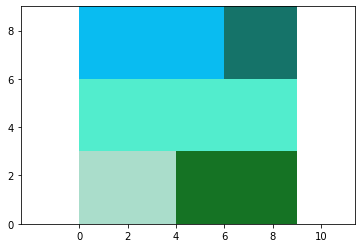

Solution: [[0, 3], [0, 6], [4, 0], [0, 0], [6, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

8 : [[0, 0], [3, 3], [0, 6], [5, 6], [0, 3]] 
rotation: [1, 1, 1, 1, 0]


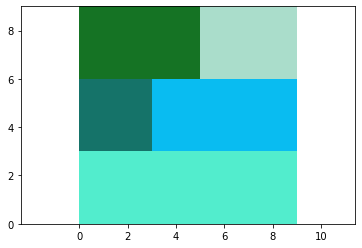

Solution: [[0, 0], [3, 3], [0, 6], [5, 6], [0, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

9 : [[0, 0], [3, 6], [0, 3], [5, 3], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


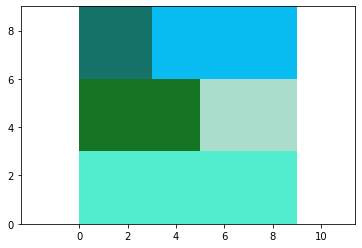

Solution: [[0, 0], [3, 6], [0, 3], [5, 3], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

10 : [[0, 3], [3, 0], [0, 6], [5, 6], [0, 0]] 
rotation: [1, 1, 1, 1, 0]


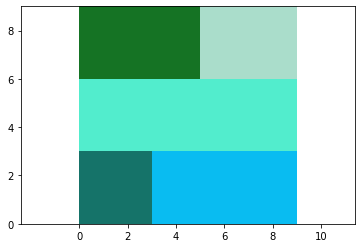

Solution: [[0, 3], [3, 0], [0, 6], [5, 6], [0, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

11 : [[0, 3], [3, 6], [0, 0], [5, 0], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


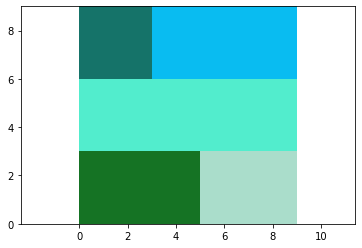

Solution: [[0, 3], [3, 6], [0, 0], [5, 0], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

12 : [[0, 0], [3, 6], [4, 3], [0, 3], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


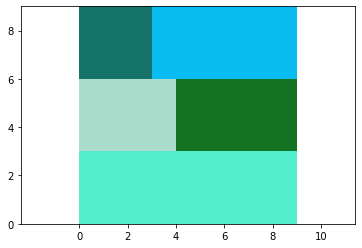

Solution: [[0, 0], [3, 6], [4, 3], [0, 3], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

13 : [[0, 0], [3, 3], [4, 6], [0, 6], [0, 3]] 
rotation: [1, 1, 1, 1, 0]


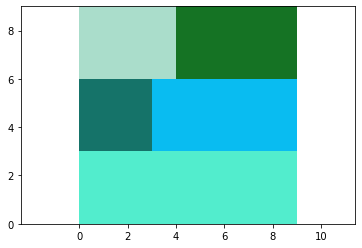

Solution: [[0, 0], [3, 3], [4, 6], [0, 6], [0, 3]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

14 : [[0, 3], [3, 6], [4, 0], [0, 0], [0, 6]] 
rotation: [1, 1, 1, 1, 0]


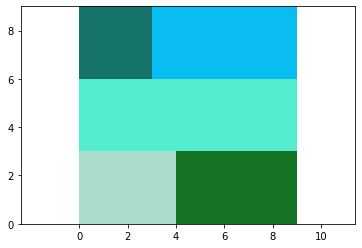

Solution: [[0, 3], [3, 6], [4, 0], [0, 0], [0, 6]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

15 : [[0, 3], [3, 0], [4, 6], [0, 6], [0, 0]] 
rotation: [1, 1, 1, 1, 0]


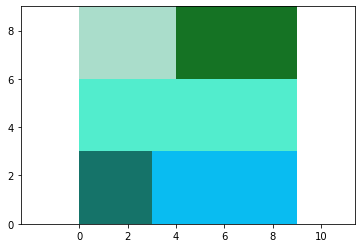

Solution: [[0, 3], [3, 0], [4, 6], [0, 6], [0, 0]]
[w, h]:   [[9, 3], [6, 3], [5, 3], [4, 3], [3, 3]]

16 : [[0, 0], [3, 3], [6, 4], [6, 0], [3, 0]] 
rotation: [0, 0, 0, 0, 0]


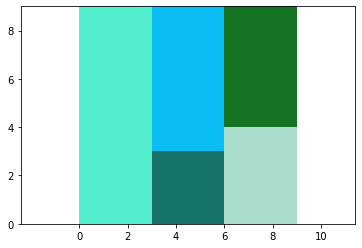

Solution: [[0, 0], [3, 3], [6, 4], [6, 0], [3, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

17 : [[0, 0], [3, 0], [6, 4], [6, 0], [3, 6]] 
rotation: [0, 0, 0, 0, 0]


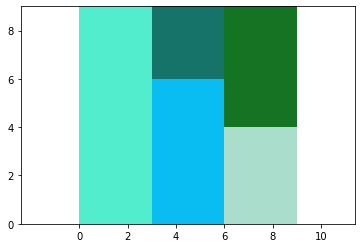

Solution: [[0, 0], [3, 0], [6, 4], [6, 0], [3, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

18 : [[0, 0], [3, 3], [6, 0], [6, 5], [3, 0]] 
rotation: [0, 0, 0, 0, 0]


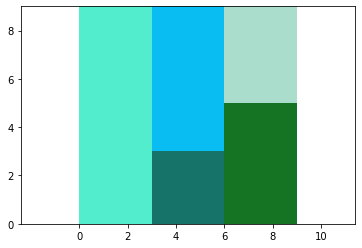

Solution: [[0, 0], [3, 3], [6, 0], [6, 5], [3, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

19 : [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]] 
rotation: [0, 0, 0, 0, 0]


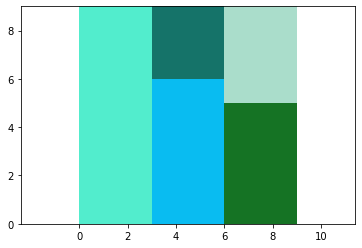

Solution: [[0, 0], [3, 0], [6, 0], [6, 5], [3, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

20 : [[0, 0], [6, 3], [3, 0], [3, 5], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


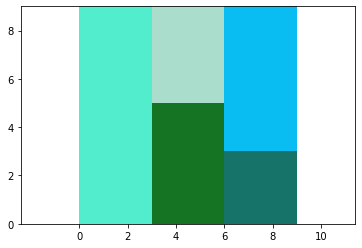

Solution: [[0, 0], [6, 3], [3, 0], [3, 5], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

21 : [[0, 0], [6, 3], [3, 4], [3, 0], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


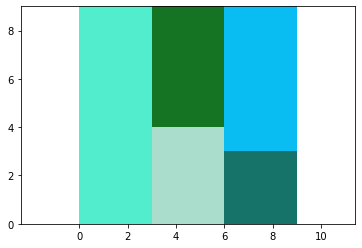

Solution: [[0, 0], [6, 3], [3, 4], [3, 0], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

22 : [[0, 0], [6, 0], [3, 0], [3, 5], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


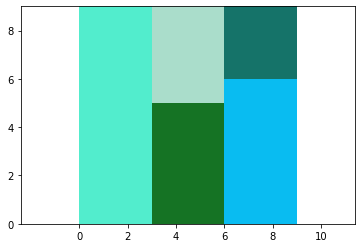

Solution: [[0, 0], [6, 0], [3, 0], [3, 5], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

23 : [[0, 0], [6, 0], [3, 4], [3, 0], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


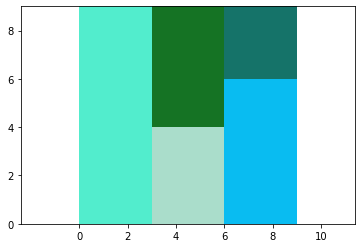

Solution: [[0, 0], [6, 0], [3, 4], [3, 0], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

24 : [[3, 0], [0, 3], [6, 4], [6, 0], [0, 0]] 
rotation: [0, 0, 0, 0, 0]


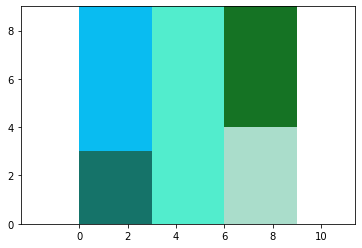

Solution: [[3, 0], [0, 3], [6, 4], [6, 0], [0, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

25 : [[3, 0], [0, 0], [6, 4], [6, 0], [0, 6]] 
rotation: [0, 0, 0, 0, 0]


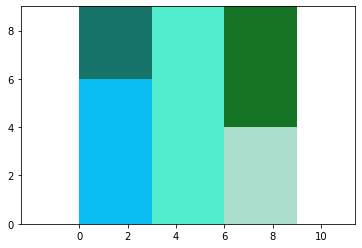

Solution: [[3, 0], [0, 0], [6, 4], [6, 0], [0, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

26 : [[3, 0], [0, 3], [6, 0], [6, 5], [0, 0]] 
rotation: [0, 0, 0, 0, 0]


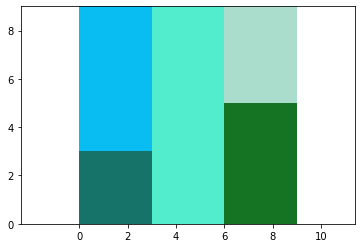

Solution: [[3, 0], [0, 3], [6, 0], [6, 5], [0, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

27 : [[3, 0], [0, 0], [6, 0], [6, 5], [0, 6]] 
rotation: [0, 0, 0, 0, 0]


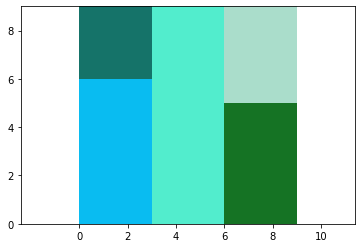

Solution: [[3, 0], [0, 0], [6, 0], [6, 5], [0, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

28 : [[3, 0], [6, 3], [0, 4], [0, 0], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


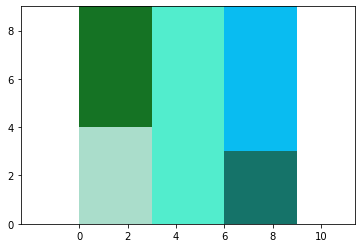

Solution: [[3, 0], [6, 3], [0, 4], [0, 0], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

29 : [[3, 0], [6, 0], [0, 4], [0, 0], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


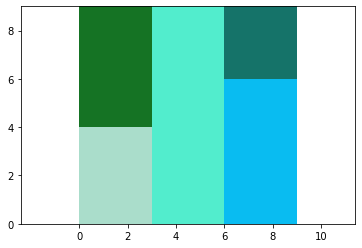

Solution: [[3, 0], [6, 0], [0, 4], [0, 0], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

30 : [[3, 0], [6, 3], [0, 0], [0, 5], [6, 0]] 
rotation: [0, 0, 0, 0, 0]


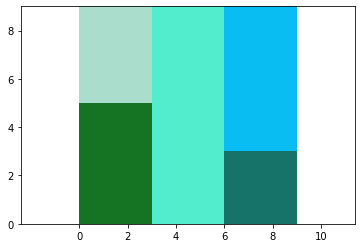

Solution: [[3, 0], [6, 3], [0, 0], [0, 5], [6, 0]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

31 : [[3, 0], [6, 0], [0, 0], [0, 5], [6, 6]] 
rotation: [0, 0, 0, 0, 0]


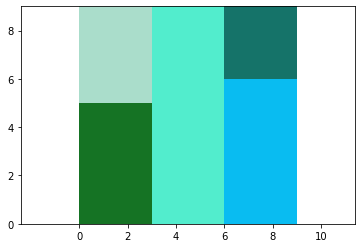

Solution: [[3, 0], [6, 0], [0, 0], [0, 5], [6, 6]]
[w, h]:   [[3, 9], [3, 6], [3, 5], [3, 4], [3, 3]]

Tot: 32



In [12]:
model_name = "pwp_v9-rot.mzn"
instance_name = "9x9"

path = f"Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/src/$model_name -t 300000

# Update L for each piece rotated

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
#save_solution("CP/out", pr_w, pr_h, n_pieces, L, solutions) #-uncomment this line to save the solution(with rotation)

SAME DIMENSION (point 6)

%%%mzn-stat: nSolutions=210
Solver output:
Generated FlatZinc statistics:
mzn-stat: paths=0
mzn-stat: flatBoolVars=113
mzn-stat: flatIntVars=32
mzn-stat: flatBoolConstraints=29
mzn-stat: flatIntConstraints=133
mzn-stat: evaluatedHalfReifiedConstraints=113
mzn-stat: method="satisfy"
mzn-stat: flatTime=0.169464
mzn-stat-end
mzn-stat: initTime=0.014
mzn-stat: solveTime=0.015
mzn-stat: solutions=210
mzn-stat: variables=149
mzn-stat: propagators=137
mzn-stat: propagations=35796
mzn-stat: nodes=699
mzn-stat: failures=140
mzn-stat: restarts=0
mzn-stat: peakDepth=14
mzn-stat-end
0 : [[0, 0], [0, 5], [0, 3], [6, 0], [0, 7], [4, 3], [6, 3], [6, 7]] 


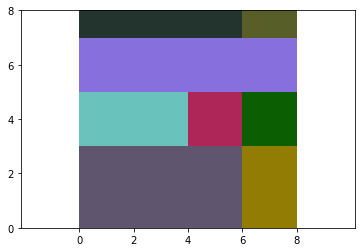

Solution: [[0, 0], [0, 5], [0, 3], [6, 0], [0, 7], [4, 3], [6, 3], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

1 : [[0, 0], [0, 5], [0, 3], [6, 2], [0, 7], [4, 3], [6, 0], [6, 7]] 


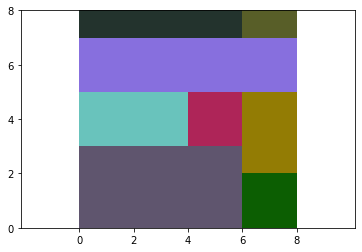

Solution: [[0, 0], [0, 5], [0, 3], [6, 2], [0, 7], [4, 3], [6, 0], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

2 : [[0, 0], [0, 6], [0, 3], [6, 0], [0, 5], [4, 3], [6, 3], [6, 5]] 


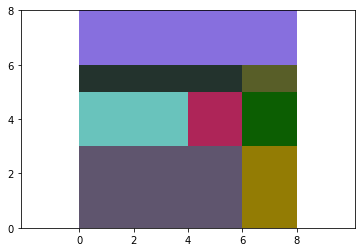

Solution: [[0, 0], [0, 6], [0, 3], [6, 0], [0, 5], [4, 3], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

3 : [[0, 0], [0, 6], [0, 3], [6, 0], [0, 5], [4, 3], [6, 4], [6, 3]] 


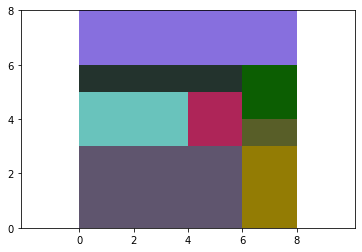

Solution: [[0, 0], [0, 6], [0, 3], [6, 0], [0, 5], [4, 3], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

4 : [[0, 0], [0, 6], [0, 3], [6, 1], [0, 5], [4, 3], [6, 4], [6, 0]] 


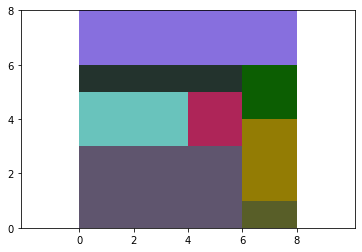

Solution: [[0, 0], [0, 6], [0, 3], [6, 1], [0, 5], [4, 3], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

5 : [[0, 0], [0, 6], [0, 3], [6, 2], [0, 5], [4, 3], [6, 0], [6, 5]] 


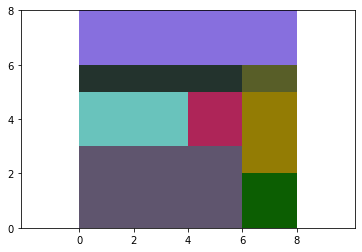

Solution: [[0, 0], [0, 6], [0, 3], [6, 2], [0, 5], [4, 3], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

6 : [[0, 0], [0, 6], [0, 3], [6, 3], [0, 5], [4, 3], [6, 0], [6, 2]] 


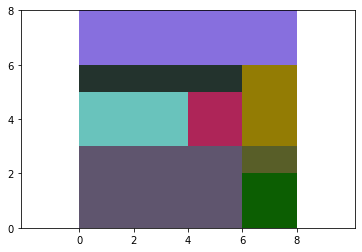

Solution: [[0, 0], [0, 6], [0, 3], [6, 3], [0, 5], [4, 3], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

7 : [[0, 0], [0, 6], [0, 3], [6, 3], [0, 5], [4, 3], [6, 1], [6, 0]] 


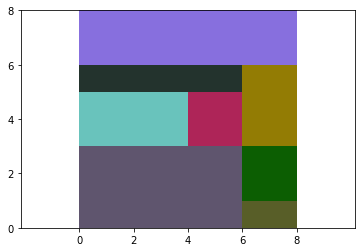

Solution: [[0, 0], [0, 6], [0, 3], [6, 3], [0, 5], [4, 3], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

8 : [[0, 0], [0, 6], [0, 4], [6, 0], [0, 3], [4, 4], [6, 4], [6, 3]] 


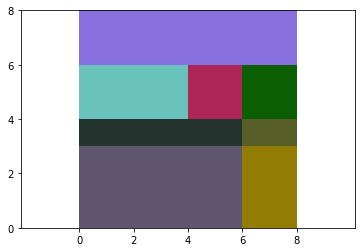

Solution: [[0, 0], [0, 6], [0, 4], [6, 0], [0, 3], [4, 4], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

9 : [[0, 0], [0, 6], [0, 4], [6, 0], [0, 3], [4, 4], [6, 3], [6, 5]] 


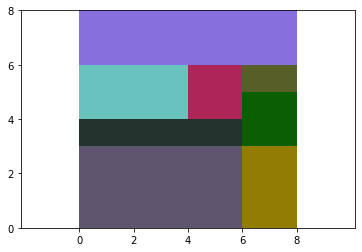

Solution: [[0, 0], [0, 6], [0, 4], [6, 0], [0, 3], [4, 4], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

10 : [[0, 0], [0, 6], [0, 4], [6, 1], [0, 3], [4, 4], [6, 4], [6, 0]] 


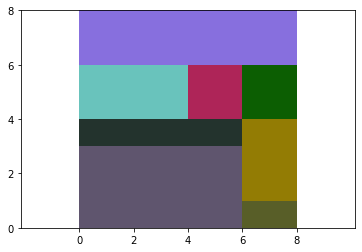

Solution: [[0, 0], [0, 6], [0, 4], [6, 1], [0, 3], [4, 4], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

11 : [[0, 0], [0, 6], [0, 4], [6, 2], [0, 3], [4, 4], [6, 0], [6, 5]] 


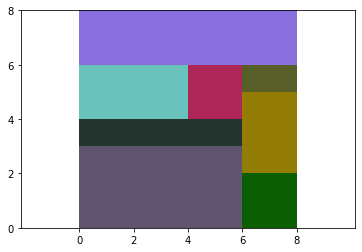

Solution: [[0, 0], [0, 6], [0, 4], [6, 2], [0, 3], [4, 4], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

12 : [[0, 0], [0, 6], [0, 4], [6, 3], [0, 3], [4, 4], [6, 0], [6, 2]] 


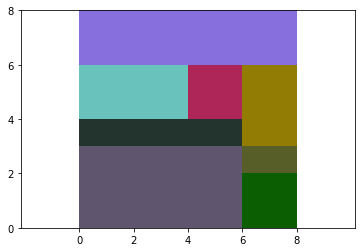

Solution: [[0, 0], [0, 6], [0, 4], [6, 3], [0, 3], [4, 4], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

13 : [[0, 0], [0, 6], [0, 4], [6, 3], [0, 3], [4, 4], [6, 1], [6, 0]] 


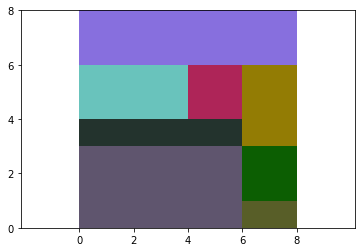

Solution: [[0, 0], [0, 6], [0, 4], [6, 3], [0, 3], [4, 4], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

14 : [[0, 0], [0, 3], [0, 5], [6, 0], [0, 7], [4, 5], [6, 5], [6, 7]] 


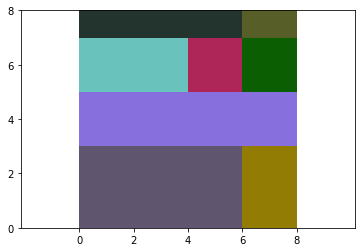

Solution: [[0, 0], [0, 3], [0, 5], [6, 0], [0, 7], [4, 5], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

15 : [[0, 0], [0, 3], [0, 5], [6, 0], [0, 7], [4, 5], [6, 6], [6, 5]] 


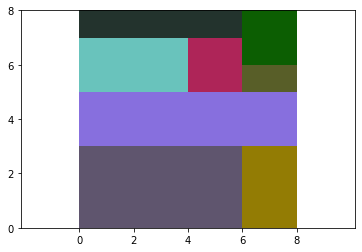

Solution: [[0, 0], [0, 3], [0, 5], [6, 0], [0, 7], [4, 5], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

16 : [[0, 0], [0, 3], [0, 5], [6, 5], [0, 7], [4, 5], [6, 0], [6, 2]] 


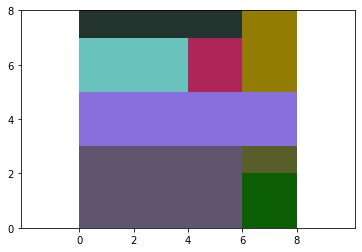

Solution: [[0, 0], [0, 3], [0, 5], [6, 5], [0, 7], [4, 5], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

17 : [[0, 0], [0, 3], [0, 5], [6, 5], [0, 7], [4, 5], [6, 1], [6, 0]] 


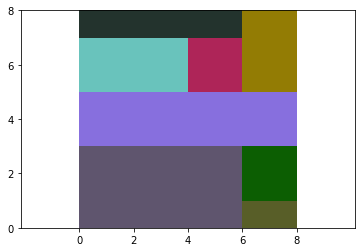

Solution: [[0, 0], [0, 3], [0, 5], [6, 5], [0, 7], [4, 5], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

18 : [[0, 0], [0, 3], [0, 6], [6, 0], [0, 5], [4, 6], [6, 6], [6, 5]] 


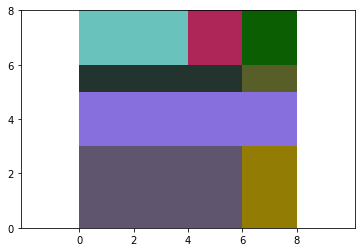

Solution: [[0, 0], [0, 3], [0, 6], [6, 0], [0, 5], [4, 6], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

19 : [[0, 0], [0, 3], [0, 6], [6, 0], [0, 5], [4, 6], [6, 5], [6, 7]] 


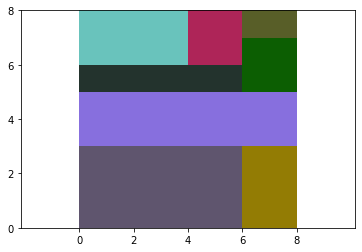

Solution: [[0, 0], [0, 3], [0, 6], [6, 0], [0, 5], [4, 6], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

20 : [[0, 0], [0, 3], [0, 6], [6, 5], [0, 5], [4, 6], [6, 0], [6, 2]] 


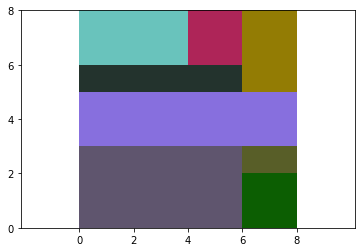

Solution: [[0, 0], [0, 3], [0, 6], [6, 5], [0, 5], [4, 6], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

21 : [[0, 0], [0, 3], [0, 6], [6, 5], [0, 5], [4, 6], [6, 1], [6, 0]] 


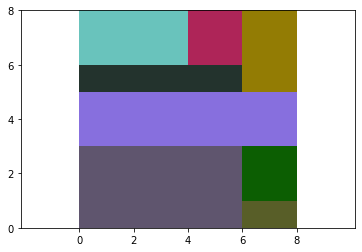

Solution: [[0, 0], [0, 3], [0, 6], [6, 5], [0, 5], [4, 6], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

22 : [[0, 0], [0, 4], [0, 6], [6, 0], [0, 3], [4, 6], [6, 6], [6, 3]] 


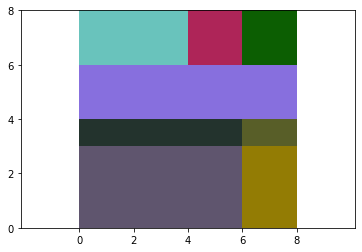

Solution: [[0, 0], [0, 4], [0, 6], [6, 0], [0, 3], [4, 6], [6, 6], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

23 : [[0, 0], [0, 4], [0, 6], [6, 1], [0, 3], [4, 6], [6, 6], [6, 0]] 


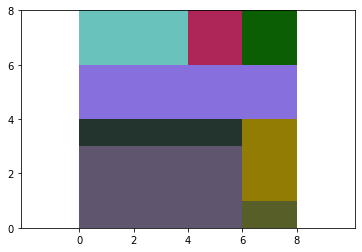

Solution: [[0, 0], [0, 4], [0, 6], [6, 1], [0, 3], [4, 6], [6, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

24 : [[0, 1], [0, 6], [0, 4], [6, 0], [0, 0], [4, 4], [6, 4], [6, 3]] 


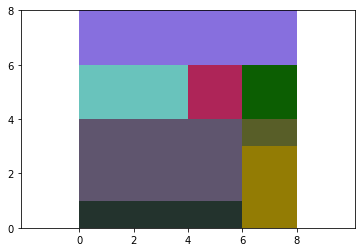

Solution: [[0, 1], [0, 6], [0, 4], [6, 0], [0, 0], [4, 4], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

25 : [[0, 1], [0, 6], [0, 4], [6, 0], [0, 0], [4, 4], [6, 3], [6, 5]] 


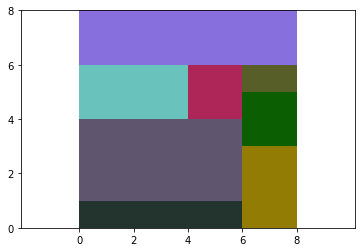

Solution: [[0, 1], [0, 6], [0, 4], [6, 0], [0, 0], [4, 4], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

26 : [[0, 1], [0, 6], [0, 4], [6, 1], [0, 0], [4, 4], [6, 4], [6, 0]] 


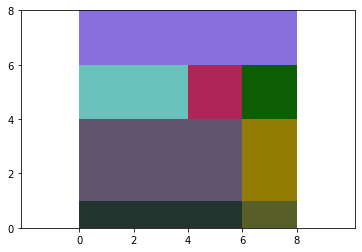

Solution: [[0, 1], [0, 6], [0, 4], [6, 1], [0, 0], [4, 4], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

27 : [[0, 1], [0, 6], [0, 4], [6, 2], [0, 0], [4, 4], [6, 0], [6, 5]] 


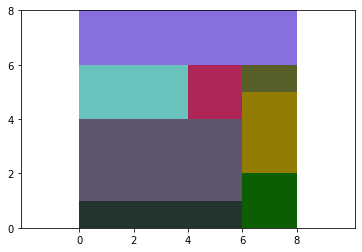

Solution: [[0, 1], [0, 6], [0, 4], [6, 2], [0, 0], [4, 4], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

28 : [[0, 1], [0, 6], [0, 4], [6, 3], [0, 0], [4, 4], [6, 0], [6, 2]] 


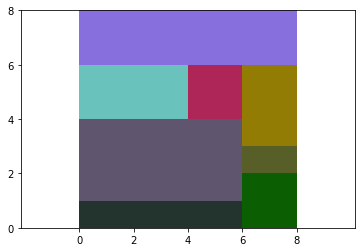

Solution: [[0, 1], [0, 6], [0, 4], [6, 3], [0, 0], [4, 4], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

29 : [[0, 1], [0, 6], [0, 4], [6, 3], [0, 0], [4, 4], [6, 1], [6, 0]] 


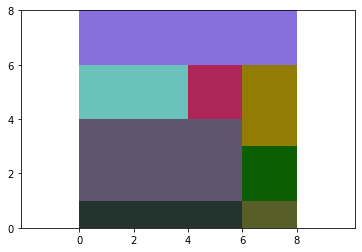

Solution: [[0, 1], [0, 6], [0, 4], [6, 3], [0, 0], [4, 4], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

30 : [[0, 1], [0, 4], [0, 6], [6, 0], [0, 0], [4, 6], [6, 6], [6, 3]] 


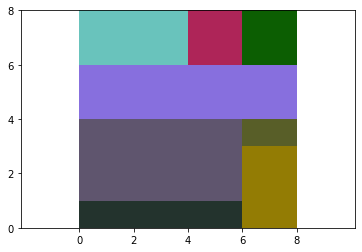

Solution: [[0, 1], [0, 4], [0, 6], [6, 0], [0, 0], [4, 6], [6, 6], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

31 : [[0, 1], [0, 4], [0, 6], [6, 1], [0, 0], [4, 6], [6, 6], [6, 0]] 


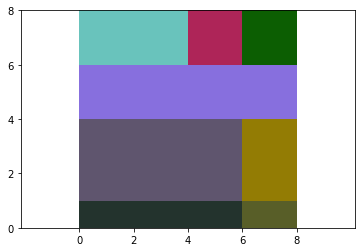

Solution: [[0, 1], [0, 4], [0, 6], [6, 1], [0, 0], [4, 6], [6, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

32 : [[0, 2], [0, 5], [0, 0], [6, 0], [0, 7], [4, 0], [6, 3], [6, 7]] 


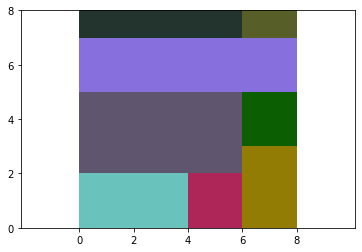

Solution: [[0, 2], [0, 5], [0, 0], [6, 0], [0, 7], [4, 0], [6, 3], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

33 : [[0, 2], [0, 5], [0, 0], [6, 2], [0, 7], [4, 0], [6, 0], [6, 7]] 


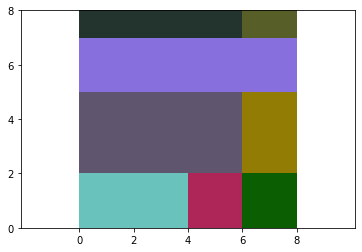

Solution: [[0, 2], [0, 5], [0, 0], [6, 2], [0, 7], [4, 0], [6, 0], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

34 : [[0, 2], [0, 6], [0, 0], [6, 0], [0, 5], [4, 0], [6, 3], [6, 5]] 


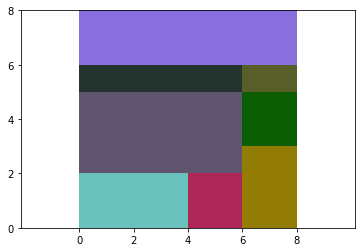

Solution: [[0, 2], [0, 6], [0, 0], [6, 0], [0, 5], [4, 0], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

35 : [[0, 2], [0, 6], [0, 0], [6, 0], [0, 5], [4, 0], [6, 4], [6, 3]] 


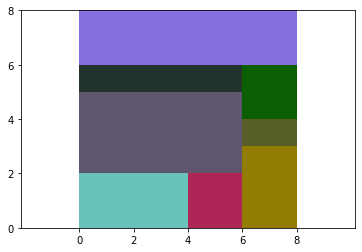

Solution: [[0, 2], [0, 6], [0, 0], [6, 0], [0, 5], [4, 0], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

36 : [[0, 2], [0, 6], [0, 0], [6, 1], [0, 5], [4, 0], [6, 4], [6, 0]] 


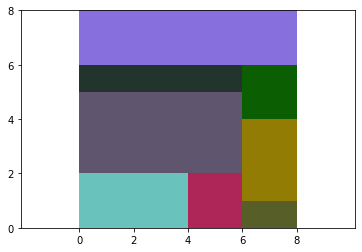

Solution: [[0, 2], [0, 6], [0, 0], [6, 1], [0, 5], [4, 0], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

37 : [[0, 2], [0, 6], [0, 0], [6, 2], [0, 5], [4, 0], [6, 0], [6, 5]] 


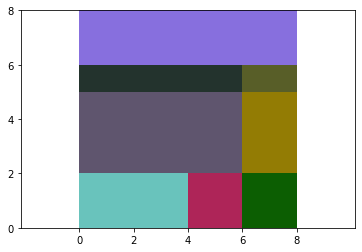

Solution: [[0, 2], [0, 6], [0, 0], [6, 2], [0, 5], [4, 0], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

38 : [[0, 2], [0, 6], [0, 0], [6, 3], [0, 5], [4, 0], [6, 0], [6, 2]] 


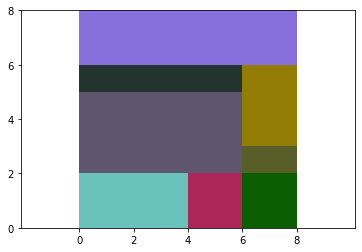

Solution: [[0, 2], [0, 6], [0, 0], [6, 3], [0, 5], [4, 0], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

39 : [[0, 2], [0, 6], [0, 0], [6, 3], [0, 5], [4, 0], [6, 1], [6, 0]] 


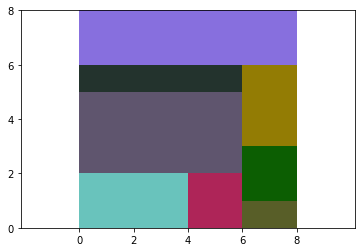

Solution: [[0, 2], [0, 6], [0, 0], [6, 3], [0, 5], [4, 0], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

40 : [[0, 2], [0, 0], [0, 5], [6, 2], [0, 7], [4, 5], [6, 5], [6, 7]] 


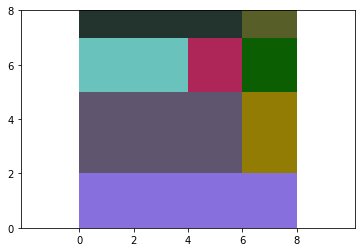

Solution: [[0, 2], [0, 0], [0, 5], [6, 2], [0, 7], [4, 5], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

41 : [[0, 2], [0, 0], [0, 5], [6, 2], [0, 7], [4, 5], [6, 6], [6, 5]] 


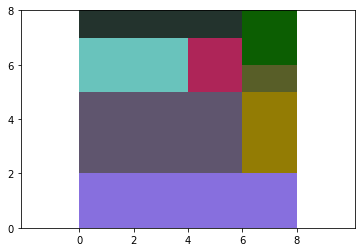

Solution: [[0, 2], [0, 0], [0, 5], [6, 2], [0, 7], [4, 5], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

42 : [[0, 2], [0, 0], [0, 5], [6, 3], [0, 7], [4, 5], [6, 6], [6, 2]] 


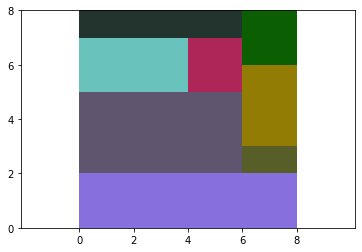

Solution: [[0, 2], [0, 0], [0, 5], [6, 3], [0, 7], [4, 5], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

43 : [[0, 2], [0, 0], [0, 5], [6, 4], [0, 7], [4, 5], [6, 2], [6, 7]] 


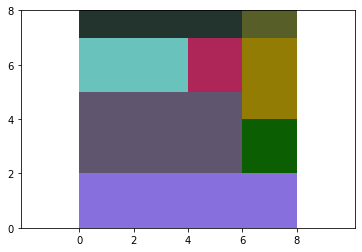

Solution: [[0, 2], [0, 0], [0, 5], [6, 4], [0, 7], [4, 5], [6, 2], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

44 : [[0, 2], [0, 0], [0, 5], [6, 5], [0, 7], [4, 5], [6, 2], [6, 4]] 


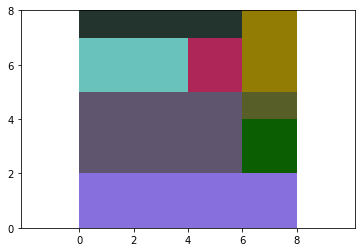

Solution: [[0, 2], [0, 0], [0, 5], [6, 5], [0, 7], [4, 5], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

45 : [[0, 2], [0, 0], [0, 5], [6, 5], [0, 7], [4, 5], [6, 3], [6, 2]] 


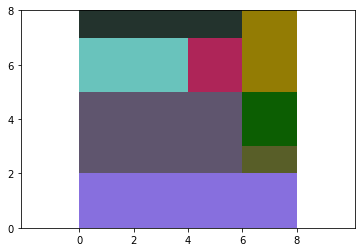

Solution: [[0, 2], [0, 0], [0, 5], [6, 5], [0, 7], [4, 5], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

46 : [[0, 2], [0, 0], [0, 6], [6, 2], [0, 5], [4, 6], [6, 6], [6, 5]] 


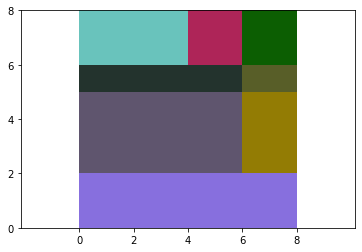

Solution: [[0, 2], [0, 0], [0, 6], [6, 2], [0, 5], [4, 6], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

47 : [[0, 2], [0, 0], [0, 6], [6, 2], [0, 5], [4, 6], [6, 5], [6, 7]] 


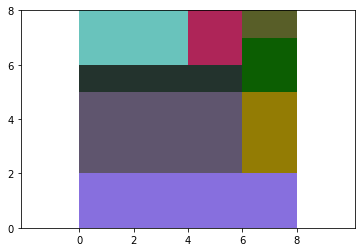

Solution: [[0, 2], [0, 0], [0, 6], [6, 2], [0, 5], [4, 6], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

48 : [[0, 2], [0, 0], [0, 6], [6, 3], [0, 5], [4, 6], [6, 6], [6, 2]] 


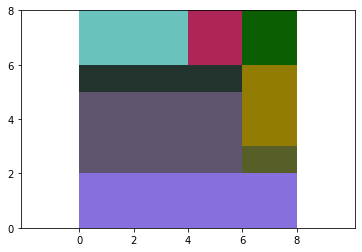

Solution: [[0, 2], [0, 0], [0, 6], [6, 3], [0, 5], [4, 6], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

49 : [[0, 2], [0, 0], [0, 6], [6, 4], [0, 5], [4, 6], [6, 2], [6, 7]] 


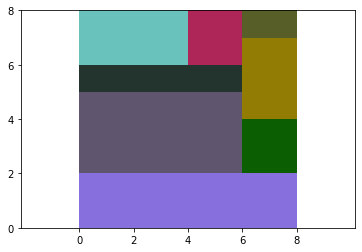

Solution: [[0, 2], [0, 0], [0, 6], [6, 4], [0, 5], [4, 6], [6, 2], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

50 : [[0, 2], [0, 0], [0, 6], [6, 5], [0, 5], [4, 6], [6, 2], [6, 4]] 


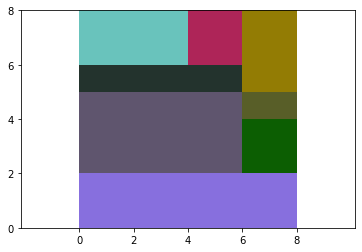

Solution: [[0, 2], [0, 0], [0, 6], [6, 5], [0, 5], [4, 6], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

51 : [[0, 2], [0, 0], [0, 6], [6, 5], [0, 5], [4, 6], [6, 3], [6, 2]] 


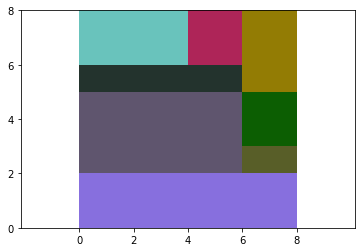

Solution: [[0, 2], [0, 0], [0, 6], [6, 5], [0, 5], [4, 6], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

52 : [[0, 0], [0, 5], [0, 3], [6, 0], [2, 7], [4, 3], [6, 3], [0, 7]] 


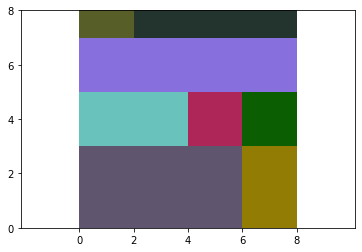

Solution: [[0, 0], [0, 5], [0, 3], [6, 0], [2, 7], [4, 3], [6, 3], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

53 : [[0, 0], [0, 5], [0, 3], [6, 2], [2, 7], [4, 3], [6, 0], [0, 7]] 


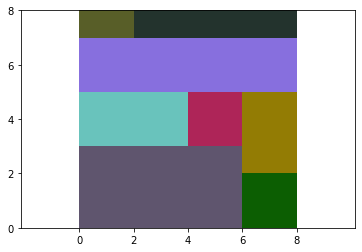

Solution: [[0, 0], [0, 5], [0, 3], [6, 2], [2, 7], [4, 3], [6, 0], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

54 : [[0, 0], [0, 6], [0, 3], [6, 0], [2, 5], [4, 3], [6, 3], [0, 5]] 


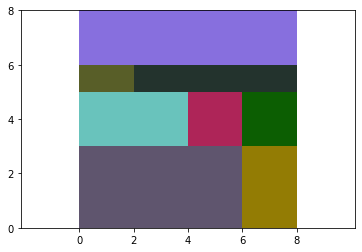

Solution: [[0, 0], [0, 6], [0, 3], [6, 0], [2, 5], [4, 3], [6, 3], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

55 : [[0, 0], [0, 6], [0, 3], [6, 2], [2, 5], [4, 3], [6, 0], [0, 5]] 


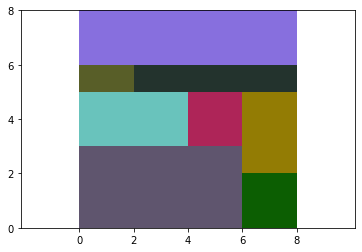

Solution: [[0, 0], [0, 6], [0, 3], [6, 2], [2, 5], [4, 3], [6, 0], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

56 : [[0, 0], [0, 6], [0, 4], [6, 0], [2, 3], [4, 4], [6, 4], [0, 3]] 


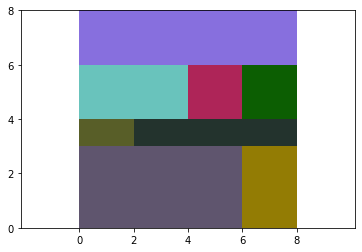

Solution: [[0, 0], [0, 6], [0, 4], [6, 0], [2, 3], [4, 4], [6, 4], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

57 : [[0, 0], [0, 3], [0, 6], [6, 0], [2, 5], [4, 6], [6, 6], [0, 5]] 


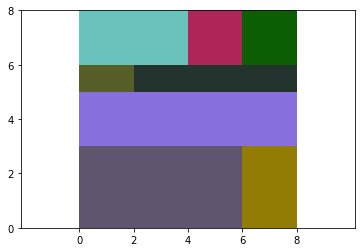

Solution: [[0, 0], [0, 3], [0, 6], [6, 0], [2, 5], [4, 6], [6, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

58 : [[0, 0], [0, 3], [0, 5], [6, 0], [2, 7], [4, 5], [6, 5], [0, 7]] 


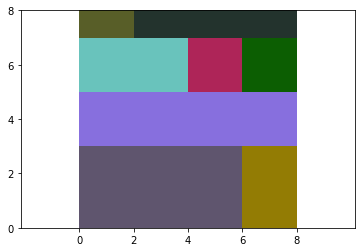

Solution: [[0, 0], [0, 3], [0, 5], [6, 0], [2, 7], [4, 5], [6, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

59 : [[0, 0], [0, 4], [0, 6], [6, 0], [2, 3], [4, 6], [6, 6], [0, 3]] 


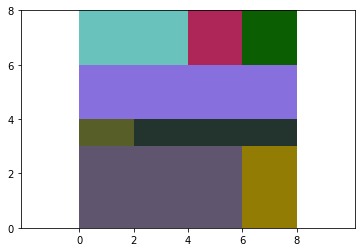

Solution: [[0, 0], [0, 4], [0, 6], [6, 0], [2, 3], [4, 6], [6, 6], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

60 : [[0, 1], [0, 6], [0, 4], [6, 1], [2, 0], [4, 4], [6, 4], [0, 0]] 


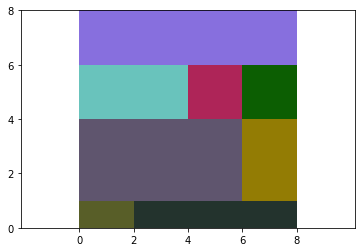

Solution: [[0, 1], [0, 6], [0, 4], [6, 1], [2, 0], [4, 4], [6, 4], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

61 : [[0, 1], [0, 6], [0, 4], [6, 3], [2, 0], [4, 4], [6, 1], [0, 0]] 


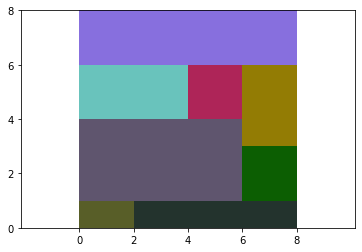

Solution: [[0, 1], [0, 6], [0, 4], [6, 3], [2, 0], [4, 4], [6, 1], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

62 : [[0, 1], [0, 4], [0, 6], [6, 1], [2, 0], [4, 6], [6, 6], [0, 0]] 


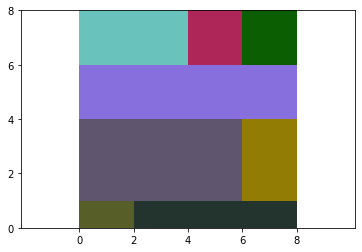

Solution: [[0, 1], [0, 4], [0, 6], [6, 1], [2, 0], [4, 6], [6, 6], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

63 : [[0, 2], [0, 5], [0, 0], [6, 0], [2, 7], [4, 0], [6, 3], [0, 7]] 


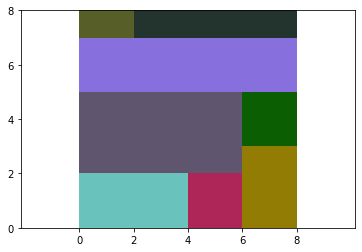

Solution: [[0, 2], [0, 5], [0, 0], [6, 0], [2, 7], [4, 0], [6, 3], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

64 : [[0, 2], [0, 5], [0, 0], [6, 2], [2, 7], [4, 0], [6, 0], [0, 7]] 


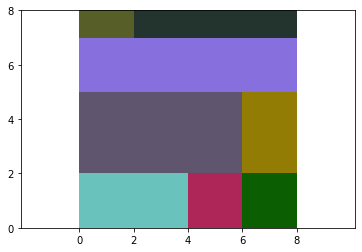

Solution: [[0, 2], [0, 5], [0, 0], [6, 2], [2, 7], [4, 0], [6, 0], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

65 : [[0, 2], [0, 6], [0, 0], [6, 0], [2, 5], [4, 0], [6, 3], [0, 5]] 


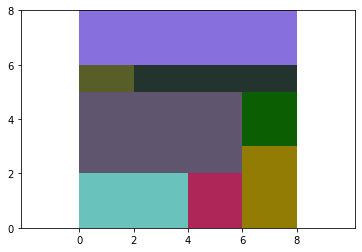

Solution: [[0, 2], [0, 6], [0, 0], [6, 0], [2, 5], [4, 0], [6, 3], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

66 : [[0, 2], [0, 6], [0, 0], [6, 2], [2, 5], [4, 0], [6, 0], [0, 5]] 


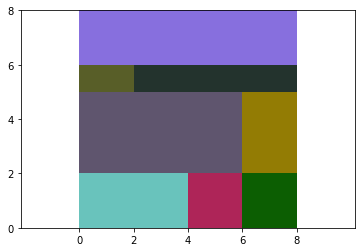

Solution: [[0, 2], [0, 6], [0, 0], [6, 2], [2, 5], [4, 0], [6, 0], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

67 : [[0, 2], [0, 0], [0, 5], [6, 2], [2, 7], [4, 5], [6, 5], [0, 7]] 


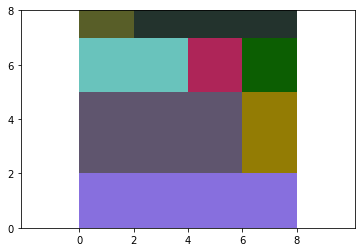

Solution: [[0, 2], [0, 0], [0, 5], [6, 2], [2, 7], [4, 5], [6, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

68 : [[0, 2], [0, 0], [0, 5], [6, 4], [2, 7], [4, 5], [6, 2], [0, 7]] 


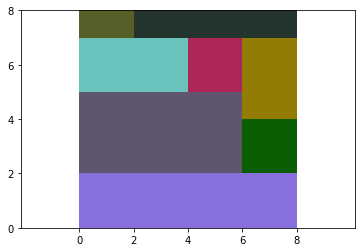

Solution: [[0, 2], [0, 0], [0, 5], [6, 4], [2, 7], [4, 5], [6, 2], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

69 : [[0, 2], [0, 0], [0, 6], [6, 2], [2, 5], [4, 6], [6, 6], [0, 5]] 


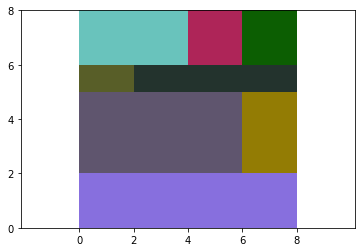

Solution: [[0, 2], [0, 0], [0, 6], [6, 2], [2, 5], [4, 6], [6, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

70 : [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 0], [6, 2], [6, 4]] 


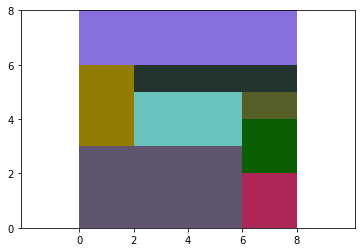

Solution: [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 0], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

71 : [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 0], [6, 3], [6, 2]] 


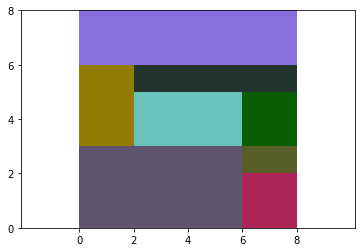

Solution: [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 0], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

72 : [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 1], [6, 3], [6, 0]] 


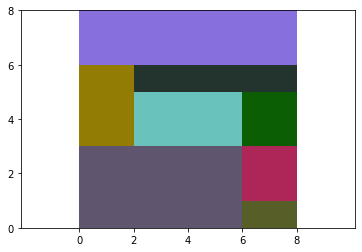

Solution: [[0, 0], [0, 6], [2, 3], [0, 3], [2, 5], [6, 1], [6, 3], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

73 : [[0, 0], [0, 6], [2, 4], [0, 3], [2, 3], [6, 0], [6, 4], [6, 2]] 


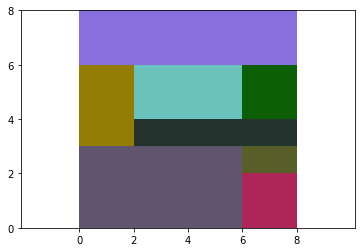

Solution: [[0, 0], [0, 6], [2, 4], [0, 3], [2, 3], [6, 0], [6, 4], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

74 : [[0, 0], [0, 6], [2, 4], [0, 3], [2, 3], [6, 1], [6, 4], [6, 0]] 


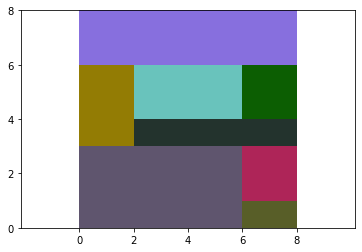

Solution: [[0, 0], [0, 6], [2, 4], [0, 3], [2, 3], [6, 1], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

75 : [[0, 0], [0, 3], [2, 5], [0, 5], [2, 7], [6, 0], [6, 5], [6, 2]] 


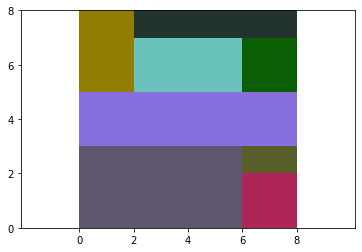

Solution: [[0, 0], [0, 3], [2, 5], [0, 5], [2, 7], [6, 0], [6, 5], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

76 : [[0, 0], [0, 3], [2, 5], [0, 5], [2, 7], [6, 1], [6, 5], [6, 0]] 


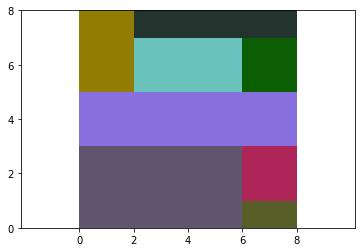

Solution: [[0, 0], [0, 3], [2, 5], [0, 5], [2, 7], [6, 1], [6, 5], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

77 : [[0, 0], [0, 3], [2, 6], [0, 5], [2, 5], [6, 0], [6, 6], [6, 2]] 


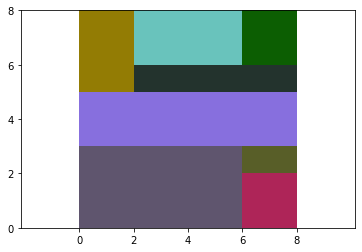

Solution: [[0, 0], [0, 3], [2, 6], [0, 5], [2, 5], [6, 0], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

78 : [[0, 0], [0, 3], [2, 6], [0, 5], [2, 5], [6, 1], [6, 6], [6, 0]] 


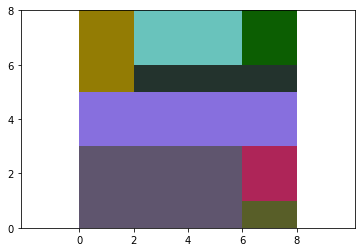

Solution: [[0, 0], [0, 3], [2, 6], [0, 5], [2, 5], [6, 1], [6, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

79 : [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 2], [6, 4], [6, 6]] 


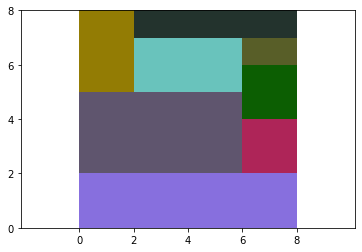

Solution: [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 2], [6, 4], [6, 6]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

80 : [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 2], [6, 5], [6, 4]] 


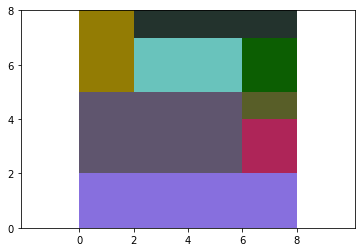

Solution: [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 2], [6, 5], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

81 : [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 3], [6, 5], [6, 2]] 


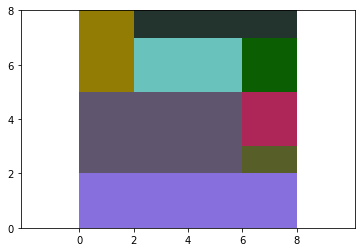

Solution: [[0, 2], [0, 0], [2, 5], [0, 5], [2, 7], [6, 3], [6, 5], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

82 : [[0, 2], [0, 0], [2, 6], [0, 5], [2, 5], [6, 2], [6, 6], [6, 4]] 


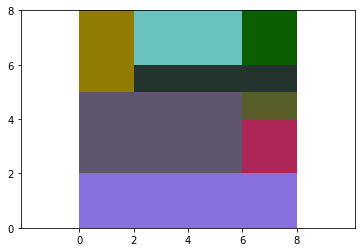

Solution: [[0, 2], [0, 0], [2, 6], [0, 5], [2, 5], [6, 2], [6, 6], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

83 : [[0, 2], [0, 0], [2, 6], [0, 5], [2, 5], [6, 3], [6, 6], [6, 2]] 


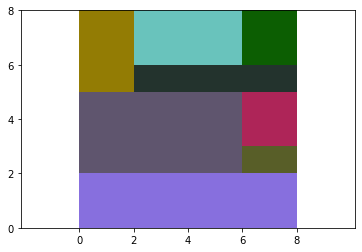

Solution: [[0, 2], [0, 0], [2, 6], [0, 5], [2, 5], [6, 3], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

84 : [[0, 0], [0, 5], [2, 3], [6, 2], [0, 7], [0, 3], [6, 0], [6, 7]] 


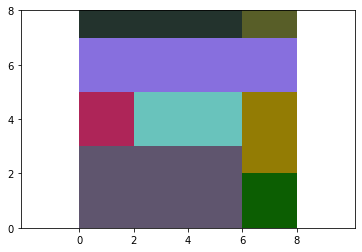

Solution: [[0, 0], [0, 5], [2, 3], [6, 2], [0, 7], [0, 3], [6, 0], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

85 : [[0, 0], [0, 6], [2, 3], [6, 3], [0, 5], [0, 3], [6, 0], [6, 2]] 


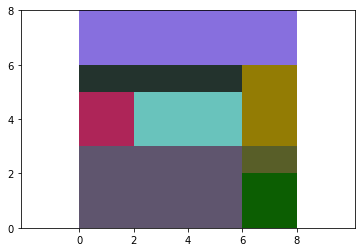

Solution: [[0, 0], [0, 6], [2, 3], [6, 3], [0, 5], [0, 3], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

86 : [[0, 0], [0, 6], [2, 3], [6, 2], [0, 5], [0, 3], [6, 0], [6, 5]] 


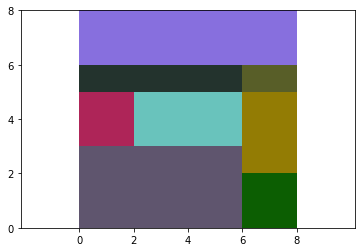

Solution: [[0, 0], [0, 6], [2, 3], [6, 2], [0, 5], [0, 3], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

87 : [[0, 0], [0, 6], [2, 3], [6, 3], [0, 5], [0, 3], [6, 1], [6, 0]] 


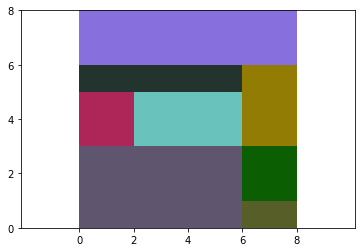

Solution: [[0, 0], [0, 6], [2, 3], [6, 3], [0, 5], [0, 3], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

88 : [[0, 0], [0, 5], [2, 3], [6, 0], [0, 7], [0, 3], [6, 3], [6, 7]] 


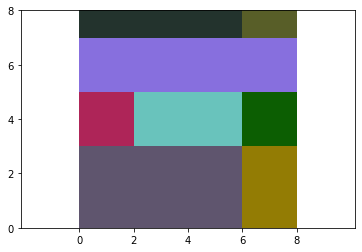

Solution: [[0, 0], [0, 5], [2, 3], [6, 0], [0, 7], [0, 3], [6, 3], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

89 : [[0, 0], [0, 6], [2, 3], [6, 0], [0, 5], [0, 3], [6, 3], [6, 5]] 


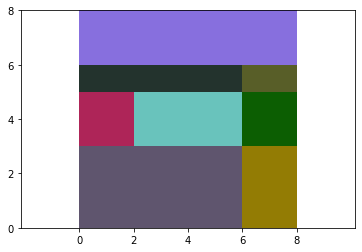

Solution: [[0, 0], [0, 6], [2, 3], [6, 0], [0, 5], [0, 3], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

90 : [[0, 0], [0, 6], [2, 3], [6, 0], [0, 5], [0, 3], [6, 4], [6, 3]] 


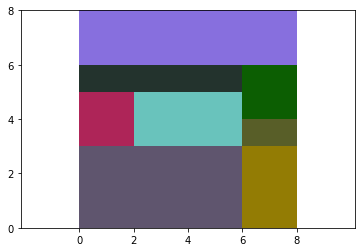

Solution: [[0, 0], [0, 6], [2, 3], [6, 0], [0, 5], [0, 3], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

91 : [[0, 0], [0, 6], [2, 3], [6, 1], [0, 5], [0, 3], [6, 4], [6, 0]] 


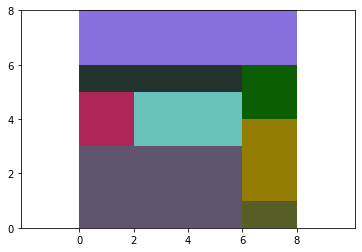

Solution: [[0, 0], [0, 6], [2, 3], [6, 1], [0, 5], [0, 3], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

92 : [[0, 0], [0, 6], [2, 4], [6, 3], [0, 3], [0, 4], [6, 0], [6, 2]] 


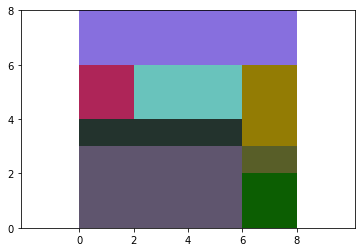

Solution: [[0, 0], [0, 6], [2, 4], [6, 3], [0, 3], [0, 4], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

93 : [[0, 0], [0, 6], [2, 4], [6, 2], [0, 3], [0, 4], [6, 0], [6, 5]] 


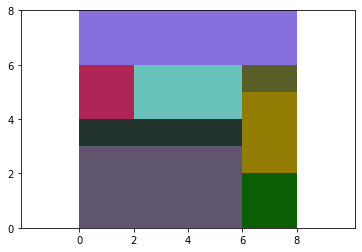

Solution: [[0, 0], [0, 6], [2, 4], [6, 2], [0, 3], [0, 4], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

94 : [[0, 0], [0, 6], [2, 4], [6, 3], [0, 3], [0, 4], [6, 1], [6, 0]] 


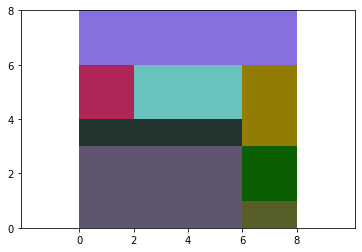

Solution: [[0, 0], [0, 6], [2, 4], [6, 3], [0, 3], [0, 4], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

95 : [[0, 0], [0, 6], [2, 4], [6, 0], [0, 3], [0, 4], [6, 4], [6, 3]] 


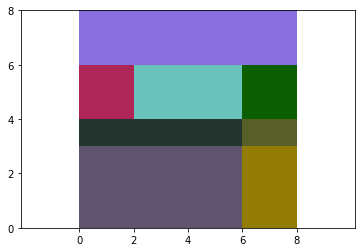

Solution: [[0, 0], [0, 6], [2, 4], [6, 0], [0, 3], [0, 4], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

96 : [[0, 0], [0, 6], [2, 4], [6, 0], [0, 3], [0, 4], [6, 3], [6, 5]] 


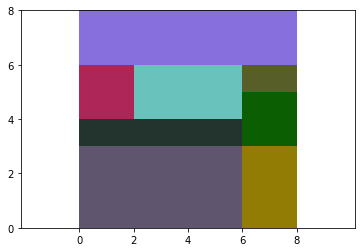

Solution: [[0, 0], [0, 6], [2, 4], [6, 0], [0, 3], [0, 4], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

97 : [[0, 0], [0, 6], [2, 4], [6, 1], [0, 3], [0, 4], [6, 4], [6, 0]] 


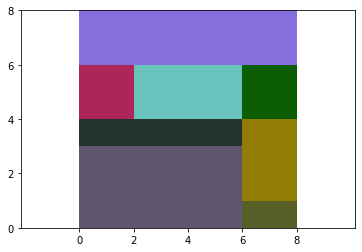

Solution: [[0, 0], [0, 6], [2, 4], [6, 1], [0, 3], [0, 4], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

98 : [[0, 0], [0, 3], [2, 5], [6, 5], [0, 7], [0, 5], [6, 0], [6, 2]] 


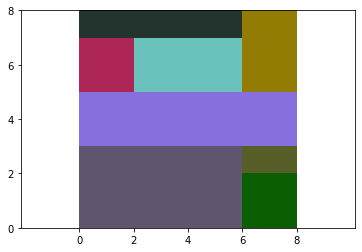

Solution: [[0, 0], [0, 3], [2, 5], [6, 5], [0, 7], [0, 5], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

99 : [[0, 0], [0, 3], [2, 5], [6, 5], [0, 7], [0, 5], [6, 1], [6, 0]] 


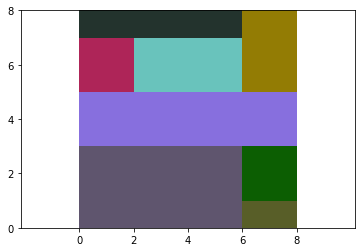

Solution: [[0, 0], [0, 3], [2, 5], [6, 5], [0, 7], [0, 5], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

 ... 
110 : [[0, 1], [0, 6], [2, 4], [6, 3], [0, 0], [0, 4], [6, 1], [6, 0]] 


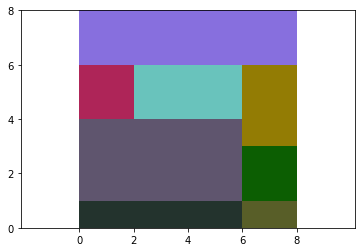

Solution: [[0, 1], [0, 6], [2, 4], [6, 3], [0, 0], [0, 4], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

111 : [[0, 1], [0, 6], [2, 4], [6, 0], [0, 0], [0, 4], [6, 3], [6, 5]] 


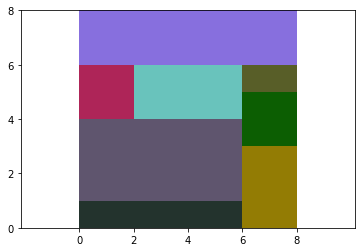

Solution: [[0, 1], [0, 6], [2, 4], [6, 0], [0, 0], [0, 4], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

112 : [[0, 1], [0, 6], [2, 4], [6, 0], [0, 0], [0, 4], [6, 4], [6, 3]] 


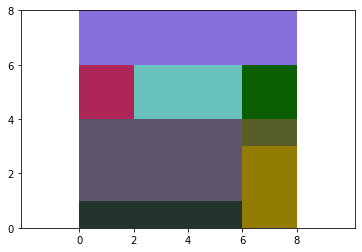

Solution: [[0, 1], [0, 6], [2, 4], [6, 0], [0, 0], [0, 4], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

113 : [[0, 1], [0, 6], [2, 4], [6, 1], [0, 0], [0, 4], [6, 4], [6, 0]] 


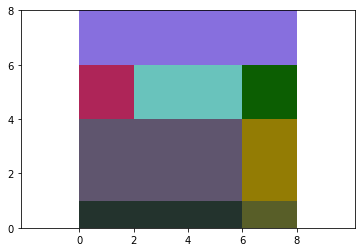

Solution: [[0, 1], [0, 6], [2, 4], [6, 1], [0, 0], [0, 4], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

114 : [[0, 1], [0, 4], [2, 6], [6, 0], [0, 0], [0, 6], [6, 6], [6, 3]] 


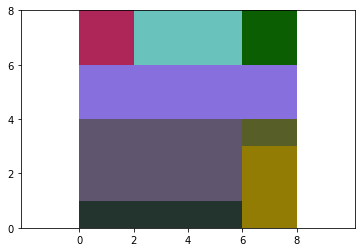

Solution: [[0, 1], [0, 4], [2, 6], [6, 0], [0, 0], [0, 6], [6, 6], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

115 : [[0, 1], [0, 4], [2, 6], [6, 1], [0, 0], [0, 6], [6, 6], [6, 0]] 


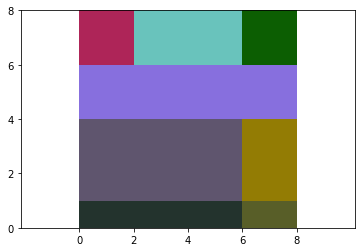

Solution: [[0, 1], [0, 4], [2, 6], [6, 1], [0, 0], [0, 6], [6, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

116 : [[0, 2], [0, 5], [2, 0], [6, 2], [0, 7], [0, 0], [6, 0], [6, 7]] 


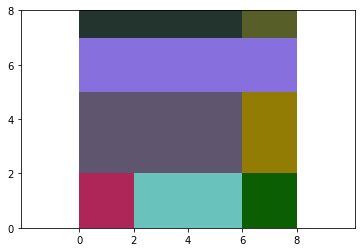

Solution: [[0, 2], [0, 5], [2, 0], [6, 2], [0, 7], [0, 0], [6, 0], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

117 : [[0, 2], [0, 6], [2, 0], [6, 2], [0, 5], [0, 0], [6, 0], [6, 5]] 


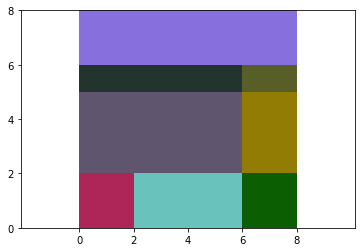

Solution: [[0, 2], [0, 6], [2, 0], [6, 2], [0, 5], [0, 0], [6, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

118 : [[0, 2], [0, 6], [2, 0], [6, 3], [0, 5], [0, 0], [6, 0], [6, 2]] 


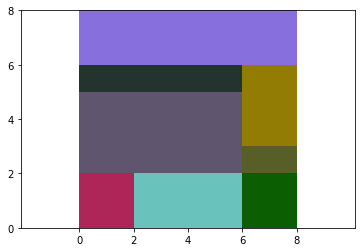

Solution: [[0, 2], [0, 6], [2, 0], [6, 3], [0, 5], [0, 0], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

119 : [[0, 2], [0, 6], [2, 0], [6, 3], [0, 5], [0, 0], [6, 1], [6, 0]] 


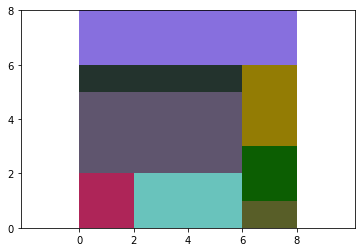

Solution: [[0, 2], [0, 6], [2, 0], [6, 3], [0, 5], [0, 0], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

120 : [[0, 2], [0, 0], [2, 5], [6, 5], [0, 7], [0, 5], [6, 2], [6, 4]] 


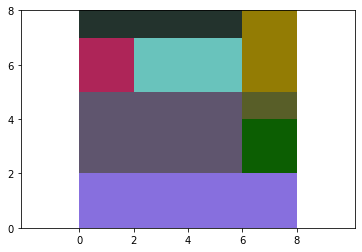

Solution: [[0, 2], [0, 0], [2, 5], [6, 5], [0, 7], [0, 5], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

121 : [[0, 2], [0, 0], [2, 5], [6, 4], [0, 7], [0, 5], [6, 2], [6, 7]] 


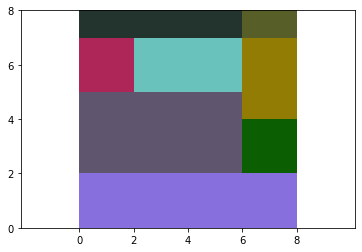

Solution: [[0, 2], [0, 0], [2, 5], [6, 4], [0, 7], [0, 5], [6, 2], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

122 : [[0, 2], [0, 0], [2, 6], [6, 5], [0, 5], [0, 6], [6, 2], [6, 4]] 


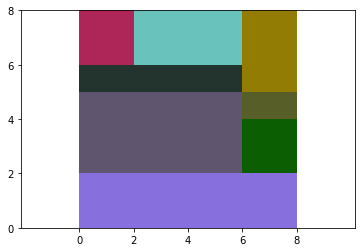

Solution: [[0, 2], [0, 0], [2, 6], [6, 5], [0, 5], [0, 6], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

123 : [[0, 2], [0, 0], [2, 6], [6, 4], [0, 5], [0, 6], [6, 2], [6, 7]] 


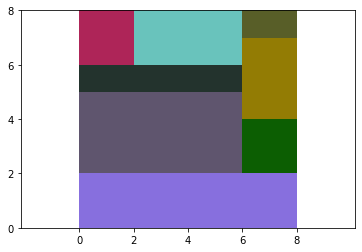

Solution: [[0, 2], [0, 0], [2, 6], [6, 4], [0, 5], [0, 6], [6, 2], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

124 : [[0, 2], [0, 5], [2, 0], [6, 0], [0, 7], [0, 0], [6, 3], [6, 7]] 


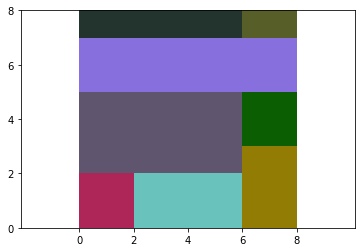

Solution: [[0, 2], [0, 5], [2, 0], [6, 0], [0, 7], [0, 0], [6, 3], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

125 : [[0, 2], [0, 6], [2, 0], [6, 0], [0, 5], [0, 0], [6, 3], [6, 5]] 


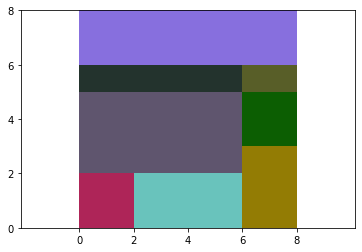

Solution: [[0, 2], [0, 6], [2, 0], [6, 0], [0, 5], [0, 0], [6, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

126 : [[0, 2], [0, 0], [2, 5], [6, 5], [0, 7], [0, 5], [6, 3], [6, 2]] 


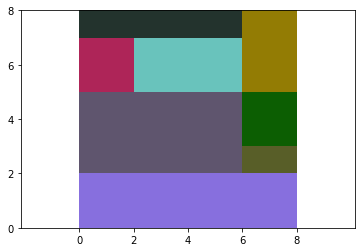

Solution: [[0, 2], [0, 0], [2, 5], [6, 5], [0, 7], [0, 5], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

127 : [[0, 2], [0, 0], [2, 6], [6, 5], [0, 5], [0, 6], [6, 3], [6, 2]] 


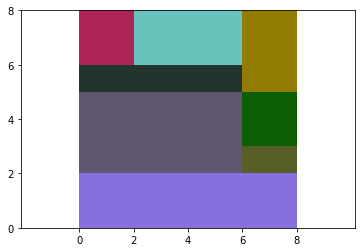

Solution: [[0, 2], [0, 0], [2, 6], [6, 5], [0, 5], [0, 6], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

128 : [[0, 2], [0, 6], [2, 0], [6, 0], [0, 5], [0, 0], [6, 4], [6, 3]] 


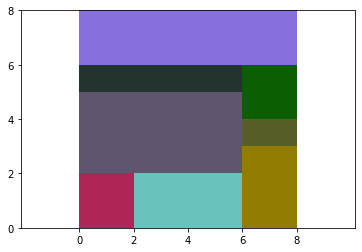

Solution: [[0, 2], [0, 6], [2, 0], [6, 0], [0, 5], [0, 0], [6, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

129 : [[0, 2], [0, 6], [2, 0], [6, 1], [0, 5], [0, 0], [6, 4], [6, 0]] 


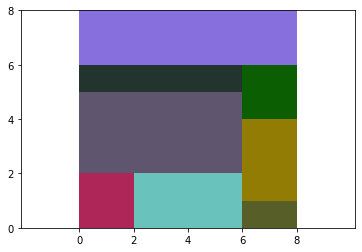

Solution: [[0, 2], [0, 6], [2, 0], [6, 1], [0, 5], [0, 0], [6, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

130 : [[0, 2], [0, 0], [2, 6], [6, 2], [0, 5], [0, 6], [6, 6], [6, 5]] 


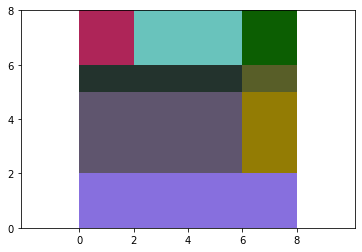

Solution: [[0, 2], [0, 0], [2, 6], [6, 2], [0, 5], [0, 6], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

131 : [[0, 2], [0, 0], [2, 5], [6, 2], [0, 7], [0, 5], [6, 6], [6, 5]] 


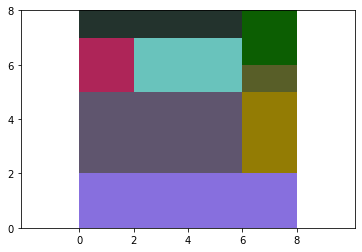

Solution: [[0, 2], [0, 0], [2, 5], [6, 2], [0, 7], [0, 5], [6, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

132 : [[0, 2], [0, 0], [2, 5], [6, 2], [0, 7], [0, 5], [6, 5], [6, 7]] 


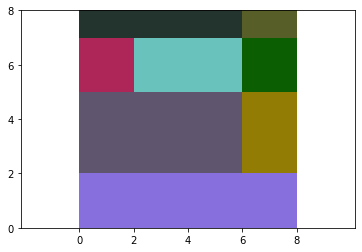

Solution: [[0, 2], [0, 0], [2, 5], [6, 2], [0, 7], [0, 5], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

133 : [[0, 2], [0, 0], [2, 6], [6, 2], [0, 5], [0, 6], [6, 5], [6, 7]] 


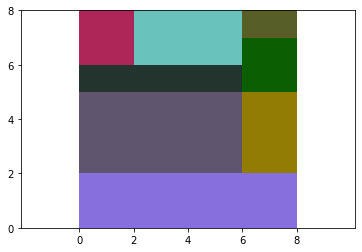

Solution: [[0, 2], [0, 0], [2, 6], [6, 2], [0, 5], [0, 6], [6, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

134 : [[0, 2], [0, 0], [2, 6], [6, 3], [0, 5], [0, 6], [6, 6], [6, 2]] 


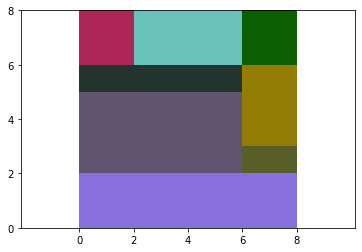

Solution: [[0, 2], [0, 0], [2, 6], [6, 3], [0, 5], [0, 6], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

135 : [[0, 2], [0, 0], [2, 5], [6, 3], [0, 7], [0, 5], [6, 6], [6, 2]] 


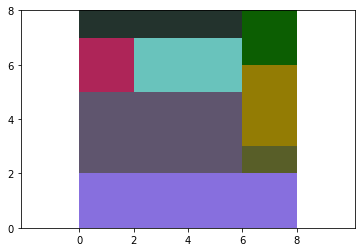

Solution: [[0, 2], [0, 0], [2, 5], [6, 3], [0, 7], [0, 5], [6, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

136 : [[0, 0], [0, 5], [2, 3], [6, 2], [2, 7], [0, 3], [6, 0], [0, 7]] 


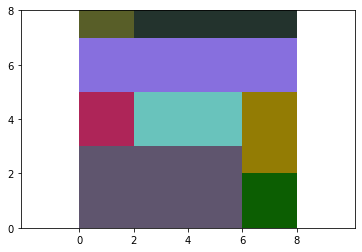

Solution: [[0, 0], [0, 5], [2, 3], [6, 2], [2, 7], [0, 3], [6, 0], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

137 : [[0, 0], [0, 6], [2, 3], [6, 2], [2, 5], [0, 3], [6, 0], [0, 5]] 


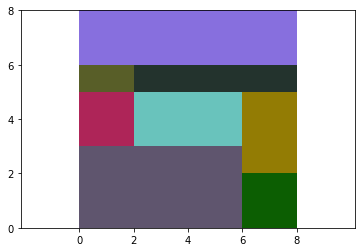

Solution: [[0, 0], [0, 6], [2, 3], [6, 2], [2, 5], [0, 3], [6, 0], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

138 : [[0, 0], [0, 5], [2, 3], [6, 0], [2, 7], [0, 3], [6, 3], [0, 7]] 


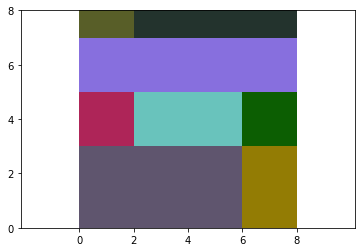

Solution: [[0, 0], [0, 5], [2, 3], [6, 0], [2, 7], [0, 3], [6, 3], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

139 : [[0, 0], [0, 6], [2, 3], [6, 0], [2, 5], [0, 3], [6, 3], [0, 5]] 


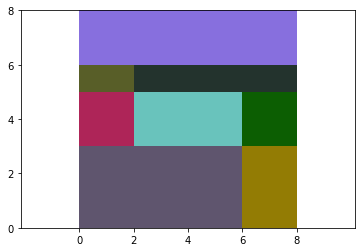

Solution: [[0, 0], [0, 6], [2, 3], [6, 0], [2, 5], [0, 3], [6, 3], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

140 : [[0, 0], [0, 6], [2, 4], [6, 0], [2, 3], [0, 3], [6, 4], [0, 5]] 


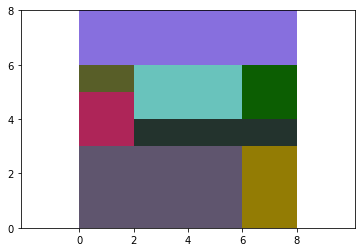

Solution: [[0, 0], [0, 6], [2, 4], [6, 0], [2, 3], [0, 3], [6, 4], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

141 : [[0, 0], [0, 6], [2, 3], [6, 2], [2, 5], [0, 4], [6, 0], [0, 3]] 


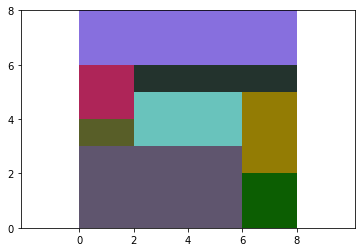

Solution: [[0, 0], [0, 6], [2, 3], [6, 2], [2, 5], [0, 4], [6, 0], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

142 : [[0, 0], [0, 6], [2, 4], [6, 0], [2, 3], [0, 4], [6, 4], [0, 3]] 


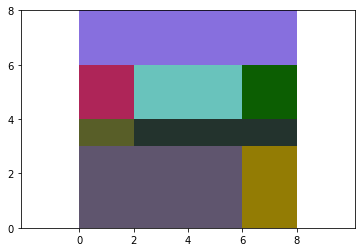

Solution: [[0, 0], [0, 6], [2, 4], [6, 0], [2, 3], [0, 4], [6, 4], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

143 : [[0, 0], [0, 6], [2, 3], [6, 0], [2, 5], [0, 4], [6, 3], [0, 3]] 


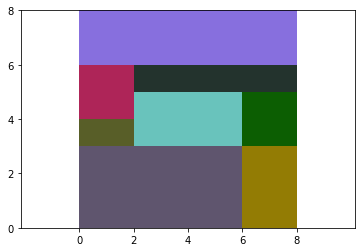

Solution: [[0, 0], [0, 6], [2, 3], [6, 0], [2, 5], [0, 4], [6, 3], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

144 : [[0, 0], [0, 3], [2, 5], [6, 0], [2, 7], [0, 5], [6, 5], [0, 7]] 


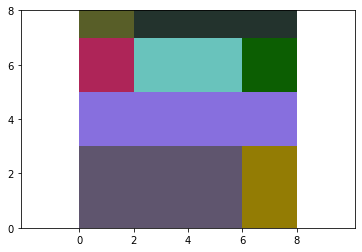

Solution: [[0, 0], [0, 3], [2, 5], [6, 0], [2, 7], [0, 5], [6, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

145 : [[0, 0], [0, 3], [2, 6], [6, 0], [2, 5], [0, 5], [6, 6], [0, 7]] 


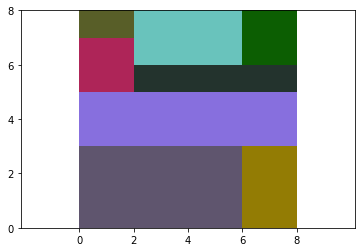

Solution: [[0, 0], [0, 3], [2, 6], [6, 0], [2, 5], [0, 5], [6, 6], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

146 : [[0, 0], [0, 3], [2, 6], [6, 0], [2, 5], [0, 6], [6, 6], [0, 5]] 


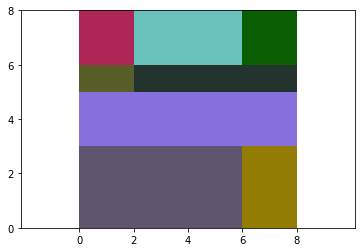

Solution: [[0, 0], [0, 3], [2, 6], [6, 0], [2, 5], [0, 6], [6, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

147 : [[0, 0], [0, 3], [2, 5], [6, 0], [2, 7], [0, 6], [6, 5], [0, 5]] 


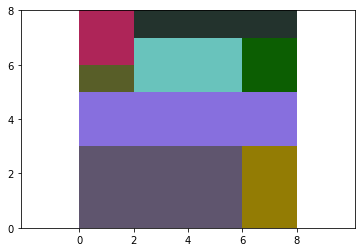

Solution: [[0, 0], [0, 3], [2, 5], [6, 0], [2, 7], [0, 6], [6, 5], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

148 : [[0, 0], [0, 4], [2, 6], [6, 0], [2, 3], [0, 6], [6, 6], [0, 3]] 


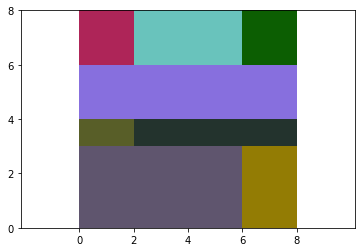

Solution: [[0, 0], [0, 4], [2, 6], [6, 0], [2, 3], [0, 6], [6, 6], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

149 : [[0, 1], [0, 6], [2, 4], [6, 3], [2, 0], [0, 4], [6, 1], [0, 0]] 


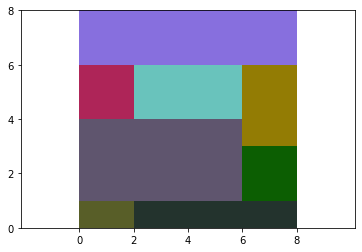

Solution: [[0, 1], [0, 6], [2, 4], [6, 3], [2, 0], [0, 4], [6, 1], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

150 : [[0, 1], [0, 6], [2, 4], [6, 1], [2, 0], [0, 4], [6, 4], [0, 0]] 


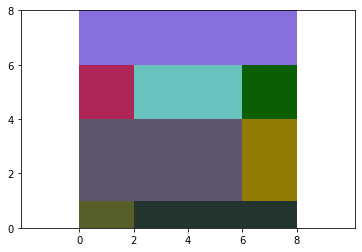

Solution: [[0, 1], [0, 6], [2, 4], [6, 1], [2, 0], [0, 4], [6, 4], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

151 : [[0, 1], [0, 4], [2, 6], [6, 1], [2, 0], [0, 6], [6, 6], [0, 0]] 


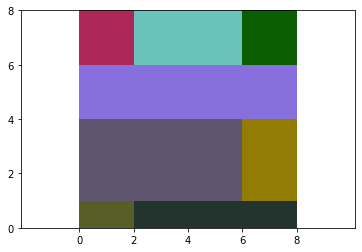

Solution: [[0, 1], [0, 4], [2, 6], [6, 1], [2, 0], [0, 6], [6, 6], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

152 : [[0, 2], [0, 5], [2, 0], [6, 2], [2, 7], [0, 0], [6, 0], [0, 7]] 


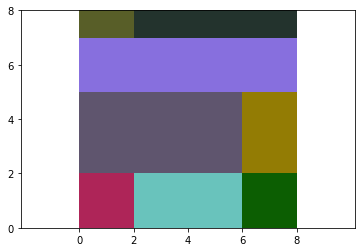

Solution: [[0, 2], [0, 5], [2, 0], [6, 2], [2, 7], [0, 0], [6, 0], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

153 : [[0, 2], [0, 6], [2, 0], [6, 2], [2, 5], [0, 0], [6, 0], [0, 5]] 


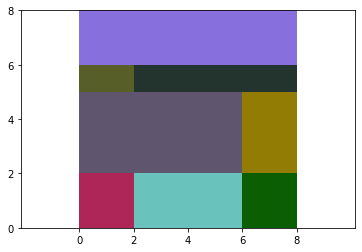

Solution: [[0, 2], [0, 6], [2, 0], [6, 2], [2, 5], [0, 0], [6, 0], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

154 : [[0, 2], [0, 0], [2, 5], [6, 4], [2, 7], [0, 5], [6, 2], [0, 7]] 


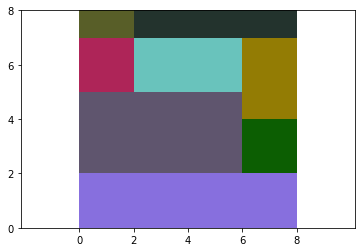

Solution: [[0, 2], [0, 0], [2, 5], [6, 4], [2, 7], [0, 5], [6, 2], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

155 : [[0, 2], [0, 0], [2, 5], [6, 4], [2, 7], [0, 6], [6, 2], [0, 5]] 


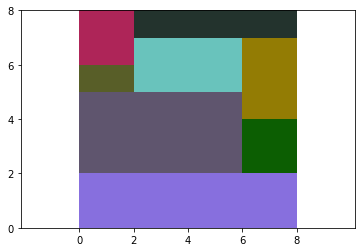

Solution: [[0, 2], [0, 0], [2, 5], [6, 4], [2, 7], [0, 6], [6, 2], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

156 : [[0, 2], [0, 5], [2, 0], [6, 0], [2, 7], [0, 0], [6, 3], [0, 7]] 


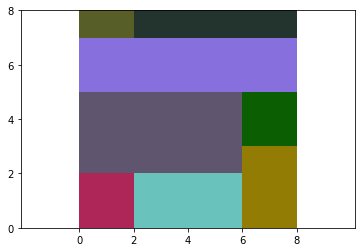

Solution: [[0, 2], [0, 5], [2, 0], [6, 0], [2, 7], [0, 0], [6, 3], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

157 : [[0, 2], [0, 6], [2, 0], [6, 0], [2, 5], [0, 0], [6, 3], [0, 5]] 


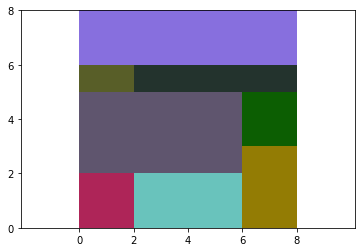

Solution: [[0, 2], [0, 6], [2, 0], [6, 0], [2, 5], [0, 0], [6, 3], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

158 : [[0, 2], [0, 0], [2, 5], [6, 2], [2, 7], [0, 5], [6, 5], [0, 7]] 


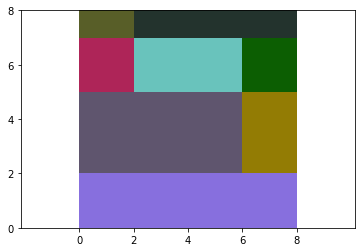

Solution: [[0, 2], [0, 0], [2, 5], [6, 2], [2, 7], [0, 5], [6, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

159 : [[0, 2], [0, 0], [2, 5], [6, 2], [2, 7], [0, 6], [6, 5], [0, 5]] 


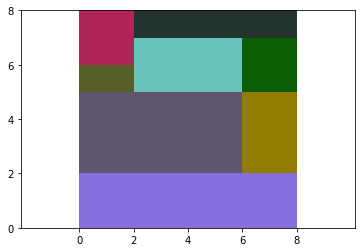

Solution: [[0, 2], [0, 0], [2, 5], [6, 2], [2, 7], [0, 6], [6, 5], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

160 : [[0, 2], [0, 0], [2, 6], [6, 2], [2, 5], [0, 6], [6, 6], [0, 5]] 


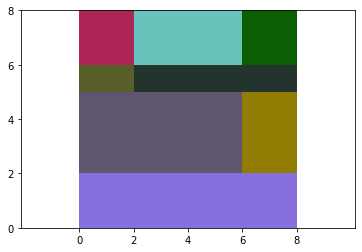

Solution: [[0, 2], [0, 0], [2, 6], [6, 2], [2, 5], [0, 6], [6, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

161 : [[0, 2], [0, 0], [2, 6], [6, 2], [2, 5], [0, 5], [6, 6], [0, 7]] 


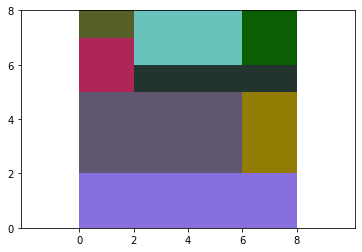

Solution: [[0, 2], [0, 0], [2, 6], [6, 2], [2, 5], [0, 5], [6, 6], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

162 : [[0, 0], [0, 6], [4, 3], [0, 3], [2, 5], [2, 3], [6, 0], [6, 2]] 


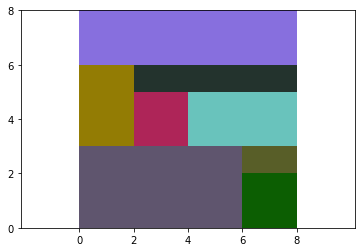

Solution: [[0, 0], [0, 6], [4, 3], [0, 3], [2, 5], [2, 3], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

163 : [[0, 0], [0, 6], [4, 3], [0, 3], [2, 5], [2, 3], [6, 1], [6, 0]] 


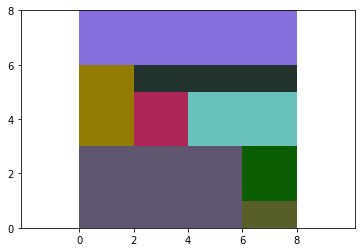

Solution: [[0, 0], [0, 6], [4, 3], [0, 3], [2, 5], [2, 3], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

164 : [[0, 0], [0, 6], [4, 4], [0, 3], [2, 3], [2, 4], [6, 0], [6, 2]] 


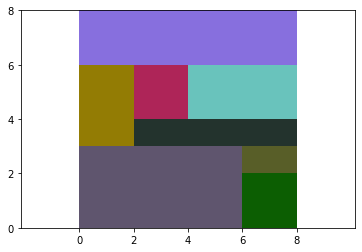

Solution: [[0, 0], [0, 6], [4, 4], [0, 3], [2, 3], [2, 4], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

165 : [[0, 0], [0, 6], [4, 4], [0, 3], [2, 3], [2, 4], [6, 1], [6, 0]] 


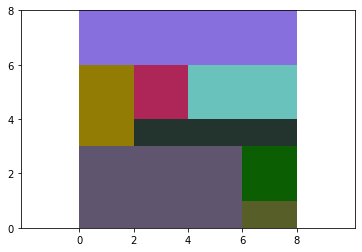

Solution: [[0, 0], [0, 6], [4, 4], [0, 3], [2, 3], [2, 4], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

166 : [[0, 0], [0, 3], [4, 5], [0, 5], [2, 7], [2, 5], [6, 0], [6, 2]] 


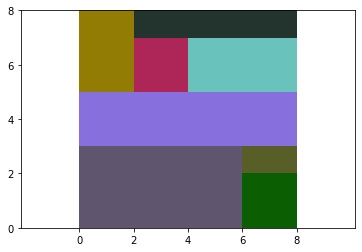

Solution: [[0, 0], [0, 3], [4, 5], [0, 5], [2, 7], [2, 5], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

167 : [[0, 0], [0, 3], [4, 5], [0, 5], [2, 7], [2, 5], [6, 1], [6, 0]] 


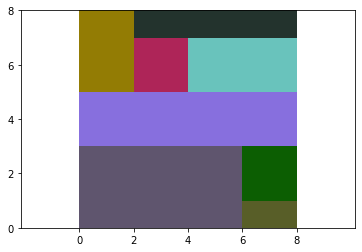

Solution: [[0, 0], [0, 3], [4, 5], [0, 5], [2, 7], [2, 5], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

168 : [[0, 0], [0, 3], [4, 6], [0, 5], [2, 5], [2, 6], [6, 0], [6, 2]] 


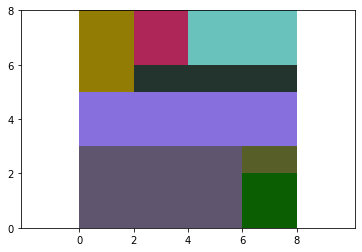

Solution: [[0, 0], [0, 3], [4, 6], [0, 5], [2, 5], [2, 6], [6, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

169 : [[0, 0], [0, 3], [4, 6], [0, 5], [2, 5], [2, 6], [6, 1], [6, 0]] 


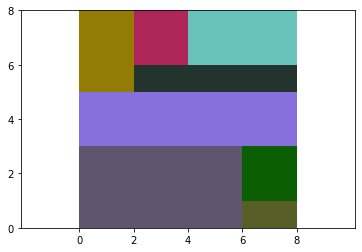

Solution: [[0, 0], [0, 3], [4, 6], [0, 5], [2, 5], [2, 6], [6, 1], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

170 : [[0, 2], [0, 0], [4, 5], [0, 5], [2, 7], [2, 5], [6, 2], [6, 4]] 


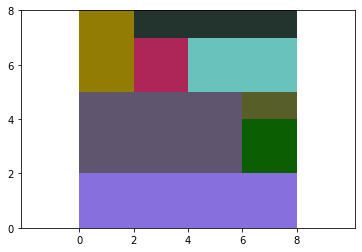

Solution: [[0, 2], [0, 0], [4, 5], [0, 5], [2, 7], [2, 5], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

171 : [[0, 2], [0, 0], [4, 5], [0, 5], [2, 7], [2, 5], [6, 3], [6, 2]] 


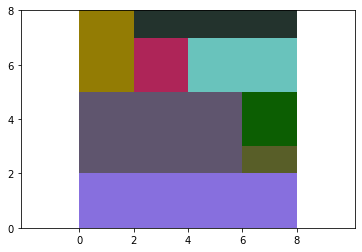

Solution: [[0, 2], [0, 0], [4, 5], [0, 5], [2, 7], [2, 5], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

172 : [[0, 2], [0, 0], [4, 6], [0, 5], [2, 5], [2, 6], [6, 2], [6, 4]] 


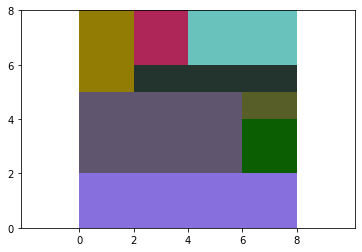

Solution: [[0, 2], [0, 0], [4, 6], [0, 5], [2, 5], [2, 6], [6, 2], [6, 4]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

173 : [[0, 2], [0, 0], [4, 6], [0, 5], [2, 5], [2, 6], [6, 3], [6, 2]] 


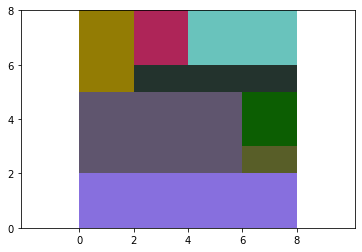

Solution: [[0, 2], [0, 0], [4, 6], [0, 5], [2, 5], [2, 6], [6, 3], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

174 : [[0, 0], [0, 5], [4, 3], [6, 0], [0, 7], [0, 3], [2, 3], [6, 7]] 


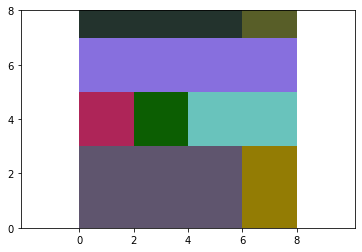

Solution: [[0, 0], [0, 5], [4, 3], [6, 0], [0, 7], [0, 3], [2, 3], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

175 : [[0, 0], [0, 6], [4, 3], [6, 0], [0, 5], [0, 3], [2, 3], [6, 5]] 


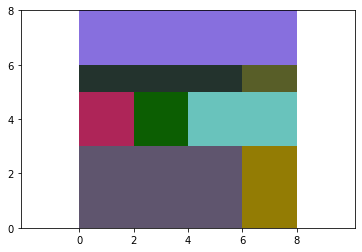

Solution: [[0, 0], [0, 6], [4, 3], [6, 0], [0, 5], [0, 3], [2, 3], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

176 : [[0, 0], [0, 6], [4, 4], [6, 0], [0, 3], [0, 4], [2, 4], [6, 3]] 


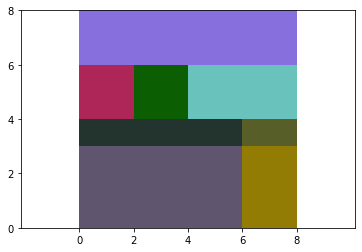

Solution: [[0, 0], [0, 6], [4, 4], [6, 0], [0, 3], [0, 4], [2, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

177 : [[0, 0], [0, 6], [4, 4], [6, 1], [0, 3], [0, 4], [2, 4], [6, 0]] 


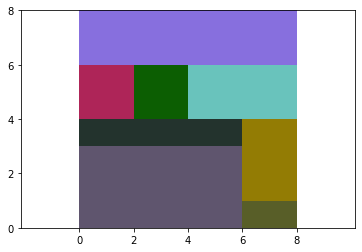

Solution: [[0, 0], [0, 6], [4, 4], [6, 1], [0, 3], [0, 4], [2, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

178 : [[0, 0], [0, 3], [4, 5], [6, 0], [0, 7], [0, 5], [2, 5], [6, 7]] 


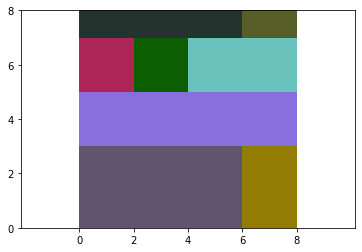

Solution: [[0, 0], [0, 3], [4, 5], [6, 0], [0, 7], [0, 5], [2, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

179 : [[0, 0], [0, 3], [4, 6], [6, 0], [0, 5], [0, 6], [2, 6], [6, 5]] 


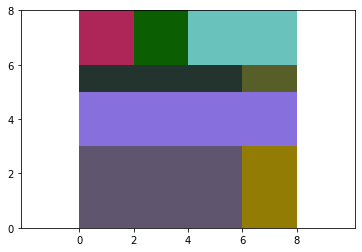

Solution: [[0, 0], [0, 3], [4, 6], [6, 0], [0, 5], [0, 6], [2, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

180 : [[0, 0], [0, 4], [4, 6], [6, 0], [0, 3], [0, 6], [2, 6], [6, 3]] 


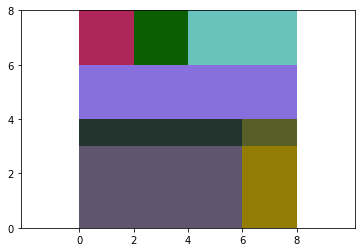

Solution: [[0, 0], [0, 4], [4, 6], [6, 0], [0, 3], [0, 6], [2, 6], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

181 : [[0, 0], [0, 4], [4, 6], [6, 1], [0, 3], [0, 6], [2, 6], [6, 0]] 


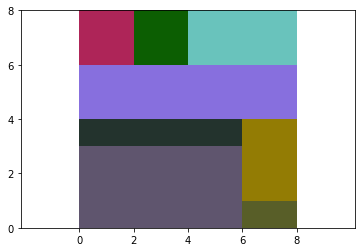

Solution: [[0, 0], [0, 4], [4, 6], [6, 1], [0, 3], [0, 6], [2, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

182 : [[0, 1], [0, 6], [4, 4], [6, 0], [0, 0], [0, 4], [2, 4], [6, 3]] 


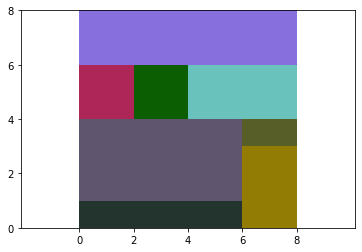

Solution: [[0, 1], [0, 6], [4, 4], [6, 0], [0, 0], [0, 4], [2, 4], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

183 : [[0, 1], [0, 6], [4, 4], [6, 1], [0, 0], [0, 4], [2, 4], [6, 0]] 


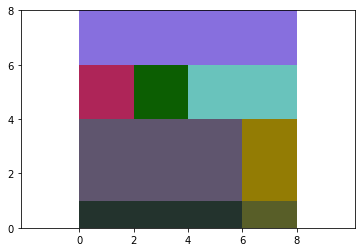

Solution: [[0, 1], [0, 6], [4, 4], [6, 1], [0, 0], [0, 4], [2, 4], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

184 : [[0, 1], [0, 4], [4, 6], [6, 0], [0, 0], [0, 6], [2, 6], [6, 3]] 


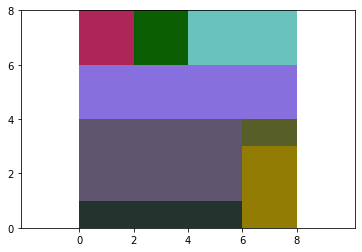

Solution: [[0, 1], [0, 4], [4, 6], [6, 0], [0, 0], [0, 6], [2, 6], [6, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

185 : [[0, 1], [0, 4], [4, 6], [6, 1], [0, 0], [0, 6], [2, 6], [6, 0]] 


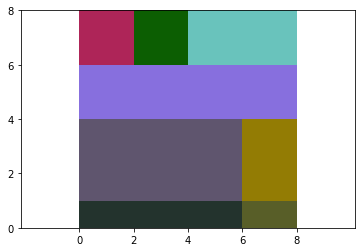

Solution: [[0, 1], [0, 4], [4, 6], [6, 1], [0, 0], [0, 6], [2, 6], [6, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

186 : [[0, 2], [0, 5], [4, 0], [6, 2], [0, 7], [0, 0], [2, 0], [6, 7]] 


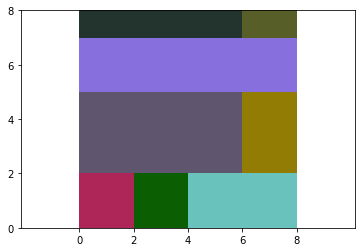

Solution: [[0, 2], [0, 5], [4, 0], [6, 2], [0, 7], [0, 0], [2, 0], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

187 : [[0, 2], [0, 6], [4, 0], [6, 2], [0, 5], [0, 0], [2, 0], [6, 5]] 


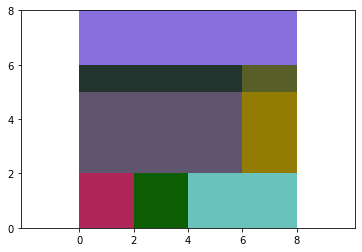

Solution: [[0, 2], [0, 6], [4, 0], [6, 2], [0, 5], [0, 0], [2, 0], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

188 : [[0, 2], [0, 6], [4, 0], [6, 3], [0, 5], [0, 0], [2, 0], [6, 2]] 


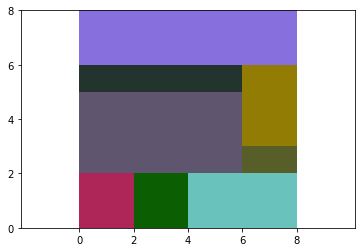

Solution: [[0, 2], [0, 6], [4, 0], [6, 3], [0, 5], [0, 0], [2, 0], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

189 : [[0, 2], [0, 0], [4, 5], [6, 2], [0, 7], [0, 5], [2, 5], [6, 7]] 


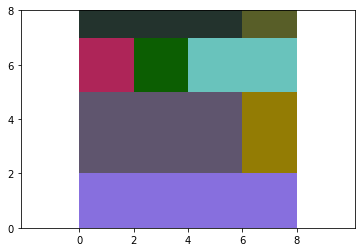

Solution: [[0, 2], [0, 0], [4, 5], [6, 2], [0, 7], [0, 5], [2, 5], [6, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

190 : [[0, 2], [0, 0], [4, 6], [6, 2], [0, 5], [0, 6], [2, 6], [6, 5]] 


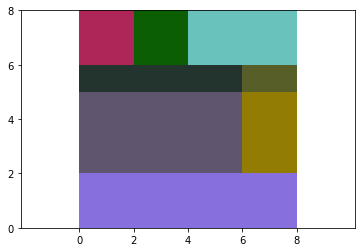

Solution: [[0, 2], [0, 0], [4, 6], [6, 2], [0, 5], [0, 6], [2, 6], [6, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

191 : [[0, 2], [0, 0], [4, 6], [6, 3], [0, 5], [0, 6], [2, 6], [6, 2]] 


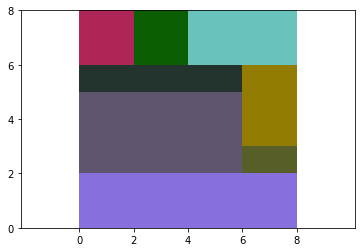

Solution: [[0, 2], [0, 0], [4, 6], [6, 3], [0, 5], [0, 6], [2, 6], [6, 2]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

192 : [[0, 0], [0, 5], [4, 3], [6, 0], [2, 7], [0, 3], [2, 3], [0, 7]] 


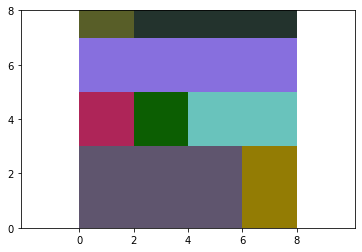

Solution: [[0, 0], [0, 5], [4, 3], [6, 0], [2, 7], [0, 3], [2, 3], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

193 : [[0, 0], [0, 6], [4, 3], [6, 0], [2, 5], [0, 3], [2, 3], [0, 5]] 


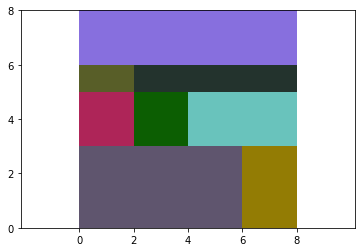

Solution: [[0, 0], [0, 6], [4, 3], [6, 0], [2, 5], [0, 3], [2, 3], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

194 : [[0, 0], [0, 6], [4, 3], [6, 0], [2, 5], [0, 4], [2, 3], [0, 3]] 


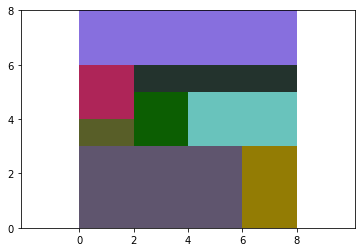

Solution: [[0, 0], [0, 6], [4, 3], [6, 0], [2, 5], [0, 4], [2, 3], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

195 : [[0, 0], [0, 6], [4, 4], [6, 0], [2, 3], [0, 4], [2, 4], [0, 3]] 


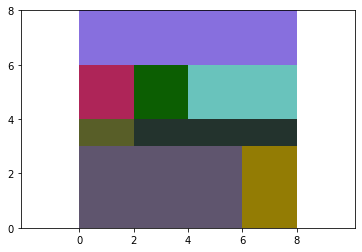

Solution: [[0, 0], [0, 6], [4, 4], [6, 0], [2, 3], [0, 4], [2, 4], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

196 : [[0, 0], [0, 6], [4, 4], [6, 0], [2, 3], [0, 3], [2, 4], [0, 5]] 


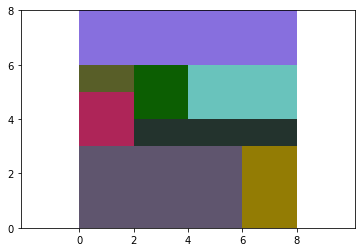

Solution: [[0, 0], [0, 6], [4, 4], [6, 0], [2, 3], [0, 3], [2, 4], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

197 : [[0, 0], [0, 3], [4, 5], [6, 0], [2, 7], [0, 5], [2, 5], [0, 7]] 


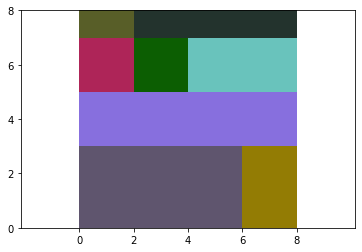

Solution: [[0, 0], [0, 3], [4, 5], [6, 0], [2, 7], [0, 5], [2, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

198 : [[0, 0], [0, 3], [4, 5], [6, 0], [2, 7], [0, 6], [2, 5], [0, 5]] 


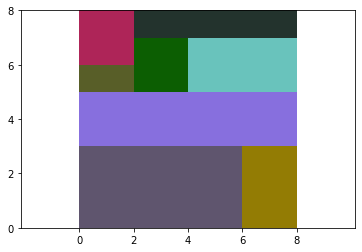

Solution: [[0, 0], [0, 3], [4, 5], [6, 0], [2, 7], [0, 6], [2, 5], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

199 : [[0, 0], [0, 3], [4, 6], [6, 0], [2, 5], [0, 6], [2, 6], [0, 5]] 


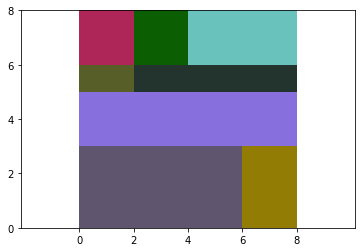

Solution: [[0, 0], [0, 3], [4, 6], [6, 0], [2, 5], [0, 6], [2, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

200 : [[0, 0], [0, 3], [4, 6], [6, 0], [2, 5], [0, 5], [2, 6], [0, 7]] 


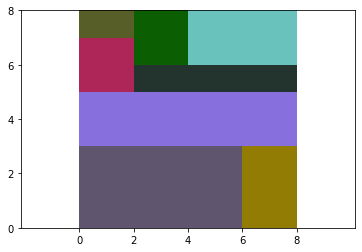

Solution: [[0, 0], [0, 3], [4, 6], [6, 0], [2, 5], [0, 5], [2, 6], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

201 : [[0, 0], [0, 4], [4, 6], [6, 0], [2, 3], [0, 6], [2, 6], [0, 3]] 


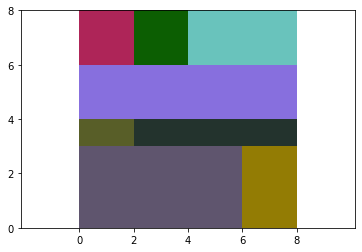

Solution: [[0, 0], [0, 4], [4, 6], [6, 0], [2, 3], [0, 6], [2, 6], [0, 3]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

202 : [[0, 1], [0, 6], [4, 4], [6, 1], [2, 0], [0, 4], [2, 4], [0, 0]] 


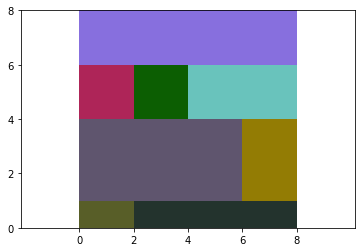

Solution: [[0, 1], [0, 6], [4, 4], [6, 1], [2, 0], [0, 4], [2, 4], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

203 : [[0, 1], [0, 4], [4, 6], [6, 1], [2, 0], [0, 6], [2, 6], [0, 0]] 


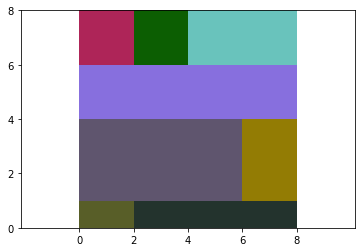

Solution: [[0, 1], [0, 4], [4, 6], [6, 1], [2, 0], [0, 6], [2, 6], [0, 0]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

204 : [[0, 2], [0, 5], [4, 0], [6, 2], [2, 7], [0, 0], [2, 0], [0, 7]] 


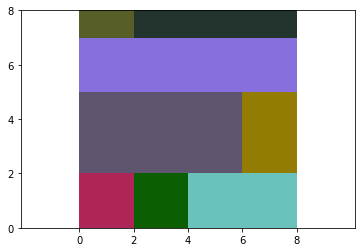

Solution: [[0, 2], [0, 5], [4, 0], [6, 2], [2, 7], [0, 0], [2, 0], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

205 : [[0, 2], [0, 6], [4, 0], [6, 2], [2, 5], [0, 0], [2, 0], [0, 5]] 


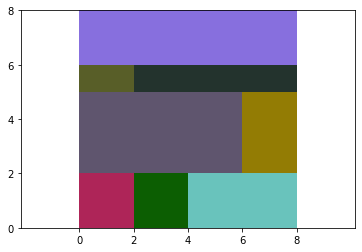

Solution: [[0, 2], [0, 6], [4, 0], [6, 2], [2, 5], [0, 0], [2, 0], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

206 : [[0, 2], [0, 0], [4, 5], [6, 2], [2, 7], [0, 5], [2, 5], [0, 7]] 


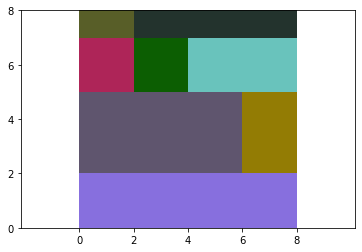

Solution: [[0, 2], [0, 0], [4, 5], [6, 2], [2, 7], [0, 5], [2, 5], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

207 : [[0, 2], [0, 0], [4, 5], [6, 2], [2, 7], [0, 6], [2, 5], [0, 5]] 


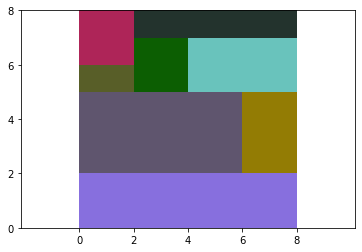

Solution: [[0, 2], [0, 0], [4, 5], [6, 2], [2, 7], [0, 6], [2, 5], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

208 : [[0, 2], [0, 0], [4, 6], [6, 2], [2, 5], [0, 6], [2, 6], [0, 5]] 


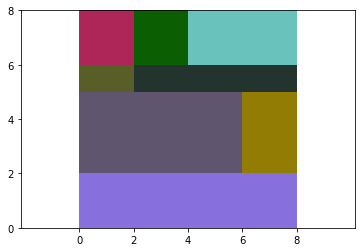

Solution: [[0, 2], [0, 0], [4, 6], [6, 2], [2, 5], [0, 6], [2, 6], [0, 5]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

209 : [[0, 2], [0, 0], [4, 6], [6, 2], [2, 5], [0, 5], [2, 6], [0, 7]] 


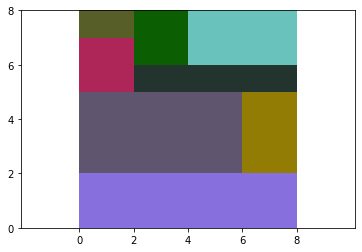

Solution: [[0, 2], [0, 0], [4, 6], [6, 2], [2, 5], [0, 5], [2, 6], [0, 7]]
[w, h]:   [[6, 3], [8, 2], [4, 2], [2, 3], [6, 1], [2, 2], [2, 2], [2, 1]]

Tot: 210



In [11]:
model_name = "pwp_v8-same-dim.mzn"
instance_name = "8x8-same-dim"
"""
Particular instance
8 8
8
2 1
2 2
2 2
2 3
4 2
6 1
6 3
8 2
"""
path = f"Instances/{instance_name}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
unordered_pieces = list(L)
decr_order = True

L = order_pieces(unordered_pieces, reverse=decr_order)

solutions = %minizinc -a -s CP/src/$model_name -t 300000

print_solutions(solutions, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

<b> <h2> SMT </h2> </b>

In [9]:
def create_model_old(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    domain = [And(0<=q[i][0],q[i][0]<=pr_w-L[i][0],0<=q[i][1],q[i][1]<= pr_h-L[i][1]) for i in range(n_pieces)]
    
    #--Symmetry breaking rules--
    #  Domain reduction
    areas = [L[i][0]*L[i][1] for i in range(n_pieces)]
    index_largest_p = areas.index(max(areas))
    domain_red = [And(q[index_largest_p][0]<=int((pr_w-L[index_largest_p][0])/2), q[index_largest_p][1]<=int((pr_h-L[index_largest_p][1])/2))]
    
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    #--Large Rectangles--And(Implies(pack, dep))
    large_rec_1 = [And(
            Implies(L[i][0]+L[j][0]>pr_w, And(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Not(l_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    large_rec_2 = [And(
            Implies(L[i][1]+L[j][1]>pr_h, And(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Not(u_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    l_val = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    u_val = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    e = Int('e')
    f = Int('f')

    e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]

    Px = [ Bool("px_%s" % (i)) for i in range(n_pieces) ]
    Py = [ Bool("py_%s" % (i)) for i in range(n_pieces) ]


    px_t = [And(Px[i]==(q[i][0]<=e),
               ) for i in range(n_pieces)]
    py_t = [And(Py[i]==(q[i][1]<=f),
               ) for i in range(n_pieces)]

    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(Px[i]), q[i][0]<=(e+1)
         )) for i in range(n_pieces)]
    o_e_py = [ And(
        Or(
            Not(Py[i]), q[i][1]<=(f+1)
         )) for i in range(n_pieces)]

    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    #;Non-Overlapping 2
    n_o_2_1 = [ And(
            Or(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Px[i], Not(q[j][0]<=(e+L[i][0])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    n_o_2_2 = [ And(
            Or(Not(l_i_j[j*(n_pieces-1)+i]), Px[j], Not(q[j][0]<=(e+L[j][0])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces)]

    n_o_2_3 = [ And(
            Or(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Py[i], Not(q[j][1]<=(f+L[i][1])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    n_o_2_4 = [ And(
            Or(Not(u_i_j[j*(n_pieces-1)+i]), Py[j], Not(q[i][1]<=(f+L[j][1])))
                ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    return q, domain + domain_red + large_rec_1 + large_rec_2 + l_val + u_val + e_dom + f_dom + px_t + py_t + n_o_1 
    #return q, domain + domain_red + large_rec_1 + large_rec_2 + l_val + u_val + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1 + n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4

In [5]:
def is_active(i, h, P, xy):  #xy:  0-x dimension  1-y dimension
    if h - L[i][xy] < 0:
        return False
    return P[i][h - L[i][xy]]

def create_model(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    domain = [And(0<=q[i][0],q[i][0]<=pr_w-L[i][0],0<=q[i][1],q[i][1]<= pr_h-L[i][1]) for i in range(n_pieces)]
    
    #ddd = [And(q[0][0]==0, q[1][0]==0, q[2][0]==3,q[3][0]==3)]
    #--Symmetry breaking rules--
    #  Domain reduction
    areas = [L[i][0]*L[i][1] for i in range(n_pieces)]
    index_largest_p = areas.index(max(areas))
    domain_red = [And(q[index_largest_p][0]<=int((pr_w-L[index_largest_p][0])/2), q[index_largest_p][1]<=int((pr_h-L[index_largest_p][1])/2))]
    
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    
    #--Large Rectangles--And(Implies(pack, dep))
    large_rec_1 = [And(
            Implies(L[i][0]+L[j][0]>pr_w, And(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Not(l_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    large_rec_2 = [And(
            Implies(L[i][1]+L[j][1]>pr_h, And(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Not(u_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    l_val = [(q[i][0]+L[i][0]<=q[j][0])==l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]
             for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    indep = independent_solving_on_w(L)
    indep_cons = []
    if indep:
        print("YES independent solving on w: ")
        domain_red = [] # if independent solving on w Yes ==> no symmetrie braking applied
        for i,s in enumerate(indep):
            for j in range(i+1, len(indep)):
                for e in s:
                    for e2 in indep[j]:
                        indep_cons.append(l_i_j[e*(n_pieces-1)+(e2-1 if e2>e else e2)])
    else:
        print("NO independent solving on w")
        indep_cons = []
    
    u_val = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    e = Int('e')
    f = Int('f')

    e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]

   #Px = [ Bool("px_%s_%s" % (i,e)) for i in range(n_pieces) for e in range(pr_w-L[i][0]+1) ]
    Px = [ [Bool("px_%s_%s" % (i,e)) for e in range(pr_w) ] for i in range(n_pieces) ]
    Py = [ [Bool("py_%s_%s" % (i,f)) for f in range(pr_h) ] for i in range(n_pieces) ]

    px_t = [And(Px[i][e]==(q[i][0]<=e),
               ) for i in range(n_pieces) for e in range(pr_w)]
    
    
    py_t = [And(Py[i][f]==(q[i][1]<=f),
               ) for i in range(n_pieces) for f in range(pr_h)]
    
    a_i_h  = [ [Bool("a_%s_%s" % (i, h)) for h in range(pr_w)] for i in range(n_pieces) ]
    ay_i_h = [ [Bool("ay_%s_%s" % (i, h)) for h in range(pr_h)] for i in range(n_pieces) ]
    a_prova = [
        a_i_h[i][h] == And(Not(is_active(i, h, Px, 0)),Px[i][h])
        for h in range(pr_w) for i in range(n_pieces) ]
    ay_prova = [
        ay_i_h[i][h] == And(Not(is_active(i, h, Py, 1)),Py[i][h])
        for h in range(pr_h) for i in range(n_pieces) ]
      
    #;cumulative
    cumulative_x = [
            sum([ L[i][1]*a_i_h[i][h]  for i in range(n_pieces)]) <= pr_h
         for h in range(pr_w) 
    ]
    cumulative_y = [
            sum([ L[i][0]*ay_i_h[i][h] for i in range(n_pieces)]) <= pr_w
         for h in range(pr_h) 
    ]
    
    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(Px[i][e]), Px[i][e+1]
         )) for i in range(n_pieces) for e in range(pr_w-L[i][0])]
    o_e_py = [ And(
        Or(
            Not(Py[i][f]), Py[i][f+1]
         )) for i in range(n_pieces) for f in range(pr_h-L[i][1])]

    
    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]

    #;Non-Overlapping 2
    #n_o_2_1 = [ And(
    #        Or(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Px[i][e], Not(q[j][0]<=(e+L[i][0])))
    #            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(pr_w-L[i][0])]

    #n_o_2_2 = [ And(
    #        Or(Not(l_i_j[j*(n_pieces-1)+i]), Px[j][e], Not(q[i][0]<=(e+L[j][0])))
    #            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for e in range(pr_w-L[j][0])]

    #n_o_2_3 = [ And(
    #        Or(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Py[i][f], Not(q[j][1]<=(f+L[i][1])))
    #            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(pr_h-L[i][1])]

    #n_o_2_4 = [ And(
    #        Or(Not(u_i_j[j*(n_pieces-1)+i]), Py[j][f], Not(q[i][1]<=(f+L[j][1])))
    #            ) for i in range(n_pieces) for j in range(i+1,n_pieces) for f in range(pr_h-L[j][1])]
    
    return q, domain + indep_cons + domain_red + large_rec_1 + large_rec_2 + l_val + u_val + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1 + a_prova + ay_prova + cumulative_x + cumulative_y# + n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4
    #return q, domain + e_dom + f_dom + px_t + py_t + indep_cons + domain_red + l_val + u_val + large_rec_1 + large_rec_2 + a_prova + ay_prova + cumulative_x + cumulative_y + o_e_px + o_e_py + n_o_1# + n_o_2_1 + n_o_2_2 + n_o_2_3 + n_o_2_4


In [6]:
def independent_solving_on_w(L):
    temp = [p[0] for p in L]
    unique_x = { temp[i] for i in range(0, len(temp)) }
    count = dict()
    for ux in unique_x:
        count[ux] = 0

    for p in L:
        count[p[0]] += p[1]

    #indipendent solving on w _ se _
    for k in count:
        if count[k] < pr_h:
            return False

    #independet solving on w possible
    for ux in unique_x:
        count[ux] = []

    for i,p in enumerate(L):
        count[p[0]].append(i)
    a = []
    for i in count:
        a.append(count[i])
    return a

|| === Instance 8x8 === ||
YES independent solving on w: 
0.035 secs
coords:   [[0, 5], [0, 0], [3, 5], [3, 0]]


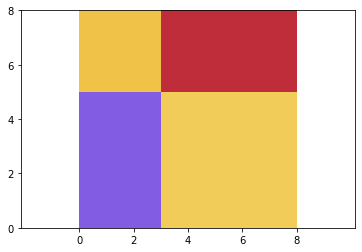

Solution: [[0, 5], [0, 0], [3, 5], [3, 0]]
[w, h]:   [[3, 3], [3, 5], [5, 3], [5, 5]]

Tot: 1

0
Pieces: [[3, 3], [3, 5], [5, 3], [5, 5]]



|| === Instance 9x9 === ||
YES independent solving on w: 
0.017 secs
coords:   [[6, 6], [0, 5], [0, 0], [6, 0], [3, 0]]


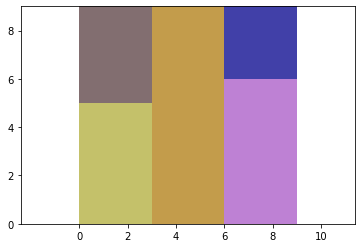

Solution: [[6, 6], [0, 5], [0, 0], [6, 0], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



|| === Instance 10x10 === ||
YES independent solving on w: 
0.028 secs
coords:   [[0, 0], [3, 0], [3, 4], [0, 3], [6, 0], [6, 4]]


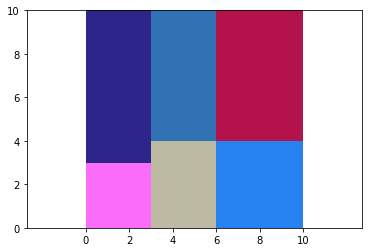

Solution: [[0, 0], [3, 0], [3, 4], [0, 3], [6, 0], [6, 4]]
[w, h]:   [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 6], [3, 7], [4, 4], [4, 6]]



|| === Instance 11x11 === ||
NO independent solving on w
0.030 secs
coords:   [[5, 8], [5, 4], [8, 0], [8, 5], [0, 8], [0, 4], [0, 0]]


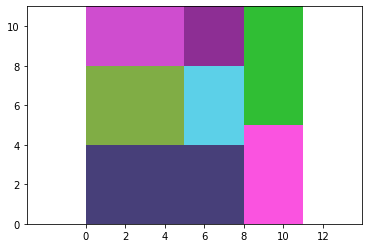

Solution: [[5, 8], [5, 4], [8, 0], [8, 5], [0, 8], [0, 4], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [5, 3], [5, 4], [8, 4]]



|| === Instance 12x12 === ||
NO independent solving on w
0.047 secs
coords:   [[3, 6], [9, 8], [6, 7], [3, 0], [6, 0], [9, 0], [0, 0], [0, 9]]


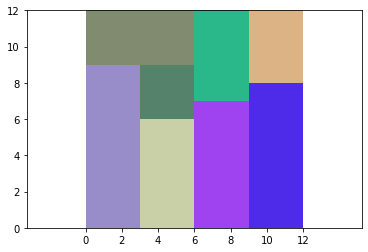

Solution: [[3, 6], [9, 8], [6, 7], [3, 0], [6, 0], [9, 0], [0, 0], [0, 9]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [6, 3]]



|| === Instance 13x13 === ||
NO independent solving on w
0.057 secs
coords:   [[7, 10], [3, 6], [10, 0], [0, 7], [0, 0], [10, 5], [3, 10], [6, 6], [3, 0]]


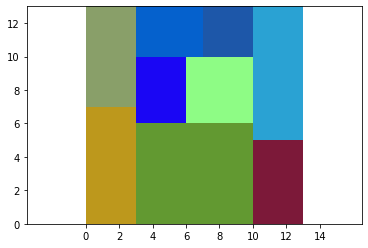

Solution: [[7, 10], [3, 6], [10, 0], [0, 7], [0, 0], [10, 5], [3, 10], [6, 6], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 3], [4, 4], [7, 6]]



|| === Instance 14x14 === ||
YES independent solving on w: 
0.043 secs
coords:   [[0, 11], [0, 0], [3, 9], [6, 8], [0, 4], [6, 0], [3, 0], [9, 10], [9, 0]]


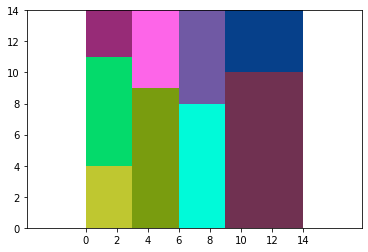

Solution: [[0, 11], [0, 0], [3, 9], [6, 8], [0, 4], [6, 0], [3, 0], [9, 10], [9, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [5, 4], [5, 10]]



|| === Instance 15x15 === ||
NO independent solving on w
0.092 secs
coords:   [[6, 0], [9, 8], [12, 7], [0, 9], [12, 0], [9, 0], [0, 0], [6, 3], [3, 0], [9, 12]]


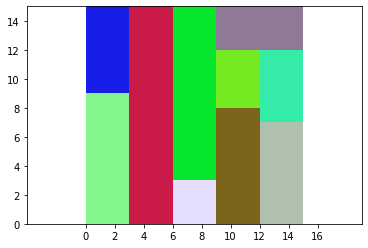

Solution: [[6, 0], [9, 8], [12, 7], [0, 9], [12, 0], [9, 0], [0, 0], [6, 3], [3, 0], [9, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 12], [3, 15], [6, 3]]



|| === Instance 16x16 === ||
NO independent solving on w
0.089 secs
coords:   [[10, 8], [0, 12], [10, 11], [13, 10], [7, 9], [10, 0], [13, 0], [0, 0], [3, 9], [3, 0]]


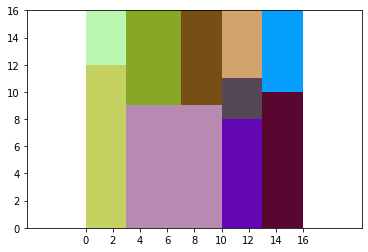

Solution: [[10, 8], [0, 12], [10, 11], [13, 10], [7, 9], [10, 0], [13, 0], [0, 0], [3, 9], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 12], [4, 7], [7, 9]]



|| === Instance 17x17 === ||
NO independent solving on w
0.170 secs
coords:   [[14, 11], [0, 0], [14, 6], [0, 4], [0, 10], [3, 9], [3, 0], [13, 14], [10, 6], [6, 0], [6, 14], [10, 0]]


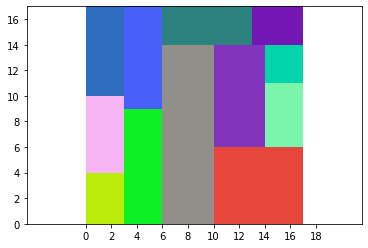

Solution: [[14, 11], [0, 0], [14, 6], [0, 4], [0, 10], [3, 9], [3, 0], [13, 14], [10, 6], [6, 0], [6, 14], [10, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [4, 3], [4, 8], [4, 14], [7, 3], [7, 6]]



|| === Instance 18x18 === ||
YES independent solving on w: 
0.150 secs
coords:   [[0, 4], [0, 0], [6, 13], [6, 7], [6, 0], [3, 0], [3, 8], [0, 7], [9, 0], [9, 3], [9, 7], [9, 12], [13, 11], [13, 14], [13, 6], [13, 0]]


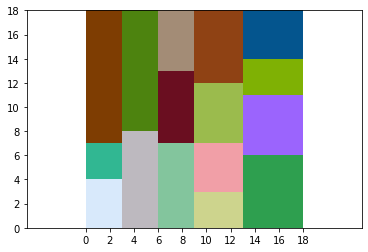

Solution: [[0, 4], [0, 0], [6, 13], [6, 7], [6, 0], [3, 0], [3, 8], [0, 7], [9, 0], [9, 3], [9, 7], [9, 12], [13, 11], [13, 14], [13, 6], [13, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 10], [3, 11], [4, 3], [4, 4], [4, 5], [4, 6], [5, 3], [5, 4], [5, 5], [5, 6]]



|| === Instance 19x19 === ||
YES independent solving on w: 
0.169 secs
coords:   [[6, 0], [3, 15], [3, 0], [12, 13], [6, 3], [9, 0], [6, 10], [3, 5], [9, 8], [12, 0], [0, 0], [15, 14], [15, 8], [15, 0]]


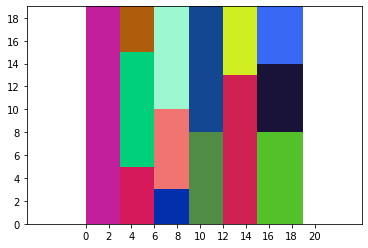

Solution: [[6, 0], [3, 15], [3, 0], [12, 13], [6, 3], [9, 0], [6, 10], [3, 5], [9, 8], [12, 0], [0, 0], [15, 14], [15, 8], [15, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 19], [4, 5], [4, 6], [4, 8]]



|| === Instance 20x20 === ||
YES independent solving on w: 
0.209 secs
coords:   [[3, 17], [9, 0], [6, 0], [9, 14], [6, 5], [6, 12], [0, 0], [9, 4], [0, 9], [3, 0], [12, 17], [16, 11], [16, 0], [12, 0]]


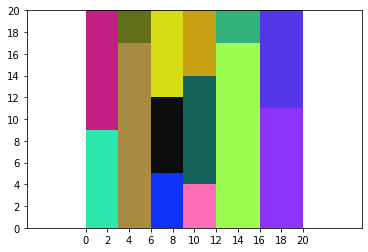

Solution: [[3, 17], [9, 0], [6, 0], [9, 14], [6, 5], [6, 12], [0, 0], [9, 4], [0, 9], [3, 0], [12, 17], [16, 11], [16, 0], [12, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 17], [4, 3], [4, 9], [4, 11], [4, 17]]



|| === Instance 21x21 === ||
YES independent solving on w: 
0.105 secs
coords:   [[0, 0], [6, 0], [9, 16], [9, 10], [3, 14], [6, 4], [6, 12], [9, 0], [3, 0], [0, 3], [12, 11], [12, 15], [12, 0], [16, 15], [16, 0]]


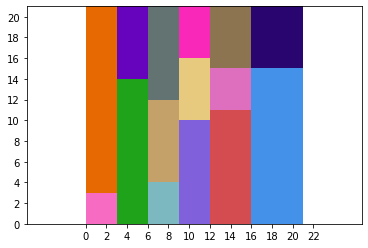

Solution: [[0, 0], [6, 0], [9, 16], [9, 10], [3, 14], [6, 4], [6, 12], [9, 0], [3, 0], [0, 3], [12, 11], [12, 15], [12, 0], [16, 15], [16, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 14], [3, 18], [4, 4], [4, 6], [4, 11], [5, 6], [5, 15]]



|| === Instance 22x22 === ||
NO independent solving on w
0.363 secs
coords:   [[19, 0], [16, 11], [19, 17], [0, 4], [16, 15], [3, 4], [6, 13], [3, 12], [16, 0], [0, 10], [6, 0], [19, 3], [13, 0], [9, 19], [9, 0], [0, 0]]


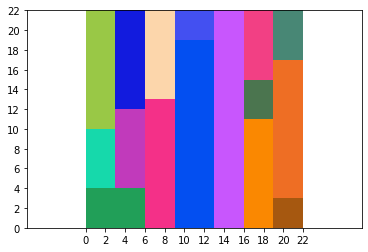

Solution: [[19, 0], [16, 11], [19, 17], [0, 4], [16, 15], [3, 4], [6, 13], [3, 12], [16, 0], [0, 10], [6, 0], [19, 3], [13, 0], [9, 19], [9, 0], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



|| === Instance 23x23 === ||
NO independent solving on w
22.414 secs
coords:   [[0, 0], [17, 14], [17, 18], [20, 17], [20, 10], [0, 15], [3, 0], [20, 0], [7, 9], [0, 3], [17, 0], [10, 0], [6, 0], [3, 19], [6, 3], [3, 9], [13, 12], [13, 0], [7, 20]]


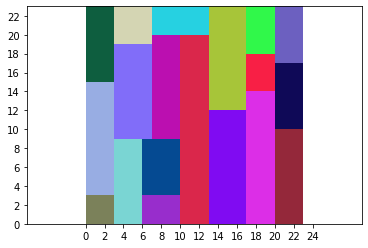

Solution: [[0, 0], [17, 14], [17, 18], [20, 17], [20, 10], [0, 15], [3, 0], [20, 0], [7, 9], [0, 3], [17, 0], [10, 0], [6, 0], [3, 19], [6, 3], [3, 9], [13, 12], [13, 0], [7, 20]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 20], [4, 3], [4, 4], [4, 6], [4, 10], [4, 11], [4, 12], [6, 3]]



|| === Instance 24x24 === ||
YES independent solving on w: 
0.294 secs
coords:   [[6, 21], [6, 0], [6, 16], [0, 18], [3, 8], [3, 0], [3, 15], [9, 0], [6, 4], [9, 10], [0, 0], [12, 0], [15, 0], [15, 20], [15, 15], [15, 3], [19, 0], [19, 8]]


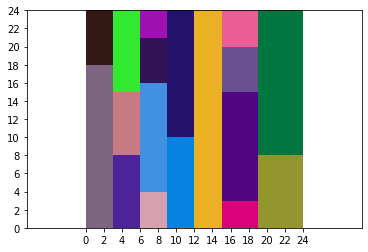

Solution: [[6, 21], [6, 0], [6, 16], [0, 18], [3, 8], [3, 0], [3, 15], [9, 0], [6, 4], [9, 10], [0, 0], [12, 0], [15, 0], [15, 20], [15, 15], [15, 3], [19, 0], [19, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 14], [3, 18], [3, 24], [4, 3], [4, 4], [4, 5], [4, 12], [5, 8], [5, 16]]



|| === Instance 25x25 === ||
NO independent solving on w
6.767 secs
coords:   [[15, 17], [22, 10], [15, 20], [0, 19], [12, 18], [6, 17], [3, 16], [22, 0], [22, 14], [3, 3], [6, 3], [15, 0], [12, 0], [0, 0], [9, 0], [18, 0], [18, 5], [18, 12], [3, 0]]


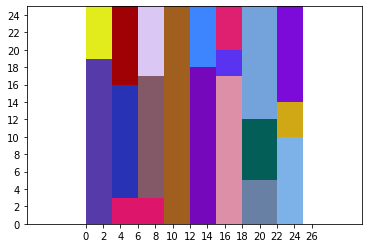

Solution: [[15, 17], [22, 10], [15, 20], [0, 19], [12, 18], [6, 17], [3, 16], [22, 0], [22, 14], [3, 3], [6, 3], [15, 0], [12, 0], [0, 0], [9, 0], [18, 0], [18, 5], [18, 12], [3, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 17], [3, 18], [3, 19], [3, 25], [4, 5], [4, 7], [4, 13], [6, 3]]



|| === Instance 26x26 === ||
YES independent solving on w: 
0.693 secs
coords:   [[9, 23], [3, 22], [9, 18], [9, 12], [15, 19], [3, 14], [12, 0], [0, 16], [6, 15], [9, 0], [3, 0], [6, 0], [0, 0], [12, 9], [15, 0], [18, 23], [22, 22], [18, 0], [18, 16], [22, 0], [18, 5], [22, 8]]


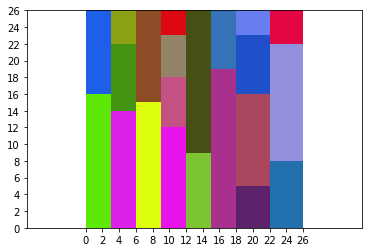

Solution: [[9, 23], [3, 22], [9, 18], [9, 12], [15, 19], [3, 14], [12, 0], [0, 16], [6, 15], [9, 0], [3, 0], [6, 0], [0, 0], [12, 9], [15, 0], [18, 23], [22, 22], [18, 0], [18, 16], [22, 0], [18, 5], [22, 8]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 17], [3, 19], [4, 3], [4, 4], [4, 5], [4, 7], [4, 8], [4, 11], [4, 14]]



|| === Instance 27x27 === ||
YES independent solving on w: 
0.327 secs
coords:   [[9, 0], [12, 0], [9, 3], [0, 0], [3, 0], [6, 19], [9, 8], [9, 17], [12, 4], [12, 15], [6, 0], [3, 7], [0, 6], [19, 4], [19, 0], [15, 0], [15, 20], [23, 0], [15, 6], [23, 8], [19, 7]]


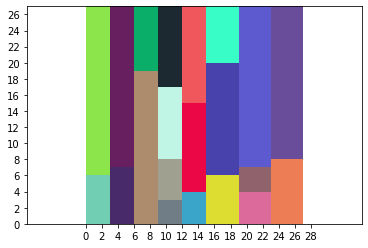

Solution: [[9, 0], [12, 0], [9, 3], [0, 0], [3, 0], [6, 19], [9, 8], [9, 17], [12, 4], [12, 15], [6, 0], [3, 7], [0, 6], [19, 4], [19, 0], [15, 0], [15, 20], [23, 0], [15, 6], [23, 8], [19, 7]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 19], [3, 20], [3, 21], [4, 3], [4, 4], [4, 6], [4, 7], [4, 8], [4, 14], [4, 19], [4, 20]]



|| === Instance 28x28 === ||
YES independent solving on w: 
0.491 secs
coords:   [[3, 10], [12, 8], [6, 23], [3, 13], [0, 21], [12, 0], [3, 19], [3, 0], [9, 0], [12, 12], [9, 11], [0, 0], [6, 0], [15, 25], [15, 13], [19, 0], [15, 17], [15, 0], [19, 5], [23, 13], [23, 19], [23, 0]]


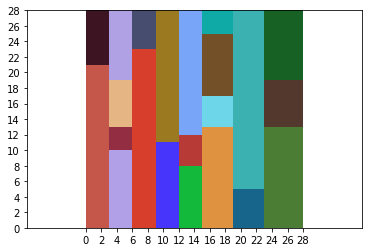

Solution: [[3, 10], [12, 8], [6, 23], [3, 13], [0, 21], [12, 0], [3, 19], [3, 0], [9, 0], [12, 12], [9, 11], [0, 0], [6, 0], [15, 25], [15, 13], [19, 0], [15, 17], [15, 0], [19, 5], [23, 13], [23, 19], [23, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 16], [3, 17], [3, 21], [3, 23], [4, 3], [4, 4], [4, 5], [4, 8], [4, 13], [4, 23], [5, 6], [5, 9], [5, 13]]



|| === Instance 29x29 === ||
YES independent solving on w: 
0.579 secs
coords:   [[9, 0], [6, 25], [0, 17], [0, 0], [0, 22], [9, 21], [3, 20], [6, 15], [0, 6], [6, 0], [9, 3], [3, 0], [16, 19], [16, 0], [20, 24], [20, 18], [16, 22], [12, 20], [16, 4], [20, 0], [12, 0], [24, 8], [24, 0], [24, 12]]


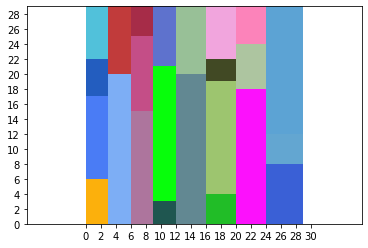

Solution: [[9, 0], [6, 25], [0, 17], [0, 0], [0, 22], [9, 21], [3, 20], [6, 15], [0, 6], [6, 0], [9, 3], [3, 0], [16, 19], [16, 0], [20, 24], [20, 18], [16, 22], [12, 20], [16, 4], [20, 0], [12, 0], [24, 8], [24, 0], [24, 12]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [3, 18], [3, 20], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 9], [4, 15], [4, 18], [4, 20], [5, 4], [5, 8], [5, 17]]



|| === Instance 30x30 === ||
YES independent solving on w: 
0.461 secs
coords:   [[17, 6], [17, 18], [23, 25], [17, 0], [14, 23], [17, 22], [17, 9], [14, 13], [11, 19], [14, 0], [20, 0], [20, 14], [11, 0], [23, 0], [26, 8], [26, 11], [26, 15], [26, 0], [26, 21], [0, 0]]


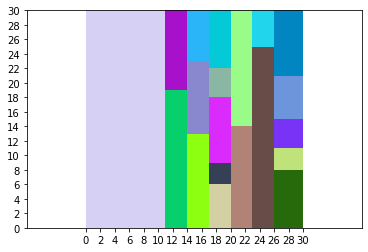

Solution: [[17, 6], [17, 18], [23, 25], [17, 0], [14, 23], [17, 22], [17, 9], [14, 13], [11, 19], [14, 0], [20, 0], [20, 14], [11, 0], [23, 0], [26, 8], [26, 11], [26, 15], [26, 0], [26, 21], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [3, 14], [3, 16], [3, 19], [3, 25], [4, 3], [4, 4], [4, 6], [4, 8], [4, 9], [11, 30]]



|| === Instance 31x31 === ||
YES independent solving on w: 
0.423 secs
coords:   [[6, 10], [0, 13], [9, 6], [9, 0], [6, 24], [9, 23], [12, 22], [6, 0], [6, 13], [9, 11], [0, 0], [0, 17], [12, 0], [3, 0], [15, 13], [15, 16], [15, 23], [15, 0], [19, 0]]


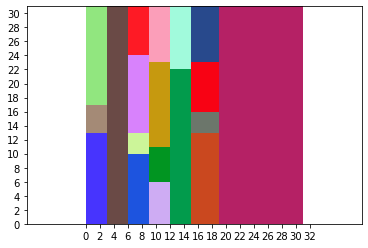

Solution: [[6, 10], [0, 13], [9, 6], [9, 0], [6, 24], [9, 23], [12, 22], [6, 0], [6, 13], [9, 11], [0, 0], [0, 17], [12, 0], [3, 0], [15, 13], [15, 16], [15, 23], [15, 0], [19, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [3, 31], [4, 3], [4, 7], [4, 8], [4, 13], [12, 31]]



|| === Instance 32x32 === ||
YES independent solving on w: 
1.718 secs
coords:   [[3, 29], [3, 0], [18, 0], [12, 11], [15, 13], [6, 24], [9, 0], [0, 0], [12, 0], [15, 20], [15, 0], [21, 18], [12, 17], [21, 0], [0, 10], [9, 9], [6, 0], [3, 4], [18, 5], [28, 13], [24, 10], [28, 16], [28, 0], [28, 6], [24, 0], [28, 21], [24, 14]]


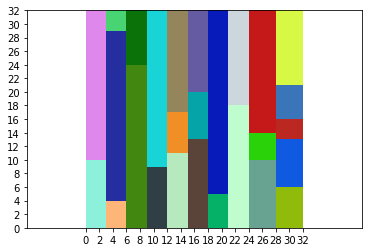

Solution: [[3, 29], [3, 0], [18, 0], [12, 11], [15, 13], [6, 24], [9, 0], [0, 0], [12, 0], [15, 20], [15, 0], [21, 18], [12, 17], [21, 0], [0, 10], [9, 9], [6, 0], [3, 4], [18, 5], [28, 13], [24, 10], [28, 16], [28, 0], [28, 6], [24, 0], [28, 21], [24, 14]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 15], [3, 18], [3, 22], [3, 23], [3, 24], [3, 25], [3, 27], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 10], [4, 11], [4, 18]]



|| === Instance 33x33 === ||
YES independent solving on w: 
0.908 secs
coords:   [[0, 0], [15, 0], [9, 8], [12, 0], [9, 26], [9, 0], [6, 24], [12, 6], [9, 13], [15, 19], [15, 4], [12, 16], [6, 0], [0, 3], [3, 0], [18, 0], [22, 0], [18, 13], [18, 

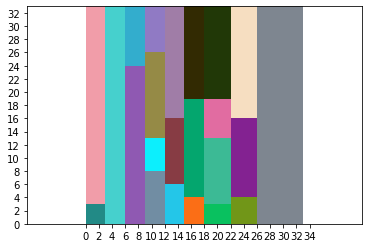

Solution: [[0, 0], [15, 0], [9, 8], [12, 0], [9, 26], [9, 0], [6, 24], [12, 6], [9, 13], [15, 19], [15, 4], [12, 16], [6, 0], [0, 3], [3, 0], [18, 0], [22, 0], [18, 13], [18, 3], [22, 4], [18, 19], [22, 16], [26, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 13], [3, 14], [3, 15], [3, 17], [3, 24], [3, 30], [3, 33], [4, 3], [4, 4], [4, 6], [4, 10], [4, 12], [4, 14], [4, 17], [7, 33]]



|| === Instance 34x34 === ||
YES independent solving on w: 
0.608 secs
coords:   [[9, 6], [6, 0], [3, 0], [9, 0], [3, 27], [0, 26], [6, 25], [6, 4], [6, 14], [0, 0], [12, 0], [0, 12], [12, 13], [3, 5], [9, 9], [15, 0], [18, 11], [18, 29], [18, 0], [18, 15], [22, 0]]


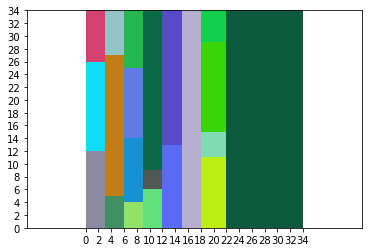

Solution: [[9, 6], [6, 0], [3, 0], [9, 0], [3, 27], [0, 26], [6, 25], [6, 4], [6, 14], [0, 0], [12, 0], [0, 12], [12, 13], [3, 5], [9, 9], [15, 0], [18, 11], [18, 29], [18, 0], [18, 15], [22, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 21], [3, 22], [3, 25], [3, 34], [4, 4], [4, 5], [4, 11], [4, 14], [12, 34]]



|| === Instance 35x35 === ||
YES independent solving on w: 
0.438 secs
coords:   [[0, 0], [0, 31], [3, 8], [0, 3], [6, 28], [3, 0], [6, 19], [3, 25], [3, 13], [6, 0], [0, 9], [9, 17], [9, 25], [9, 20], [9, 29], [13, 0], [13, 27], [17, 0], [9, 0], [13, 7], [17, 12], [21, 0]]


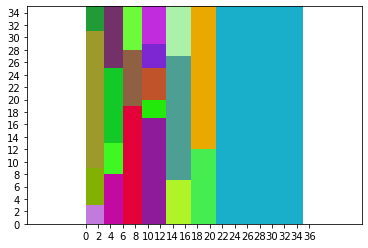

Solution: [[0, 0], [0, 31], [3, 8], [0, 3], [6, 28], [3, 0], [6, 19], [3, 25], [3, 13], [6, 0], [0, 9], [9, 17], [9, 25], [9, 20], [9, 29], [13, 0], [13, 27], [17, 0], [9, 0], [13, 7], [17, 12], [21, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 19], [3, 22], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8], [4, 12], [4, 17], [4, 20], [4, 23], [14, 35]]



|| === Instance 36x36 === ||
YES independent solving on w: 
0.681 secs
coords:   [[18, 0], [18, 3], [18, 31], [15, 16], [12, 21], [12, 28], [18, 22], [12, 11], [12, 0], [21, 24], [15, 22], [18, 7], [15, 0], [21, 0], [24, 0], [27, 33], [27, 22], [27, 0], [31, 33], [31, 0], [31, 4], [31, 18], [0, 0]]


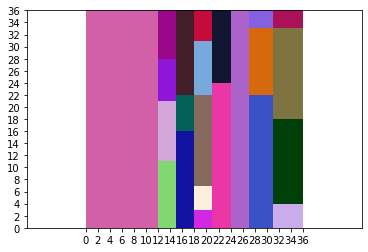

Solution: [[18, 0], [18, 3], [18, 31], [15, 16], [12, 21], [12, 28], [18, 22], [12, 11], [12, 0], [21, 24], [15, 22], [18, 7], [15, 0], [21, 0], [24, 0], [27, 33], [27, 22], [27, 0], [31, 33], [31, 0], [31, 4], [31, 18], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 14], [3, 15], [3, 16], [3, 24], [3, 36], [4, 3], [4, 11], [4, 22], [5, 3], [5, 4], [5, 14], [5, 15], [12, 36]]



|| === Instance 37x37 === ||
YES independent solving on w: 
0.650 secs
coords:   [[18, 26], [21, 22], [18, 21], [12, 31], [15, 30], [18, 29], [21, 0], [21, 26], [15, 0], [21, 9], [12, 0], [12, 14], [15, 12], [18, 0], [28, 0], [28, 27], [24, 32], [28, 31], [24, 22], [24, 0], [28, 3], [32, 14], [32, 0], [32, 31], [32, 4], [32, 17], [0, 0]]


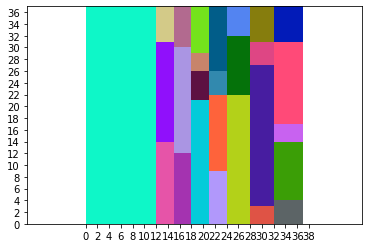

Solution: [[18, 26], [21, 22], [18, 21], [12, 31], [15, 30], [18, 29], [21, 0], [21, 26], [15, 0], [21, 9], [12, 0], [12, 14], [15, 12], [18, 0], [28, 0], [28, 27], [24, 32], [28, 31], [24, 22], [24, 0], [28, 3], [32, 14], [32, 0], [32, 31], [32, 4], [32, 17], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 11], [3, 12], [3, 13], [3, 14], [3, 17], [3, 18], [3, 21], [4, 3], [4, 4], [4, 5], [4, 6], [4, 10], [4, 22], [4, 24], [5, 3], [5, 4], [5, 6], [5, 10], [5, 14], [12, 37]]



|| === Instance 38x38 === ||
YES independent solving on w: 
0.349 secs
coords:   [[27, 20], [27, 9], [27, 23], [24, 32], [27, 13], [24, 13], [27, 0], [27, 28], [24, 21], [24, 0], [30, 8], [34, 33], [34, 27], [30, 0], [30, 27], [34, 15], 

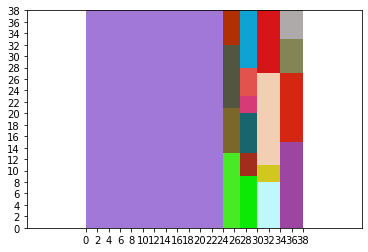

Solution: [[27, 20], [27, 9], [27, 23], [24, 32], [27, 13], [24, 13], [27, 0], [27, 28], [24, 21], [24, 0], [30, 8], [34, 33], [34, 27], [30, 0], [30, 27], [34, 15], [34, 0], [30, 11], [0, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 13], [4, 3], [4, 5], [4, 6], [4, 8], [4, 11], [4, 12], [4, 15], [4, 16], [24, 38]]



|| === Instance 39x39 === ||
YES independent solving on w: 
0.757 secs
coords:   [[0, 0], [0, 18], [3, 9], [3, 25], [0, 22], [3, 31], [3, 0], [0, 29], [3, 14], [0, 3], [6, 8], [6, 11], [10, 6], [10, 0], [6, 0], [6, 15], [10, 11], [6, 24], [10, 23], [14, 0], [14, 3], [19, 0], [14, 15], [14, 7], [19, 29], [19, 18], [19, 5], [14, 21], [24, 0]]


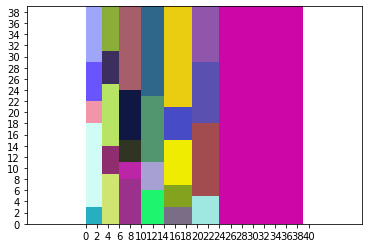

Solution: [[0, 0], [0, 18], [3, 9], [3, 25], [0, 22], [3, 31], [3, 0], [0, 29], [3, 14], [0, 3], [6, 8], [6, 11], [10, 6], [10, 0], [6, 0], [6, 15], [10, 11], [6, 24], [10, 23], [14, 0], [14, 3], [19, 0], [14, 15], [14, 7], [19, 29], [19, 18], [19, 5], [14, 21], [24, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 15], [4, 3], [4, 4], [4, 5], [4, 6], [4, 8], [4, 9], [4, 12], [4, 15], [4, 16], [5, 3], [5, 4], [5, 5], [5, 6], [5, 8], [5, 10], [5, 11], [5, 13], [5, 18], [15, 39]]



|| === Instance 40x40 === ||
YES independent solving on w: 
0.267 secs
coords:   [[0, 25], [0, 36], [6, 35], [6, 0], [6, 6], [0, 28], [0, 16], [6, 13], [6, 23], [0, 0], [3, 0], [9, 36], [9, 0], [9, 14], [13

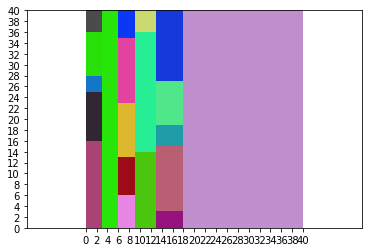

Solution: [[0, 25], [0, 36], [6, 35], [6, 0], [6, 6], [0, 28], [0, 16], [6, 13], [6, 23], [0, 0], [3, 0], [9, 36], [9, 0], [9, 14], [13, 0], [13, 15], [13, 19], [13, 3], [13, 27], [18, 0]]
[w, h]:   [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]

Tot: 1

0
Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 12], [3, 16], [3, 40], [4, 4], [4, 14], [4, 22], [5, 3], [5, 4], [5, 8], [5, 12], [5, 13], [22, 40]]



Wall time: 1min 20s


In [7]:
%%time
import time

starting_instance = 8
ending_instance = 40

for i in range(starting_instance, ending_instance+1):
    
    path = f"Instances/{i}x{i}.txt"
    pr_w, pr_h, n_pieces, L = read_instance(path)
    
    print(f"|| === Instance {i}x{i} === ||")
    unordered_pieces = list(L)
    
    model = create_model(pr_w, pr_h, n_pieces, L) #0: variables, 1:constraints
    q = model[0]
    s = Solver()
    
    s.add(model[1])
    # s.set("timeout", 600)
    
    start = time.time()
    res = s.check()
    end = time.time()
    print("%.3f secs" % (end - start))

    if res == z3.unsat:
        print("Unsat")
        continue
    
    sol = s.model()
    solution=[[sol[q[p][0]].as_long(), sol[q[p][1]].as_long()] for p in range(n_pieces)]
    
    sol_print = {'q': solution}
    print_solutions(sol_print, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})
    save_solution("SMT/out", pr_w, pr_h, n_pieces, L, sol_print)    
    print(f"Pieces: {L}")
    print("\n\n")




ROTATION (point 5)

In [43]:
"""
Function to have the correct width and/or height according to the rotation information for each pieces
"""
def get_dim(i, rot, d): # i-th piece, rot=0|1(90° rotation), d=0|1(0: width, 1:height)
    r = IntSort().cast(BoolVal(rot))
    return If(rot, int(L[i][1-d]), int(L[i][d]))

def create_model_with_rotation(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    
    # !!!New Variables added!!! - Rotations pieces Information
    rot = [ Bool("rot_%s" % (i)) for i in range(n_pieces) ] # false: no rotation, true:90° rotated
    domain = [And(0<=q[i][0],q[i][0]<=pr_w-get_dim(i,rot[i],0),0<=q[i][1],q[i][1]<= pr_h-get_dim(i,rot[i],1)) for i in range(n_pieces)]
    
    # !!!New Constraints added!!!
    square_no_rot = [ Implies(L[i][0]==L[i][1], Not(rot[i])) for i in range(n_pieces)] # no rotation for the square pieces(w==h)
    force_rot = [ Or(rot) ] # not necessary, I added this constraint to force on having a solution with at least one piece rotated, just for demonstration and visualization
    
    # The same as create_model but using the new function get_dim instead of L[i][0|1]
    #--Symmetry breaking rules--
    #  Domain reduction
    areas = [L[i][0]*L[i][1] for i in range(n_pieces)]
    index_largest_p = areas.index(max(areas))
    domain_red = [And(q[index_largest_p][0]<=(pr_w-get_dim(index_largest_p,rot[index_largest_p],0))/2, q[index_largest_p][1]<=(pr_h-get_dim(index_largest_p,rot[index_largest_p],1))/2)]
    
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    #--Large Rectangles--And(Implies(pack, dep))
    large_rec_1 = [And(
            Implies(get_dim(i,rot[i],0)+get_dim(j,rot[j],0)>pr_w, And(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Not(l_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    large_rec_2 = [And(
            Implies(get_dim(i,rot[i],1)+get_dim(j,rot[j],1)>pr_h, And(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Not(u_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    l_val = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+get_dim(i,rot[i],0)<=q[j][0])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    u_val = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+get_dim(i,rot[i],1)<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    e = Int('e')
    f = Int('f')

    e_dom = [And(e>=0, e<=pr_w-get_dim(i,rot[i],0)) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-get_dim(i,rot[i],1)) for i in range(n_pieces)]

    Px = [ Bool("px_%s" % (i)) for i in range(n_pieces) ]
    Py = [ Bool("py_%s" % (i)) for i in range(n_pieces) ]


    px_t = [And(Px[i]==(q[i][0]<=e),
               ) for i in range(n_pieces)]
    py_t = [And(Py[i]==(q[i][1]<=f),
               ) for i in range(n_pieces)]

    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(Px[i]), q[i][0]<=(e+1)
         )) for i in range(n_pieces)]
    o_e_py = [ And(
        Or(
            Not(Py[i]), q[i][1]<=(f+1)
         )) for i in range(n_pieces)]

    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    return q, rot, domain + square_no_rot + force_rot + domain_red  + large_rec_1 + large_rec_2 + l_val + u_val + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1

|| === Instance 9x9 === ||
0.023 secs
coords:   [[6, 6], [5, 0], [0, 0], [0, 6], [0, 3]]
rotation: [False, True, True, True, True]


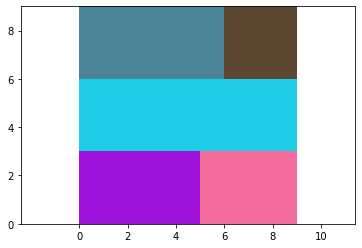

Solution: [[6, 6], [5, 0], [0, 0], [0, 6], [0, 3]]
[w, h]:   [[3, 3], [4, 3], [5, 3], [6, 3], [9, 3]]

Tot: 1

Pieces: [[3, 3], [3, 4], [3, 5], [3, 6], [3, 9]]



Wall time: 219 ms


In [44]:
%%time
import time
"""
Demonstration of the model with allowed rotation
"""

instance = "9x9"
path = f"Instances/{instance}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
    
print(f"|| === Instance {instance} === ||")
model = create_model_with_rotation(pr_w, pr_h, n_pieces, L) #0: variables, 1:constraints

q = model[0]
rot = model[1]
s = Solver()
    
s.add(model[2])
start = time.time()
res = s.check()
end = time.time()
print("%.3f secs" % (end - start))

if res == z3.unsat:
    print("Unsat")
else:  
    sol = s.model()
    solution=[[sol[q[p][0]].as_long(), sol[q[p][1]].as_long()] for p in range(n_pieces)]
    rotation = [is_true(sol[rot[p]]) for p in range(n_pieces)]
    sol_print = {'q': solution, 'rot': rotation}
    print_solutions(sol_print, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

    print(f"Pieces: {L}")
    print("\n\n")


SAME DIMENSION (point 6)

In [45]:
def create_model_same_dim(pr_w, pr_h, n_pieces, L):
    q = [ [ Int("c_%s_%s" % (i, j)) for j in range(2) ] for i in range(n_pieces) ]
    domain = [And(0<=q[i][0],q[i][0]<=pr_w-L[i][0],0<=q[i][1],q[i][1]<= pr_h-L[i][1]) for i in range(n_pieces)]
    
    
    #--Symmetry breaking rules--
    #  Domain reduction
    areas = [L[i][0]*L[i][1] for i in range(n_pieces)]
    index_largest_p = areas.index(max(areas))
    domain_red = [And(q[index_largest_p][0]<=int((pr_w-L[index_largest_p][0])/2), q[index_largest_p][1]<=int((pr_h-L[index_largest_p][1])/2))]
    
    l_i_j = [Bool("l_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    u_i_j = [Bool("u_%s_%s" % (i, j)) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    
    #--Large Rectangles--And(Implies(pack, dep))
    large_rec_1 = [And(
            Implies(L[i][0]+L[j][0]>pr_w, And(Not(l_i_j[i*(n_pieces-1)+(j-1)]), Not(l_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    large_rec_2 = [And(
            Implies(L[i][1]+L[j][1]>pr_h, And(Not(u_i_j[i*(n_pieces-1)+(j-1)]), Not(u_i_j[i+j*(n_pieces-1)])))
         ) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    l_val = [And(l_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][0]+L[i][0]<=q[j][0])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]

    u_val = [And(u_i_j[i*(n_pieces-1)+(j-1 if j>i else j)]==(q[i][1]+L[i][1]<=q[j][1])
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if x != i]]
    
    # !!!New Constraints added!!! If we have rectangles ri and rj which have the same dimension we can fix the positional relation of rectangles.
    # reference: http://ceur-ws.org/Vol-451/paper16soh.pdf 
    same_dim = [And( l_i_j[i+j*(n_pieces-1)], Or(l_i_j[i*(n_pieces-1)+(j-1)], Not(u_i_j[i+j*(n_pieces-1)]))
                  ) for i in range(n_pieces) for j in [x for x in range(n_pieces) if (i < x and L[i][0]==L[x][0] and L[i][1]==L[x][1])]]
    
    e = Int('e')
    f = Int('f')

    e_dom = [And(e>=0, e<=pr_w-L[i][0]) for i in range(n_pieces)]
    f_dom = [And(f>=0, f<=pr_h-L[i][1]) for i in range(n_pieces)]

    Px = [ Bool("px_%s" % (i)) for i in range(n_pieces) ]
    Py = [ Bool("py_%s" % (i)) for i in range(n_pieces) ]


    px_t = [And(Px[i]==(q[i][0]<=e),
               ) for i in range(n_pieces)]
    py_t = [And(Py[i]==(q[i][1]<=f),
               ) for i in range(n_pieces)]

    #;Order Encoding
    o_e_px = [ And(
        Or(
            Not(Px[i]), q[i][0]<=(e+1)
         )) for i in range(n_pieces)]
    o_e_py = [ And(
        Or(
            Not(Py[i]), q[i][1]<=(f+1)
         )) for i in range(n_pieces)]

    #;Non-Overlapping 1
    n_o_1 = [ And(
        Or(
            l_i_j[i*(n_pieces-1)+(j-1)], l_i_j[i+j*(n_pieces-1)], u_i_j[i*(n_pieces-1)+(j-1)], u_i_j[i+j*(n_pieces-1)]
         )) for i in range(n_pieces) for j in range(i+1,n_pieces) ]
    
    return q, domain + domain_red + large_rec_1 + large_rec_2 + l_val + u_val + same_dim + e_dom + f_dom + px_t + py_t + o_e_px + o_e_py + n_o_1

|| === Instance 8x8-same-dim === ||
0.018 secs
coords:   [[6, 5], [6, 0], [4, 0], [6, 2], [0, 0], [0, 5], [0, 2], [0, 6]]


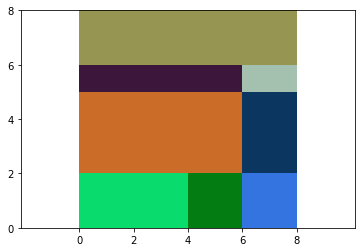

Solution: [[6, 5], [6, 0], [4, 0], [6, 2], [0, 0], [0, 5], [0, 2], [0, 6]]
[w, h]:   [[2, 1], [2, 2], [2, 2], [2, 3], [4, 2], [6, 1], [6, 3], [8, 2]]

Tot: 1

Pieces: [[2, 1], [2, 2], [2, 2], [2, 3], [4, 2], [6, 1], [6, 3], [8, 2]]



Wall time: 204 ms


In [46]:
%%time
import time
"""
Demonstration of the model with allowed rotation
"""

"""
Particular instance
8 8
8
2 1
2 2
2 2
2 3
4 2
6 1
6 3
8 2
"""

instance = "8x8-same-dim"

path = f"Instances/{instance}.txt"
pr_w, pr_h, n_pieces, L = read_instance(path)
    
print(f"|| === Instance {instance} === ||")
model = create_model_same_dim(pr_w, pr_h, n_pieces, L) #0: variables, 1:constraints

q = model[0]
s = Solver()
    
s.add(model[1])
start = time.time()
res = s.check()
end = time.time()
print("%.3f secs" % (end - start))

if res == z3.unsat:
    print("Unsat")
else:  
    sol = s.model()
    solution=[[sol[q[p][0]].as_long(), sol[q[p][1]].as_long()] for p in range(n_pieces)]
    sol_print = {'q': solution}
    print_solutions(sol_print, {'w': pr_w, 'h': pr_h, 'n': n_pieces, 'p': L})

    print(f"Pieces: {L}")
    print("\n\n")
